In [1]:
import tsai.all
import datetime
import pandas as pd
import torch
import numpy as np
import wandb
from fastai.callback.wandb import WandbCallback
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback
import time
import math

In [2]:
%run ../../shared_functions.py
%run ../../my_shared_functions.py

<Figure size 640x480 with 0 Axes>

In [3]:
DIR_INPUT = '../../../fraud-detection-handbook/simulated-data-transformed/data/'

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

Load  files
CPU times: total: 531 ms
Wall time: 513 ms
919767 transactions loaded, containing 8195 fraudulent transactions


### Default

In [6]:
BEGIN_DATE = "2018-08-08"
start_date_training = datetime.datetime.strptime(BEGIN_DATE, "%Y-%m-%d")
delta_train=7
delta_delay=7
delta_test=7


delta_valid = delta_test

(train_df, valid_df)=get_train_test_set(transactions_df,start_date_training,
                                       delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)

SEQ_LEN = 5

In [7]:
SEED = 42

if torch.cuda.is_available():
    DEVICE = "cuda" 
else:
    DEVICE = "cpu"
print("Selected device is",DEVICE)

seed_everything(SEED)

Selected device is cuda


In [8]:
(train_df, valid_df)=scaleData(train_df, valid_df,input_features)
x_train, y_train = prepare_sequenced_X_y(train_df, SEQ_LEN, input_features, output_feature)
x_valid, y_valid = prepare_sequenced_X_y(valid_df, SEQ_LEN, input_features, output_feature)
X, y, splits = tsai.all.combine_split_data([x_train.numpy(), x_valid.numpy()], [y_train.numpy(), y_valid.numpy()])


#### Fit 1 cycle

In [ ]:
config = dict(
    dataset_id = 'fraud-detection-handbook-transformed',
    validation = 'train test split',
    seed = SEED,
    begin_date = BEGIN_DATE,
    delta_train = delta_train,
    delta_delay = delta_delay,
    delta_test = delta_test,
    batch_size=64,
    num_workers=0,
    seq_len=SEQ_LEN,
    hidden_size = 100,
    rnn_layers = 1,
    bias=True,
    rnn_dropout=0.8,
    cell_dropout=0,
    conv_layers=[128, 256, 128],
    kss=[7, 5, 3],
    bidirectional=False,
    fc_dropout=0,
    se=0, # squeeze-and-excite, which equals to 16 for MLSTM-FCN
    optimizer='adam',
    early_stopping=True,
    early_stopping_patience=2,
    max_epochs=100,
    scale=True,
    criterion='bce',
    one_cycle_policy=True
)
wandb.init(project="mgr-anomaly-tsxai-project", config=config, tags=['lstm-fcn', 'tsai', 'imbalance-not-considered'])
config = wandb.config

In [10]:
dsets = tsai.all.TSDatasets(X, y, splits=splits, inplace=True)
dls = tsai.all.TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=config.batch_size, num_workers=config.num_workers, drop_last=False, device=DEVICE)
model = tsai.all.LSTM_FCN(
    c_in=dls.vars, 
    c_out=dls.c,
    seq_len=SEQ_LEN,
    hidden_size=config.hidden_size,
    rnn_layers=config.rnn_layers,
    bias=config.bias,
    cell_dropout=config.cell_dropout,
    rnn_dropout=config.rnn_dropout,
    bidirectional=config.bidirectional,
    fc_dropout=config.fc_dropout,
    conv_layers=config.conv_layers,
    kss=config.kss,
    se=config.se
    )

In [11]:
criterion = tsai.all.BCEWithLogitsLossFlat()
learn = tsai.all.ts_learner(
    dls,
    model,
    loss_func=criterion,
    opt_func=tsai.all.Adam,
    device=DEVICE,
    metrics=[],
    model_dir='LSTM_FCN',
    cbs=[
        WandbCallback(
            log='all',
            log_model=True,
            seed=config.seed),
        EarlyStoppingCallback(
            patience=config.early_stopping_patience
        ),
        SaveModelCallback(
            fname='lstm_fcn_fit_one_cycle'
        )])

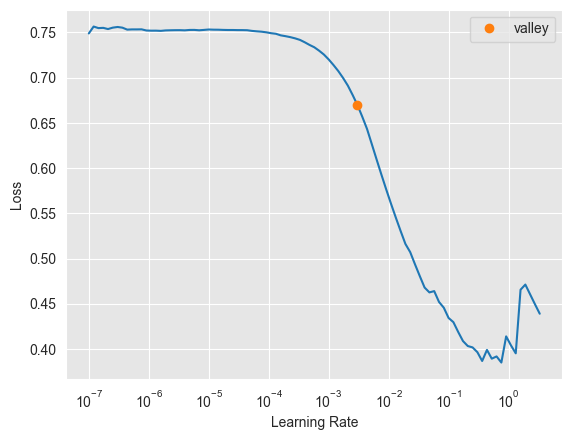

In [12]:
lr = learn.lr_find().valley
wandb.config.update({"lr": lr})

In [13]:
start_time=time.time()
learn.fit_one_cycle(config.max_epochs, lr)
training_execution_time=time.time()-start_time

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


Better model found at epoch 0 with valid_loss value: 0.02634328603744507.
Better model found at epoch 1 with valid_loss value: 0.021374210715293884.
Better model found at epoch 3 with valid_loss value: 0.02114052325487137.
No improvement since epoch 3: early stopping


In [14]:
start_time=time.time()
valid_predictions_logits = get_predictions_sequential(learn.model.cuda(), dls.valid)
prediction_execution_time=time.time()-start_time
predictions_df = valid_df
predictions_df['predictions'] = torch.nn.Sigmoid()(torch.FloatTensor(valid_predictions_logits)).numpy()
    
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])
performance_df

AUC ROC  Average precision  F1 score  Card Precision@100
0    0.886              0.624     0.638               0.296

In [15]:
wandb.log({'Training execution time': training_execution_time})
wandb.log({'Prediction execution time': prediction_execution_time})
wandb.log({'AUC ROC': performance_df.loc[0,'AUC ROC']})
wandb.log({'Average precision': performance_df.loc[0,'Average precision']})
wandb.log({'F1 score': performance_df.loc[0,'F1 score']})
wandb.log({'Card Precision@100': performance_df.loc[0,'Card Precision@100']})
wandb.finish()

### Sweeps

In [7]:
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train=7
delta_delay=7
delta_test=7
delta_valid = delta_test

n_folds=4

start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test)
delta_assessment = delta_valid

In [8]:
SEED = 42
seed_everything(SEED)

prequential_split = []
        
for fold in range(n_folds):
    start_date_training_fold = start_date_training-datetime.timedelta(days=fold*delta_assessment)
    
    (train_df, test_df)=get_train_test_set(transactions_df,
                                            start_date_training=start_date_training_fold,
                                            delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_assessment)
    
    prequential_split.append((train_df, test_df))

In [9]:
SEQ_LEN = 5
if torch.cuda.is_available():
    DEVICE = "cuda" 
else:
    DEVICE = "cpu"
print("Selected device is",DEVICE)

Selected device is cuda


#### Fit 1 cycle

In [14]:
sweep_config = {
                'method': 'random', 
                'metric': {
                    'goal': 'minimize',
                    'name': 'val_loss'
                    },
                'parameters': {
                    'one_cycle_policy' : {
                        'value' : True
                    },
                    'batch_size': {
                        'values' : [64, 128, 256]
                    },
                    'max_epochs': {
                        'values': [5, 10, 15, 20, 30]
                        },
                    'num_workers': {
                        'value' : 0
                    },
                    'seed': {
                        'value' : 42
                    },
                    'hidden_size': {
                        'values' : [100, 200]
                    },
                    'rnn_layers': {
                        'values' : [1, 2]
                    },
                    'bias': {
                        'value' : True
                    },
                    'bidirectional': {
                        'value' : False
                    },
                    # Cell dropout applies dropout to the internal state of the recurrent neural network (RNN) cells, while RNN dropout applies dropout to the output of the RNN cells.
                    # Cell dropout helps prevent overfitting by randomly dropping out a proportion of the internal state of the cells during training,
                    # while RNN dropout helps prevent overfitting by randomly dropping out a proportion of the output of the cells during training.
                    'cell_dropout': {
                        'values' : [0, 0.2, 0.4]
                    },
                    'rnn_dropout': {
                        'values' : [0, 0.2, 0.4]
                    },
                    'fc_dropout': {
                        'values' : [0, 0.2, 0.4]
                    },
                    'conv_layers': {
                        'values' : [[128, 256, 128], [256, 512, 256], [64, 128, 64]]
                    },
                    'kss': {
                        'values' : [[7, 5, 3], [5, 5, 3]]
                    },
                    'se': {
                        'value' : 0
                    }
                }
 }

In [15]:
sweep_id = wandb.sweep(sweep_config, project="mgr-anomaly-tsxai-project")

Create sweep with ID: 73d24ye0
Sweep URL: https://wandb.ai/mgr-anomaly-tsxai/mgr-anomaly-tsxai-project/sweeps/73d24ye0


In [16]:
def train(config=None):
    with wandb.init(project="mgr-anomaly-tsxai-project", config=config, tags=['lstm-fcn', 'tsai', 'imbalance-not-considered', 'sweeps']):
        config = wandb.config
        training_execution_times = []
        prediction_execution_times = []
        aucs = []
        average_precisions = []
        f1_scores = []
        card_precisions = []
        for i in range(n_folds):
            train_df = prequential_split[i][0]
            valid_df = prequential_split[i][1]
            (train_df, valid_df)=scaleData(train_df, valid_df,input_features)
            x_train, y_train = prepare_sequenced_X_y(train_df, SEQ_LEN, input_features, output_feature)
            x_valid, y_valid = prepare_sequenced_X_y(valid_df, SEQ_LEN, input_features, output_feature)
            X, y, tsai_splits = tsai.all.combine_split_data([x_train.numpy(), x_valid.numpy()], [y_train.numpy(), y_valid.numpy()])
            dsets = tsai.all.TSDatasets(X, y, splits=tsai_splits, inplace=True)
            dls = tsai.all.TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=config.batch_size, num_workers=config.num_workers, device=DEVICE, drop_last=False)
            
            model = tsai.all.LSTM_FCN(
                c_in=dls.vars, 
                c_out=dls.c,
                seq_len=SEQ_LEN,
                hidden_size=config.hidden_size,
                rnn_layers=config.rnn_layers,
                bias=config.bias,
                cell_dropout=config.cell_dropout,
                rnn_dropout=config.rnn_dropout,
                bidirectional=config.bidirectional,
                fc_dropout=config.fc_dropout,
                conv_layers=config.conv_layers,
                kss=config.kss,
                se=config.se
                ).to(DEVICE)
                        
            criterion = tsai.all.BCEWithLogitsLossFlat()
            learn = tsai.all.ts_learner(
                dls,
                model,
                loss_func=criterion,
                opt_func=tsai.all.Adam,
                device=DEVICE,
                metrics=[],
                model_dir='LSTM_FCN',
                # no early stopping for multiple folds validation!
                cbs=[
                    WandbCallback(
                        log=None,
                        log_model=False,
                        seed=config.seed)])

            valley = learn.lr_find().valley

            start_time=time.time()
            learn.fit_one_cycle(config.max_epochs, valley)
            training_execution_times.append(time.time()-start_time)

            start_time=time.time()
            valid_predictions_logits = get_predictions_sequential(learn.model.cuda(), dls.valid)
            prediction_execution_time=time.time()-start_time
            predictions_df = valid_df
            predictions_df['predictions'] = torch.nn.Sigmoid()(torch.FloatTensor(valid_predictions_logits)).numpy()
                
            performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])
            aucs.append(performance_df.loc[0,'AUC ROC'])
            average_precisions.append(performance_df.loc[0,'Average precision'])
            f1_scores.append(performance_df.loc[0,'F1 score'])
            card_precisions.append(performance_df.loc[0,'Card Precision@100'])

        wandb.log({'Training execution time': np.sum(training_execution_times) / n_folds})
        wandb.log({'Prediction execution time': np.sum(prediction_execution_times) / n_folds})
        wandb.log({'AUC ROC': np.sum(aucs) / n_folds})
        wandb.log({'Average precision': np.sum(average_precisions) / n_folds})
        wandb.log({'F1 score': np.sum(f1_scores) / n_folds})
        wandb.log({'Card Precision@100': np.sum(card_precisions) / n_folds})

wandb: Agent Starting Run: hh8b36mw with config:
wandb: 	batch_size: 256
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.2
wandb: 	conv_layers: [128, 256, 128]
wandb: 	fc_dropout: 0.2
wandb: 	hidden_size: 200
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 30
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: s4cau4vz with config:
wandb: 	batch_size: 64
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.4
wandb: 	conv_layers: [64, 128, 64]
wandb: 	fc_dropout: 0.2
wandb: 	hidden_size: 100
wandb: 	kss: [5, 5, 3]
wandb: 	max_epochs: 20
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.2
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uo5uel73 with config:
wandb: 	batch_size: 64
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0
wandb: 	conv_layers: [128, 256, 128]
wandb: 	fc_dropout: 0
wandb: 	hidden_size: 100
wandb: 	kss: [5, 5, 3]
wandb: 	max_epochs: 5
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: fv7vpuoo with config:
wandb: 	batch_size: 64
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.2
wandb: 	conv_layers: [64, 128, 64]
wandb: 	fc_dropout: 0
wandb: 	hidden_size: 100
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.2
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: gp6i10or with config:
wandb: 	batch_size: 128
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.2
wandb: 	conv_layers: [128, 256, 128]
wandb: 	fc_dropout: 0.2
wandb: 	hidden_size: 200
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 30
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.4
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: sqsryi8e with config:
wandb: 	batch_size: 256
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.2
wandb: 	conv_layers: [64, 128, 64]
wandb: 	fc_dropout: 0
wandb: 	hidden_size: 100
wandb: 	kss: [5, 5, 3]
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.4
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: k4zr4ifg with config:
wandb: 	batch_size: 256
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.2
wandb: 	conv_layers: [64, 128, 64]
wandb: 	fc_dropout: 0
wandb: 	hidden_size: 100
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 30
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.2
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cy1xh8gc with config:
wandb: 	batch_size: 256
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.4
wandb: 	conv_layers: [256, 512, 256]
wandb: 	fc_dropout: 0.2
wandb: 	hidden_size: 200
wandb: 	kss: [5, 5, 3]
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.4
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: ghh3axeu with config:
wandb: 	batch_size: 128
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0
wandb: 	conv_layers: [256, 512, 256]
wandb: 	fc_dropout: 0
wandb: 	hidden_size: 200
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 20
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: p90fg3dr with config:
wandb: 	batch_size: 256
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0
wandb: 	conv_layers: [256, 512, 256]
wandb: 	fc_dropout: 0.2
wandb: 	hidden_size: 200
wandb: 	kss: [5, 5, 3]
wandb: 	max_epochs: 20
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.2
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: jjg5c1ya with config:
wandb: 	batch_size: 256
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.2
wandb: 	conv_layers: [256, 512, 256]
wandb: 	fc_dropout: 0.4
wandb: 	hidden_size: 100
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 5
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: g0wjdnut with config:
wandb: 	batch_size: 64
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.4
wandb: 	conv_layers: [64, 128, 64]
wandb: 	fc_dropout: 0
wandb: 	hidden_size: 200
wandb: 	kss: [5, 5, 3]
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.4
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: gbxodw9a with config:
wandb: 	batch_size: 256
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0
wandb: 	conv_layers: [128, 256, 128]
wandb: 	fc_dropout: 0
wandb: 	hidden_size: 100
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 5
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 0n9d55lq with config:
wandb: 	batch_size: 64
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0
wandb: 	conv_layers: [256, 512, 256]
wandb: 	fc_dropout: 0.4
wandb: 	hidden_size: 100
wandb: 	kss: [5, 5, 3]
wandb: 	max_epochs: 30
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.4
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: anhwl6sl with config:
wandb: 	batch_size: 128
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0
wandb: 	conv_layers: [128, 256, 128]
wandb: 	fc_dropout: 0.2
wandb: 	hidden_size: 100
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 30
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 05glezqz with config:
wandb: 	batch_size: 128
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0
wandb: 	conv_layers: [64, 128, 64]
wandb: 	fc_dropout: 0
wandb: 	hidden_size: 200
wandb: 	kss: [5, 5, 3]
wandb: 	max_epochs: 20
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 8m3qa617 with config:
wandb: 	batch_size: 256
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0
wandb: 	conv_layers: [128, 256, 128]
wandb: 	fc_dropout: 0.2
wandb: 	hidden_size: 200
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.2
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: po100ru7 with config:
wandb: 	batch_size: 64
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0
wandb: 	conv_layers: [128, 256, 128]
wandb: 	fc_dropout: 0.4
wandb: 	hidden_size: 100
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 30
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: j250akry with config:
wandb: 	batch_size: 128
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.4
wandb: 	conv_layers: [64, 128, 64]
wandb: 	fc_dropout: 0.2
wandb: 	hidden_size: 200
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 15
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.2
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 80by3ejh with config:
wandb: 	batch_size: 128
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0
wandb: 	conv_layers: [64, 128, 64]
wandb: 	fc_dropout: 0.4
wandb: 	hidden_size: 100
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 15
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.4
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: izjkoy5o with config:
wandb: 	batch_size: 128
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.2
wandb: 	conv_layers: [64, 128, 64]
wandb: 	fc_dropout: 0.2
wandb: 	hidden_size: 200
wandb: 	kss: [5, 5, 3]
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: ha4fmqi2 with config:
wandb: 	batch_size: 128
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.4
wandb: 	conv_layers: [64, 128, 64]
wandb: 	fc_dropout: 0.4
wandb: 	hidden_size: 200
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 61to3prk with config:
wandb: 	batch_size: 64
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0
wandb: 	conv_layers: [128, 256, 128]
wandb: 	fc_dropout: 0.4
wandb: 	hidden_size: 100
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.4
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ml5hk8oj with config:
wandb: 	batch_size: 256
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0
wandb: 	conv_layers: [128, 256, 128]
wandb: 	fc_dropout: 0.4
wandb: 	hidden_size: 100
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.2
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: e9wnrith with config:
wandb: 	batch_size: 64
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.4
wandb: 	conv_layers: [256, 512, 256]
wandb: 	fc_dropout: 0
wandb: 	hidden_size: 100
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 20
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.4
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f7bra66h with config:
wandb: 	batch_size: 256
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.2
wandb: 	conv_layers: [128, 256, 128]
wandb: 	fc_dropout: 0.2
wandb: 	hidden_size: 200
wandb: 	kss: [5, 5, 3]
wandb: 	max_epochs: 5
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ugglqaai with config:
wandb: 	batch_size: 256
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0
wandb: 	conv_layers: [64, 128, 64]
wandb: 	fc_dropout: 0
wandb: 	hidden_size: 100
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 15
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.2
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l7fe0slu with config:
wandb: 	batch_size: 128
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.4
wandb: 	conv_layers: [128, 256, 128]
wandb: 	fc_dropout: 0
wandb: 	hidden_size: 200
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 30
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: wzr7x2zx with config:
wandb: 	batch_size: 256
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.2
wandb: 	conv_layers: [128, 256, 128]
wandb: 	fc_dropout: 0.2
wandb: 	hidden_size: 200
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 30
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 5478kqw5 with config:
wandb: 	batch_size: 256
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.2
wandb: 	conv_layers: [128, 256, 128]
wandb: 	fc_dropout: 0.2
wandb: 	hidden_size: 200
wandb: 	kss: [5, 5, 3]
wandb: 	max_epochs: 15
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.2
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r8qwep70 with config:
wandb: 	batch_size: 256
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.4
wandb: 	conv_layers: [128, 256, 128]
wandb: 	fc_dropout: 0
wandb: 	hidden_size: 200
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 30
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.2
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 05b86wtz with config:
wandb: 	batch_size: 128
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.2
wandb: 	conv_layers: [256, 512, 256]
wandb: 	fc_dropout: 0
wandb: 	hidden_size: 100
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xj7jkh1m with config:
wandb: 	batch_size: 256
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0
wandb: 	conv_layers: [256, 512, 256]
wandb: 	fc_dropout: 0.4
wandb: 	hidden_size: 100
wandb: 	kss: [5, 5, 3]
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: n1tpozvb with config:
wandb: 	batch_size: 128
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0
wandb: 	conv_layers: [128, 256, 128]
wandb: 	fc_dropout: 0.4
wandb: 	hidden_size: 100
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.4
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: q7oyyfw9 with config:
wandb: 	batch_size: 128
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.4
wandb: 	conv_layers: [128, 256, 128]
wandb: 	fc_dropout: 0.2
wandb: 	hidden_size: 200
wandb: 	kss: [5, 5, 3]
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.2
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 24sy32c6 with config:
wandb: 	batch_size: 128
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0
wandb: 	conv_layers: [256, 512, 256]
wandb: 	fc_dropout: 0
wandb: 	hidden_size: 100
wandb: 	kss: [5, 5, 3]
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.2
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mvriwi6q with config:
wandb: 	batch_size: 128
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.2
wandb: 	conv_layers: [256, 512, 256]
wandb: 	fc_dropout: 0.2
wandb: 	hidden_size: 100
wandb: 	kss: [5, 5, 3]
wandb: 	max_epochs: 20
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.2
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: p9c7cqcs with config:
wandb: 	batch_size: 64
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.2
wandb: 	conv_layers: [128, 256, 128]
wandb: 	fc_dropout: 0.2
wandb: 	hidden_size: 200
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 15
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ydsfny0k with config:
wandb: 	batch_size: 256
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0
wandb: 	conv_layers: [64, 128, 64]
wandb: 	fc_dropout: 0.2
wandb: 	hidden_size: 100
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 5
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.2
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: f1erivly with config:
wandb: 	batch_size: 64
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.2
wandb: 	conv_layers: [64, 128, 64]
wandb: 	fc_dropout: 0.2
wandb: 	hidden_size: 200
wandb: 	kss: [5, 5, 3]
wandb: 	max_epochs: 20
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 9vmvedkn with config:
wandb: 	batch_size: 256
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.2
wandb: 	conv_layers: [256, 512, 256]
wandb: 	fc_dropout: 0
wandb: 	hidden_size: 200
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 30
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.2
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 6crb4z73 with config:
wandb: 	batch_size: 64
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.2
wandb: 	conv_layers: [128, 256, 128]
wandb: 	fc_dropout: 0.4
wandb: 	hidden_size: 200
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 30
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.4
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: h5rzzuk7 with config:
wandb: 	batch_size: 64
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0
wandb: 	conv_layers: [64, 128, 64]
wandb: 	fc_dropout: 0
wandb: 	hidden_size: 200
wandb: 	kss: [5, 5, 3]
wandb: 	max_epochs: 5
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.2
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: dnraujz2 with config:
wandb: 	batch_size: 128
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.4
wandb: 	conv_layers: [256, 512, 256]
wandb: 	fc_dropout: 0
wandb: 	hidden_size: 200
wandb: 	kss: [5, 5, 3]
wandb: 	max_epochs: 5
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.4
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 1r3yx6jo with config:
wandb: 	batch_size: 64
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.2
wandb: 	conv_layers: [64, 128, 64]
wandb: 	fc_dropout: 0.2
wandb: 	hidden_size: 200
wandb: 	kss: [5, 5, 3]
wandb: 	max_epochs: 20
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: ilijkzwm with config:
wandb: 	batch_size: 256
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0
wandb: 	conv_layers: [128, 256, 128]
wandb: 	fc_dropout: 0.4
wandb: 	hidden_size: 100
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 30
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.4
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: sq7i4sao with config:
wandb: 	batch_size: 64
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.4
wandb: 	conv_layers: [64, 128, 64]
wandb: 	fc_dropout: 0.4
wandb: 	hidden_size: 200
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 20
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.4
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: vto90i8c with config:
wandb: 	batch_size: 256
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.4
wandb: 	conv_layers: [64, 128, 64]
wandb: 	fc_dropout: 0.4
wandb: 	hidden_size: 100
wandb: 	kss: [5, 5, 3]
wandb: 	max_epochs: 30
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.2
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: rj7v9s4a with config:
wandb: 	batch_size: 128
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.4
wandb: 	conv_layers: [128, 256, 128]
wandb: 	fc_dropout: 0
wandb: 	hidden_size: 200
wandb: 	kss: [5, 5, 3]
wandb: 	max_epochs: 20
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.2
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: vmx3sle4 with config:
wandb: 	batch_size: 256
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.4
wandb: 	conv_layers: [64, 128, 64]
wandb: 	fc_dropout: 0.2
wandb: 	hidden_size: 200
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 15
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.4
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d9m8jtk5 with config:
wandb: 	batch_size: 64
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.2
wandb: 	conv_layers: [64, 128, 64]
wandb: 	fc_dropout: 0.4
wandb: 	hidden_size: 200
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: ce8oxsgh with config:
wandb: 	batch_size: 128
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.4
wandb: 	conv_layers: [256, 512, 256]
wandb: 	fc_dropout: 0.4
wandb: 	hidden_size: 200
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 30
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.4
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: hmv8yus0 with config:
wandb: 	batch_size: 64
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.4
wandb: 	conv_layers: [128, 256, 128]
wandb: 	fc_dropout: 0.4
wandb: 	hidden_size: 100
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.4
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: zr5ann3b with config:
wandb: 	batch_size: 64
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.2
wandb: 	conv_layers: [256, 512, 256]
wandb: 	fc_dropout: 0.2
wandb: 	hidden_size: 100
wandb: 	kss: [5, 5, 3]
wandb: 	max_epochs: 20
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: rgui62nu with config:
wandb: 	batch_size: 64
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.2
wandb: 	conv_layers: [256, 512, 256]
wandb: 	fc_dropout: 0
wandb: 	hidden_size: 200
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 30
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: x4zeke6o with config:
wandb: 	batch_size: 64
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.2
wandb: 	conv_layers: [64, 128, 64]
wandb: 	fc_dropout: 0.2
wandb: 	hidden_size: 100
wandb: 	kss: [5, 5, 3]
wandb: 	max_epochs: 5
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: teaenkxo with config:
wandb: 	batch_size: 128
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.4
wandb: 	conv_layers: [128, 256, 128]
wandb: 	fc_dropout: 0
wandb: 	hidden_size: 200
wandb: 	kss: [5, 5, 3]
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0
wandb: 	rnn_layers: 1
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: xi80rxam with config:
wandb: 	batch_size: 128
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0
wandb: 	conv_layers: [128, 256, 128]
wandb: 	fc_dropout: 0.4
wandb: 	hidden_size: 200
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.4
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z4un2dqj with config:
wandb: 	batch_size: 256
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0
wandb: 	conv_layers: [256, 512, 256]
wandb: 	fc_dropout: 0
wandb: 	hidden_size: 200
wandb: 	kss: [5, 5, 3]
wandb: 	max_epochs: 30
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0.4
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: hvp4q3lf with config:
wandb: 	batch_size: 128
wandb: 	bias: True
wandb: 	bidirectional: False
wandb: 	cell_dropout: 0.4
wandb: 	conv_layers: [256, 512, 256]
wandb: 	fc_dropout: 0
wandb: 	hidden_size: 200
wandb: 	kss: [7, 5, 3]
wandb: 	max_epochs: 10
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	rnn_dropout: 0
wandb: 	rnn_layers: 2
wandb: 	se: 0
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


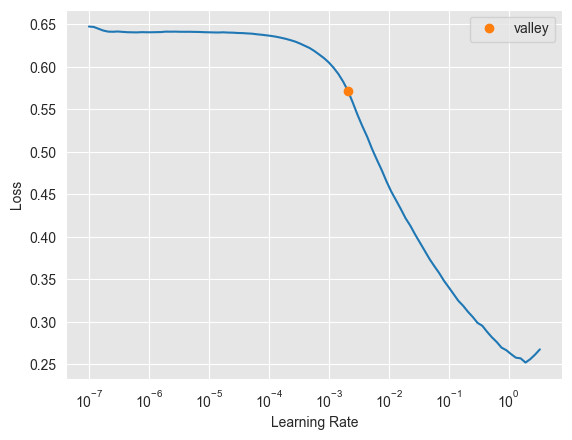

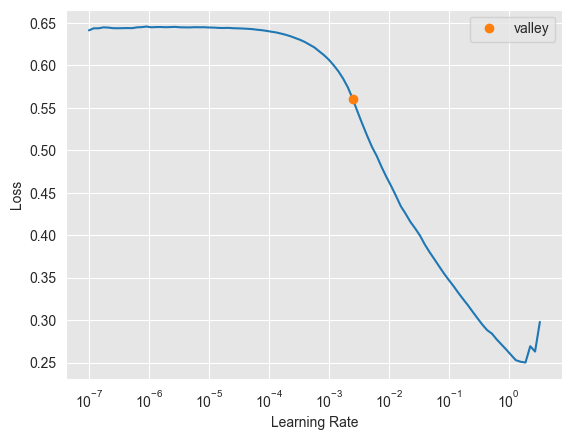

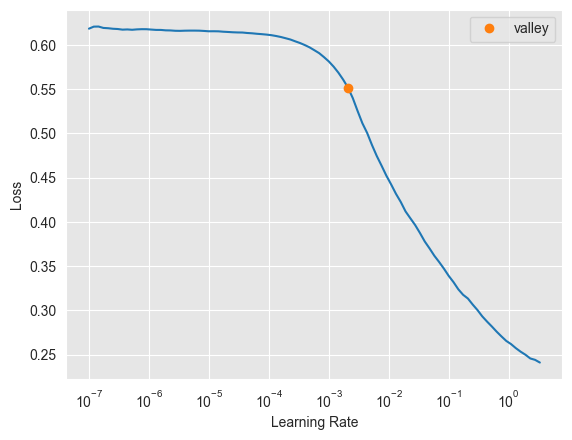

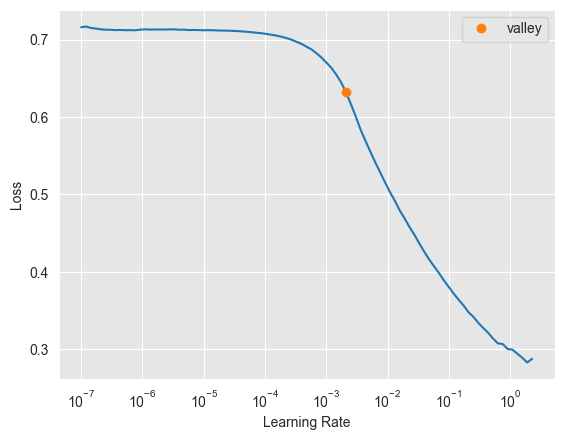

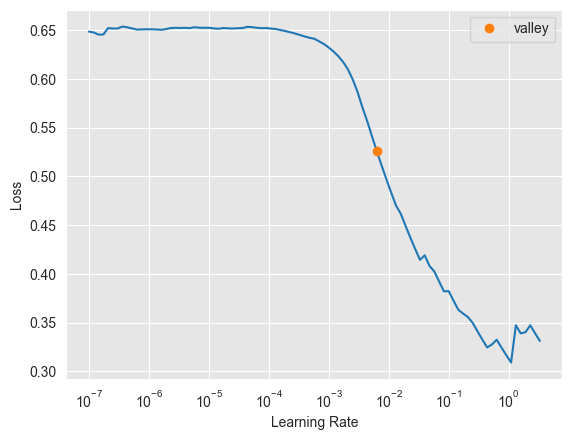

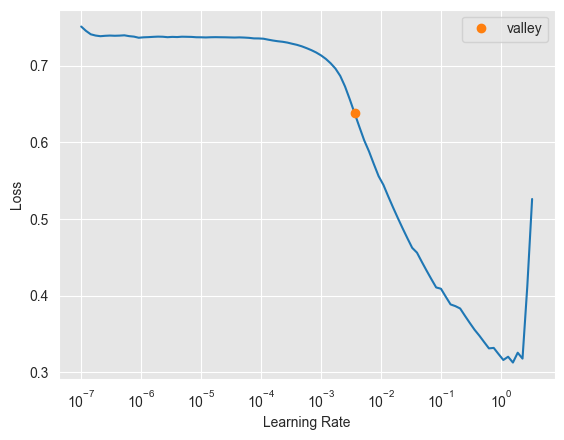

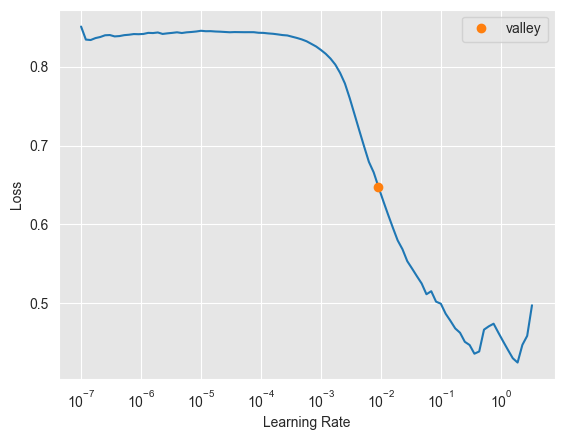

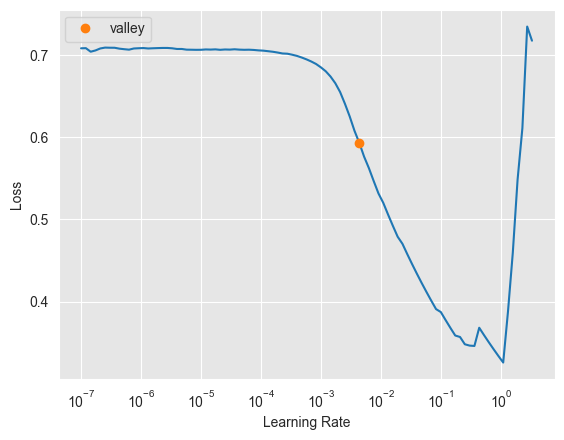

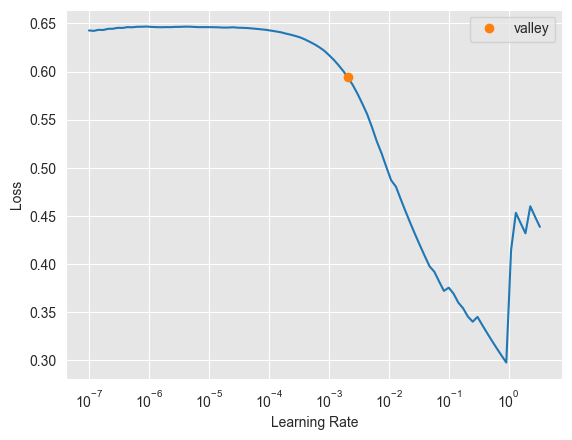

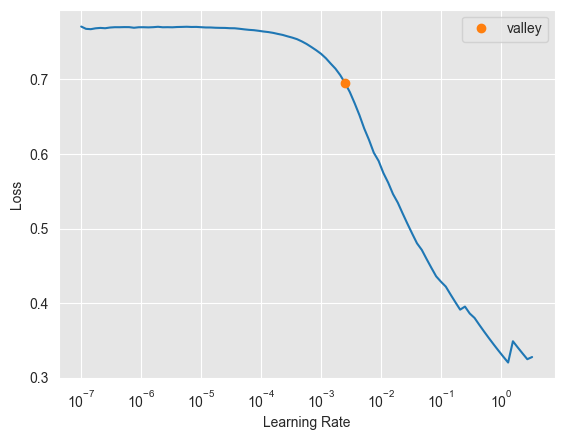

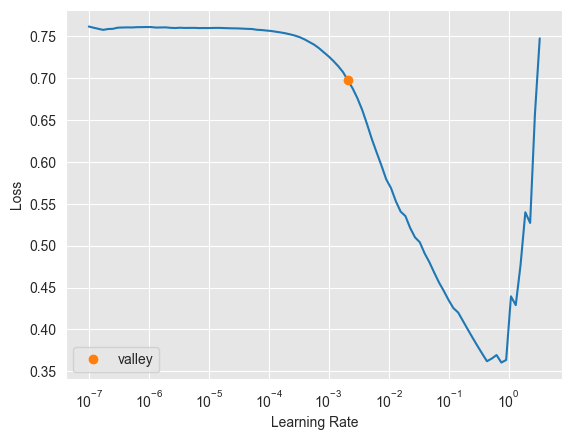

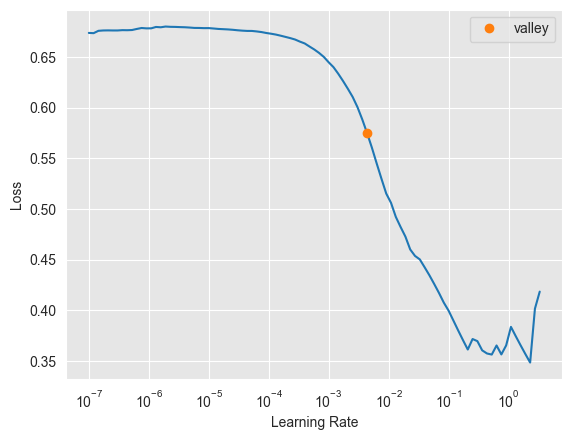

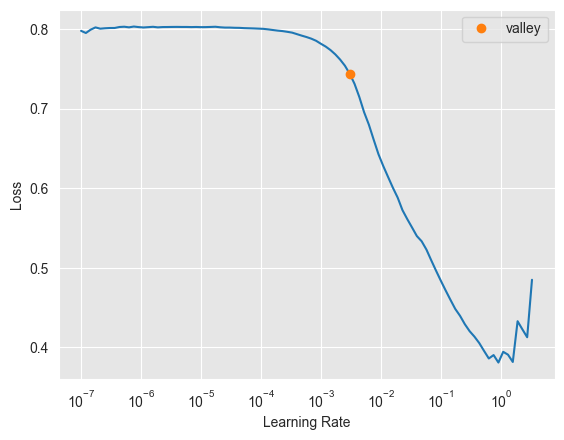

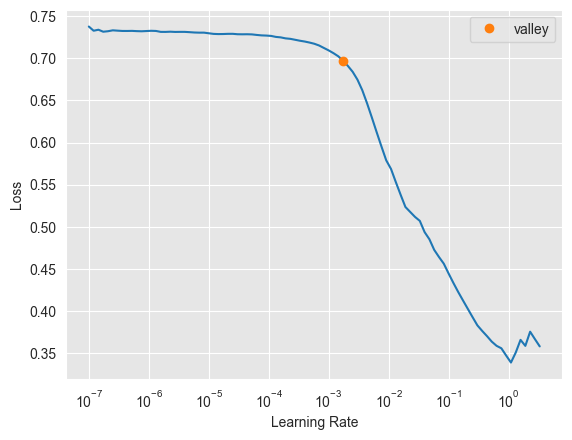

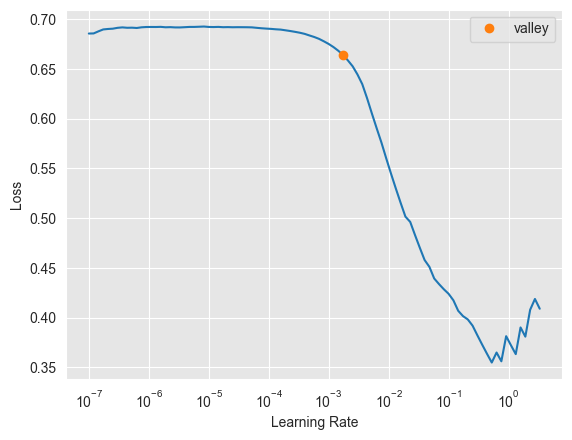

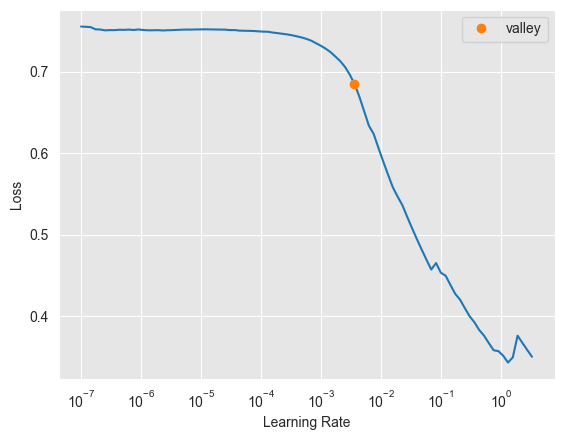

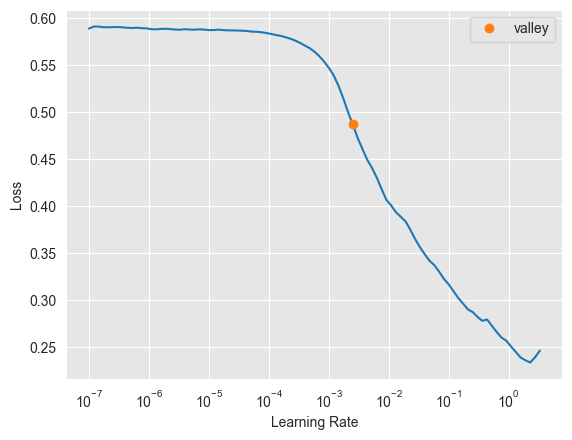

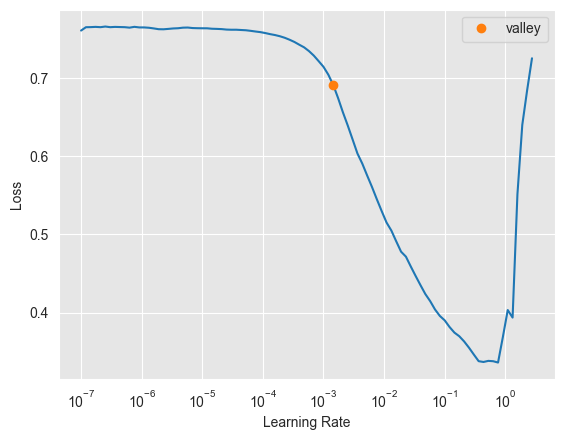

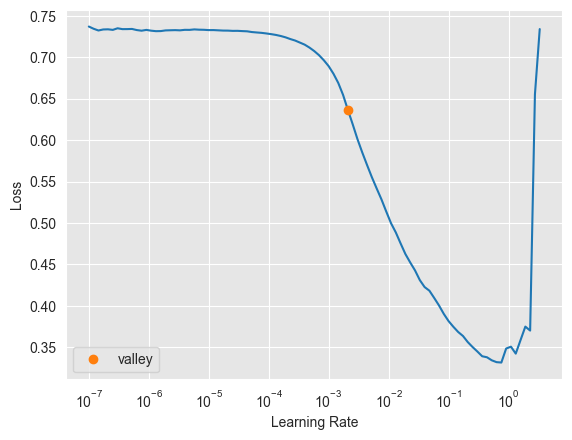

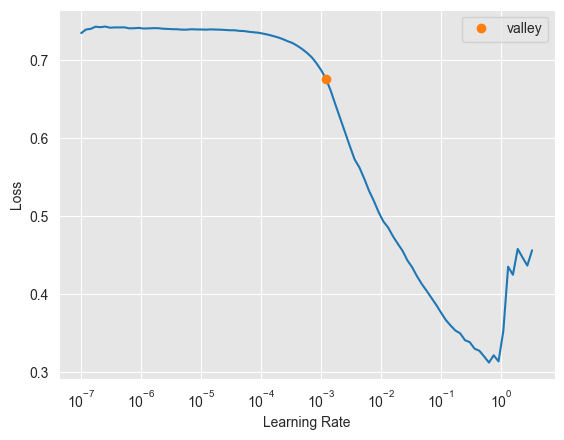

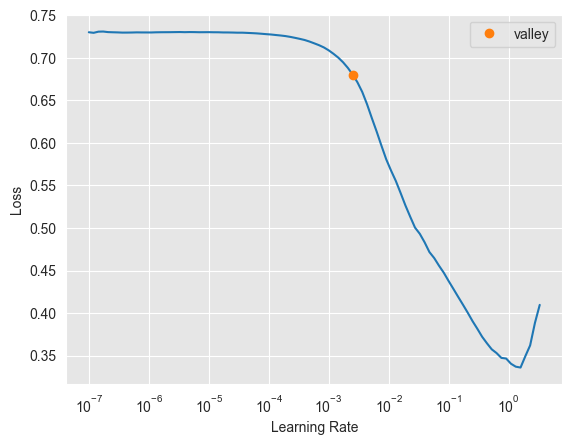

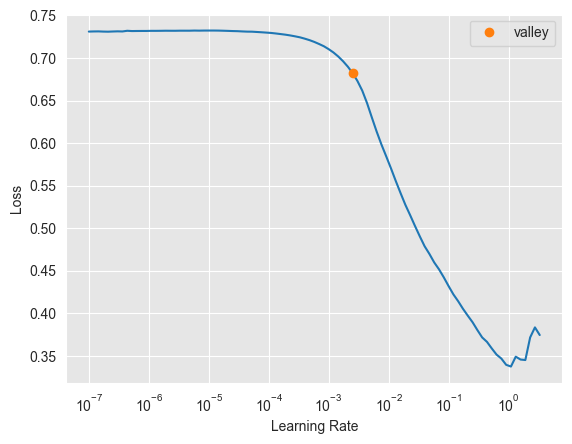

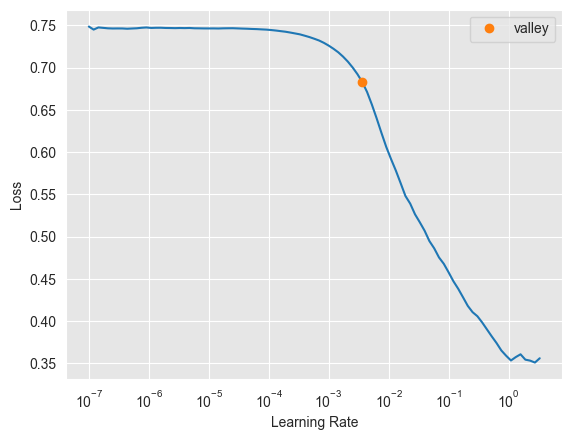

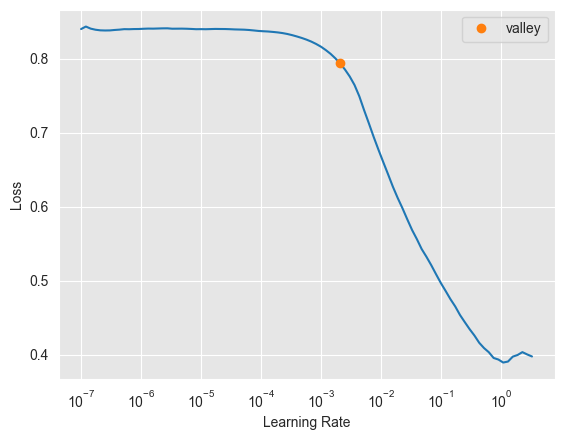

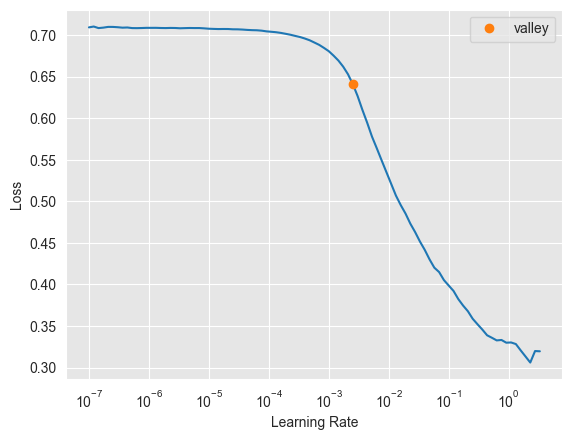

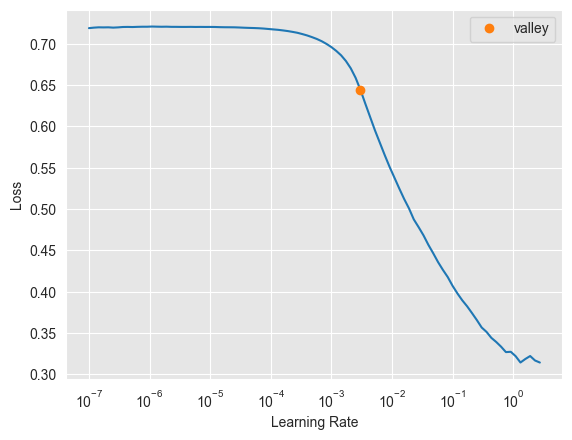

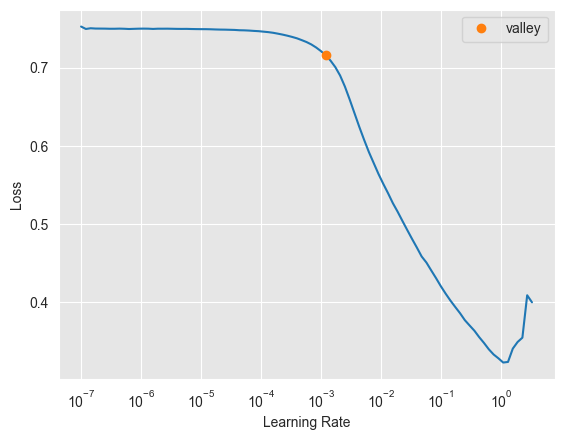

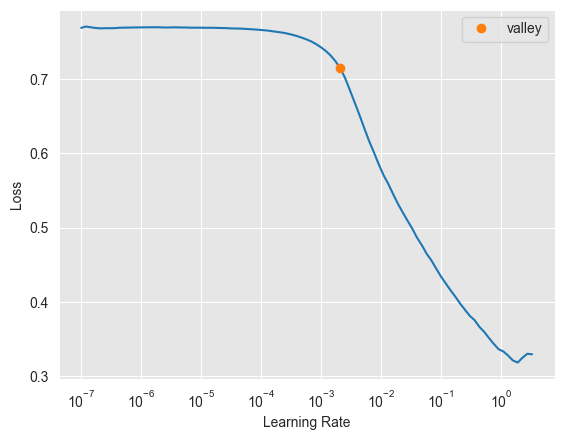

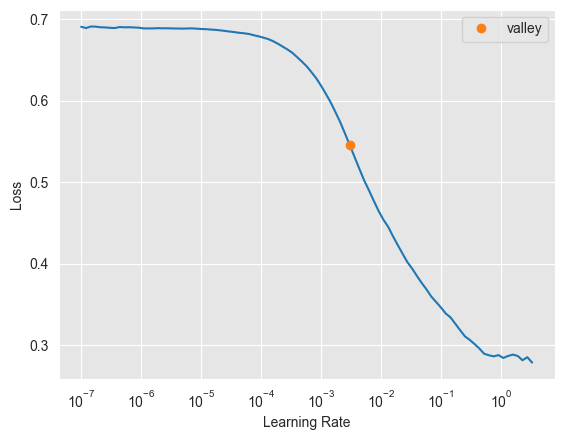

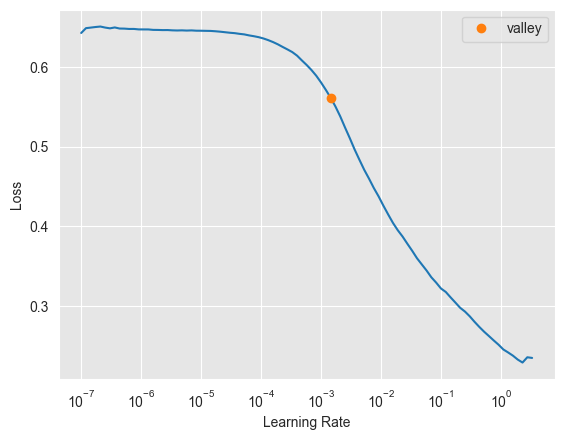

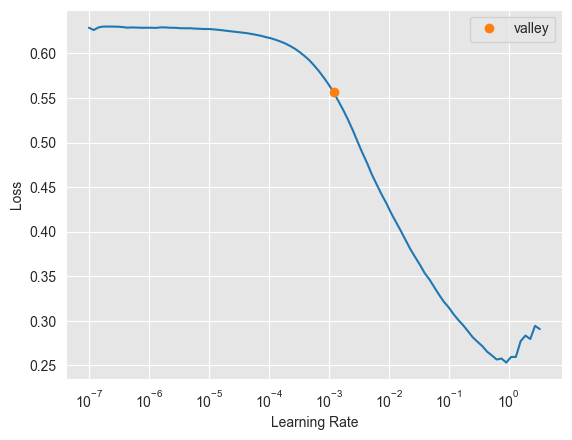

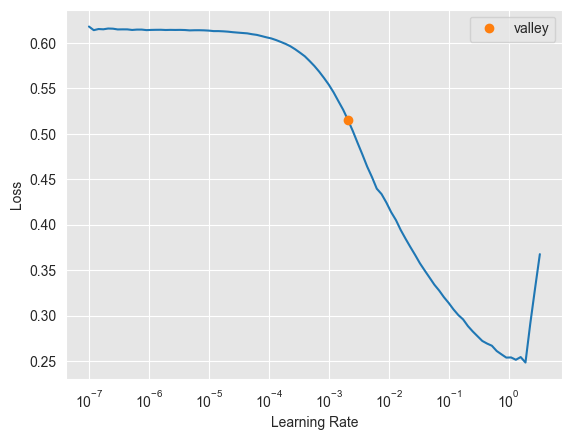

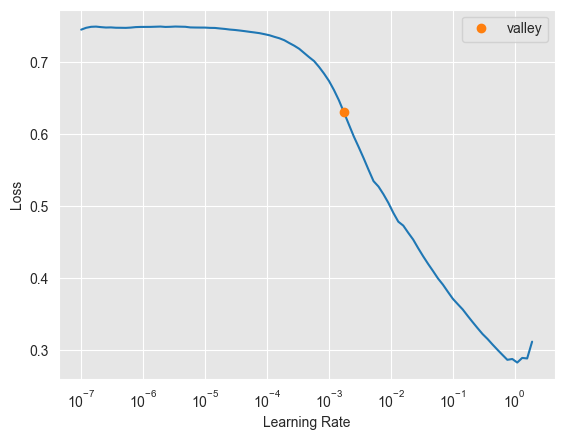

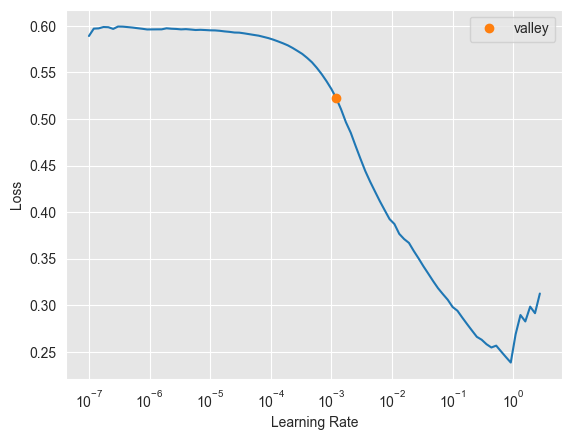

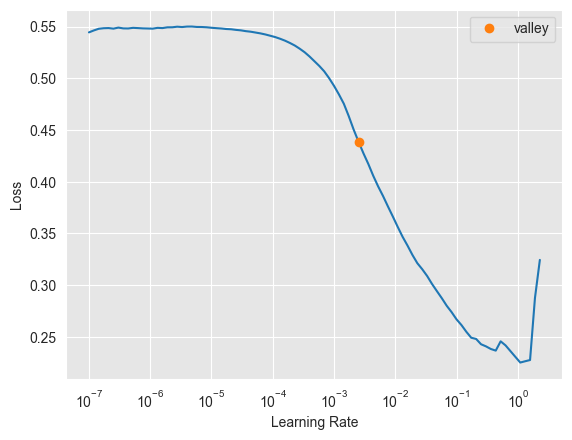

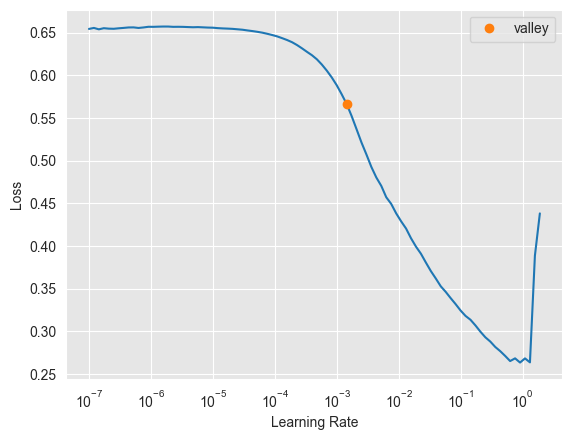

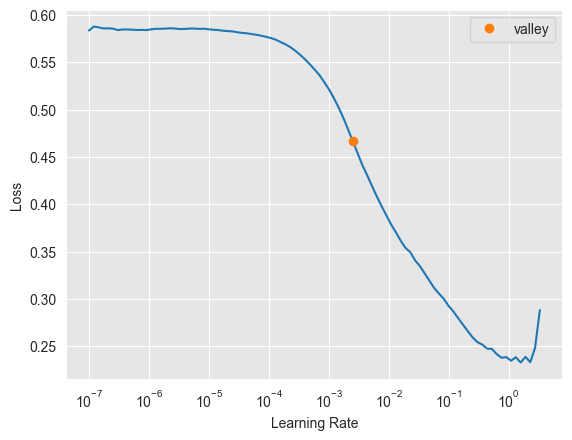

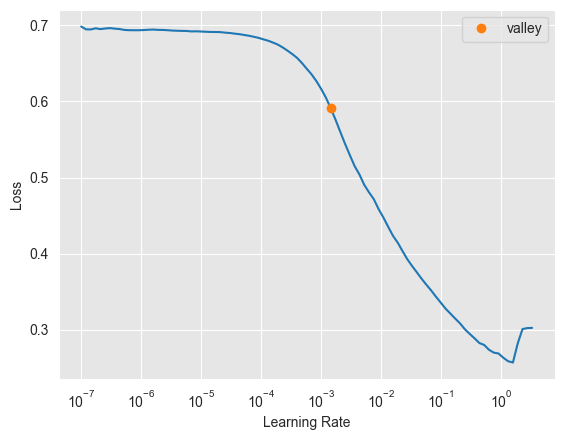

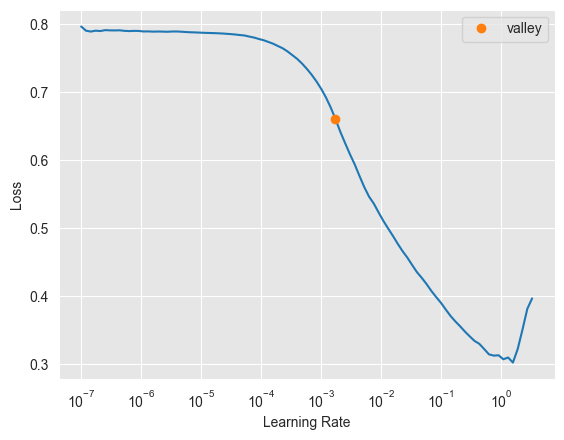

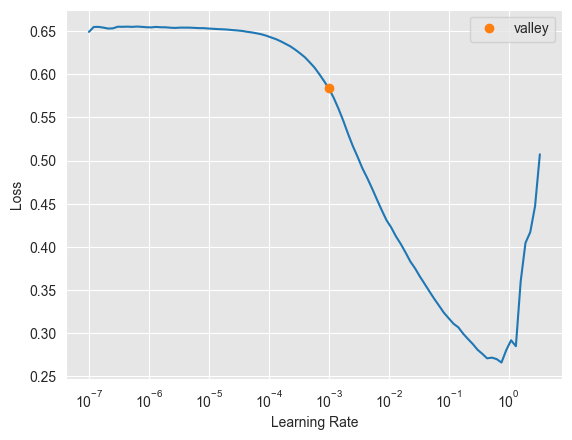

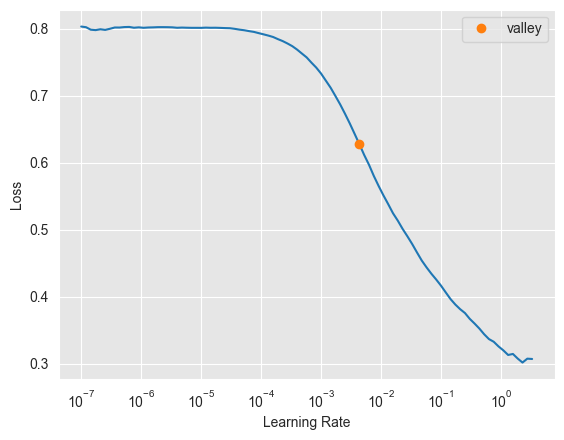

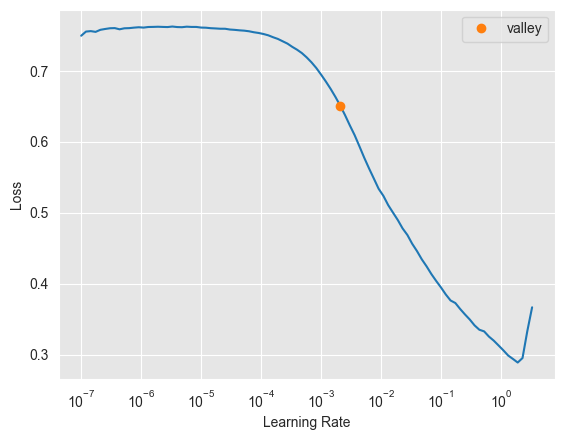

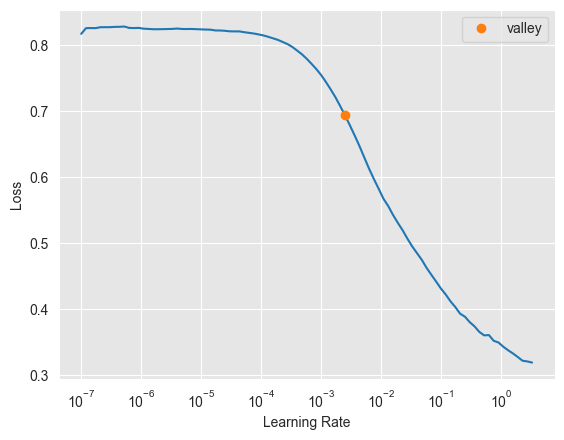

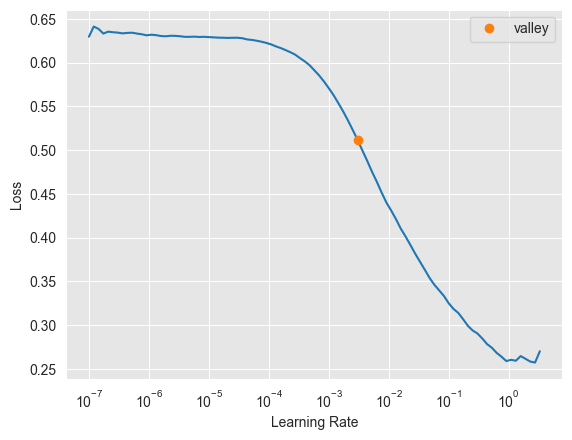

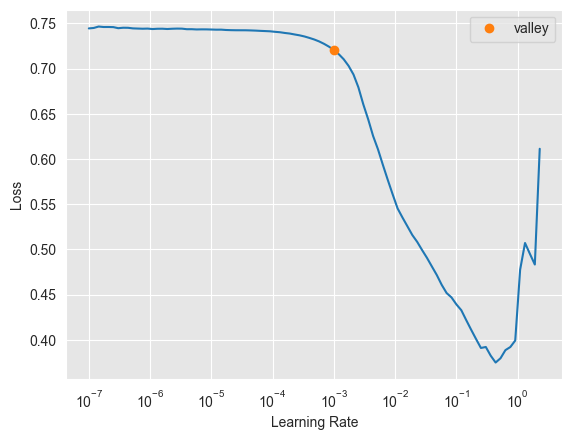

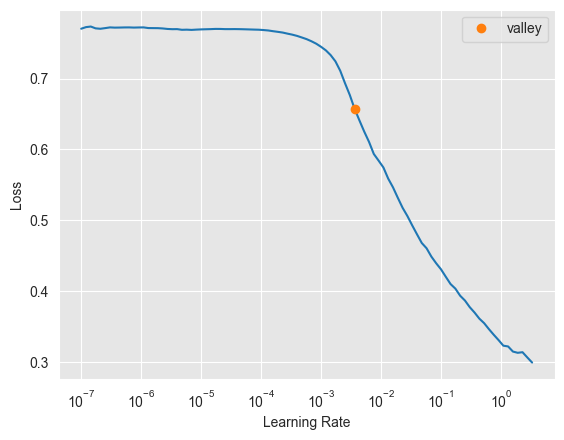

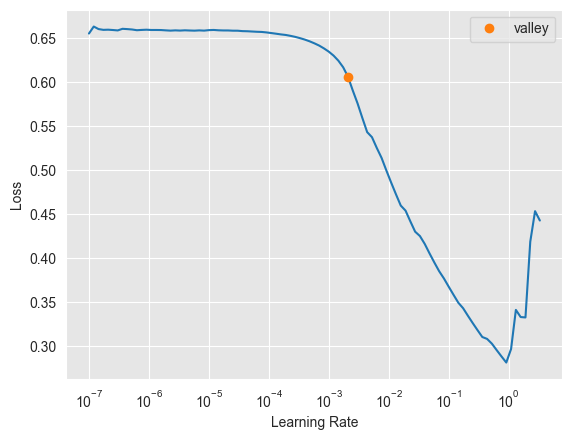

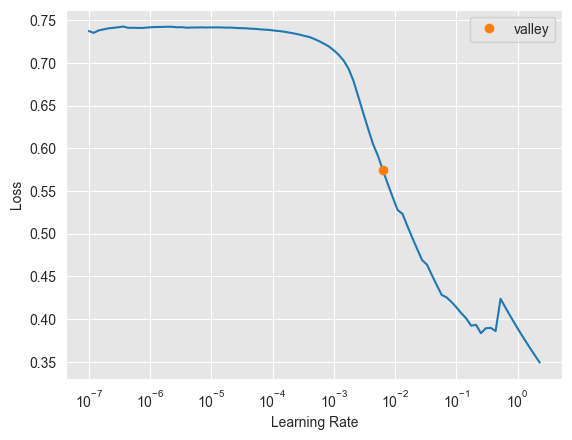

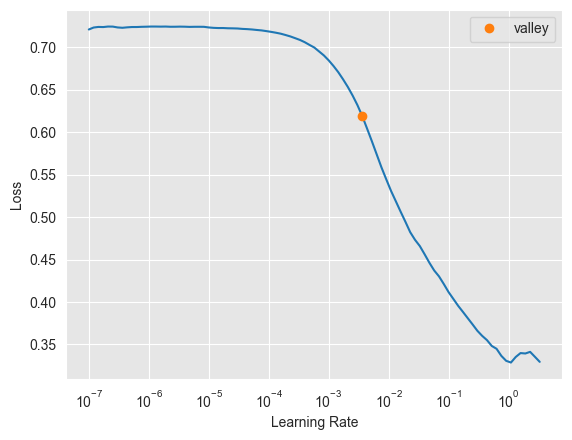

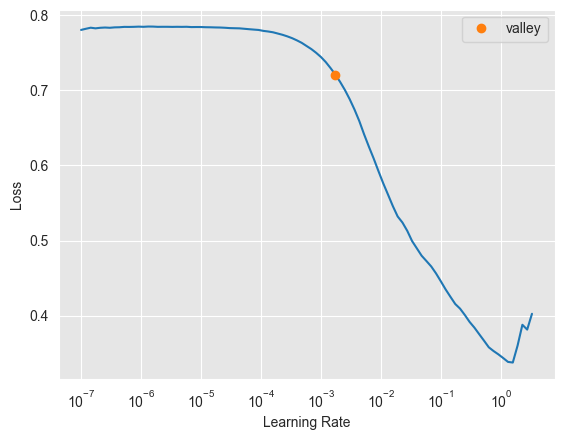

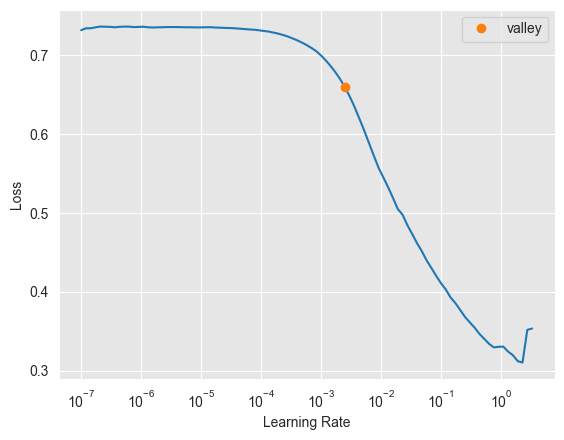

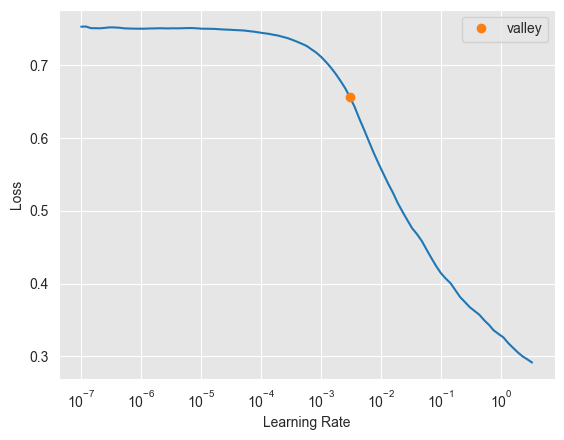

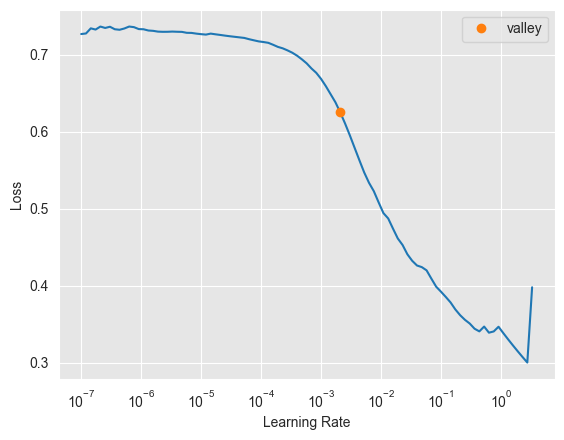

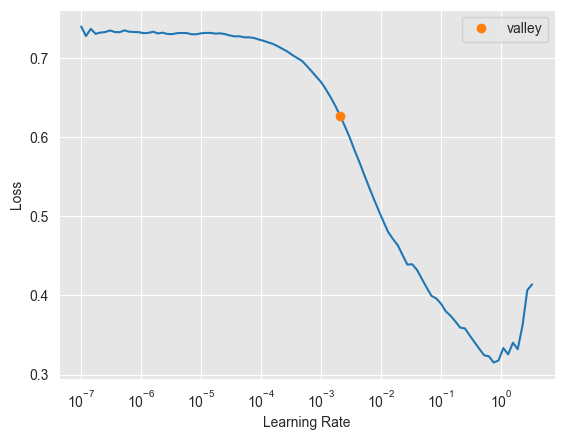

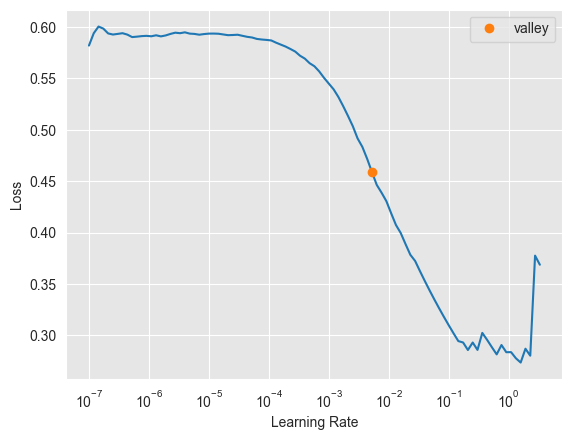

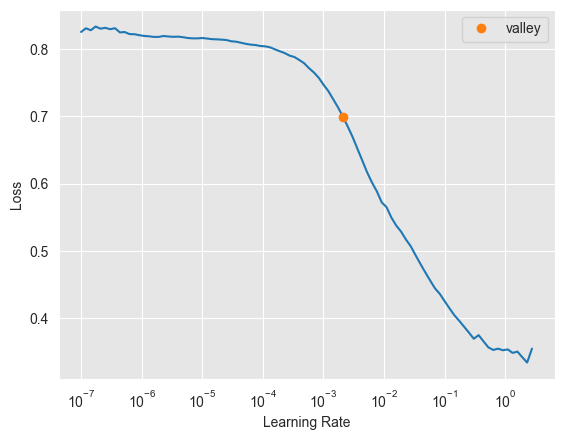

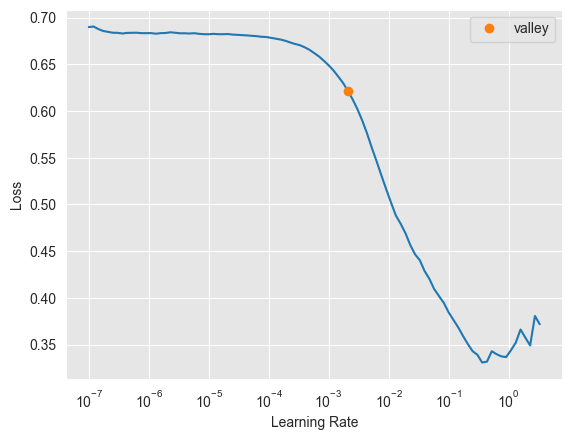

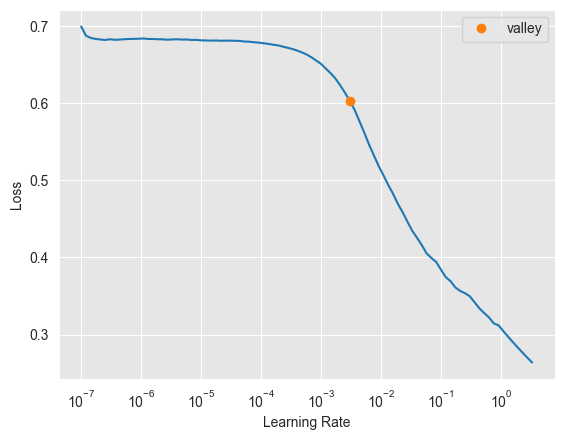

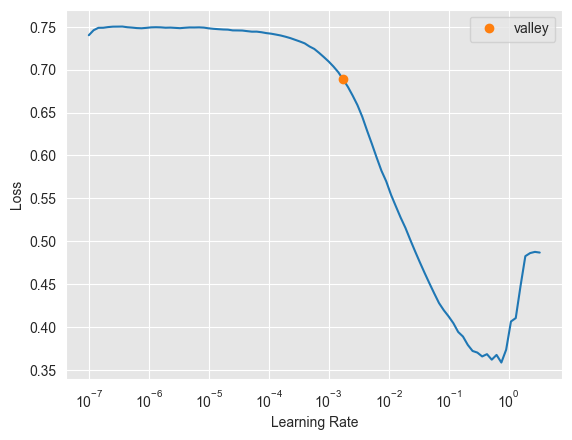

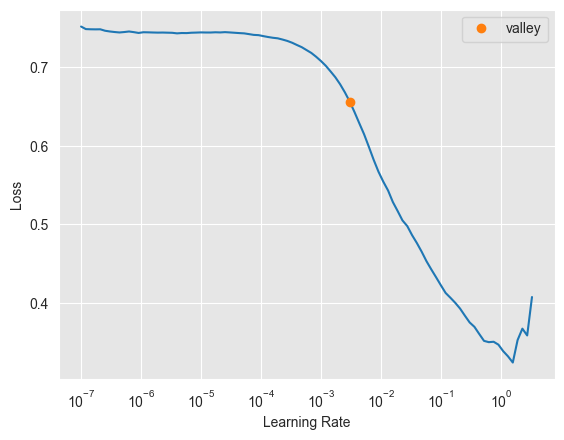

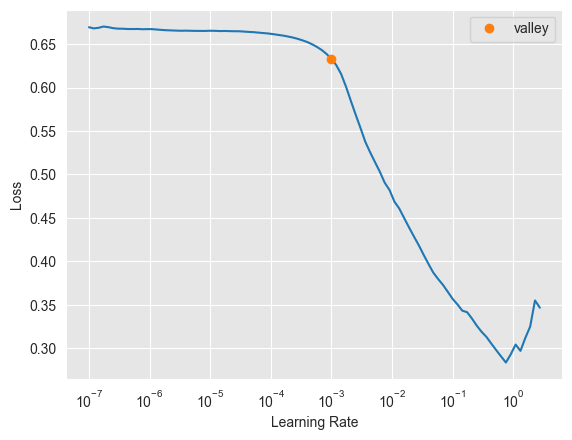

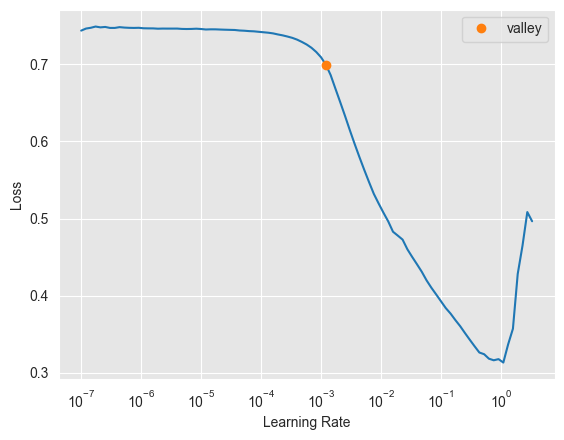

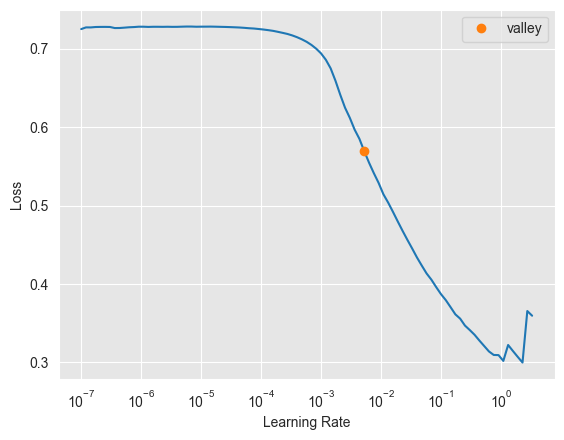

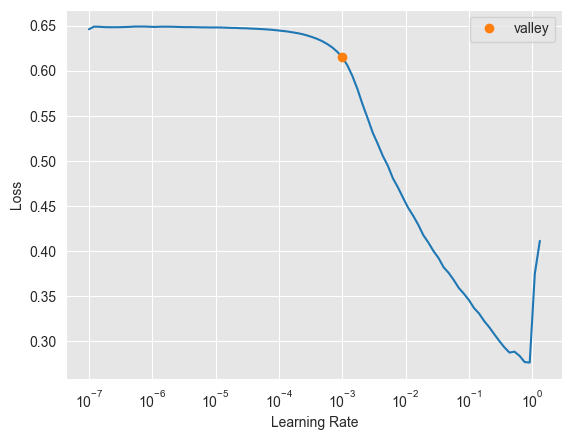

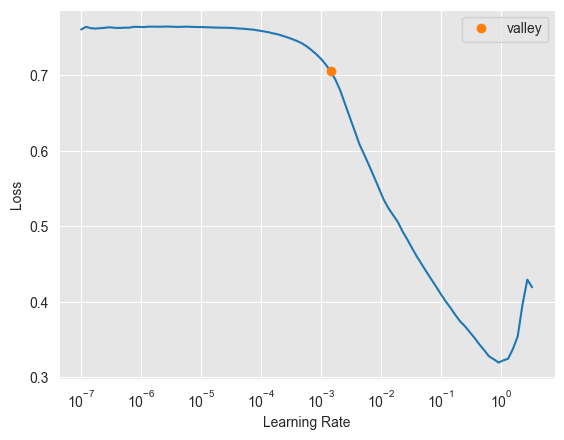

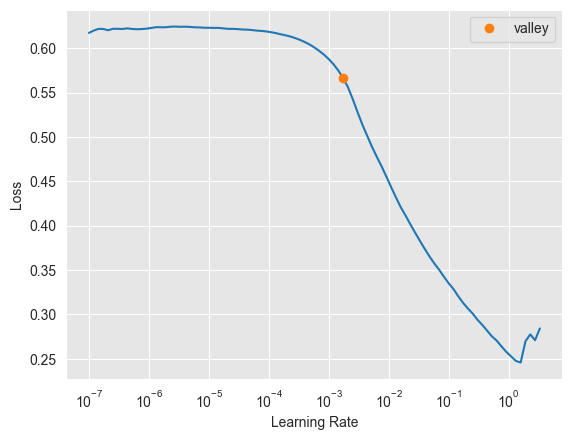

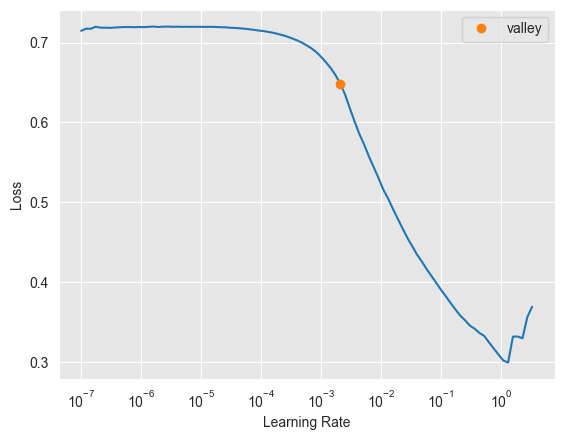

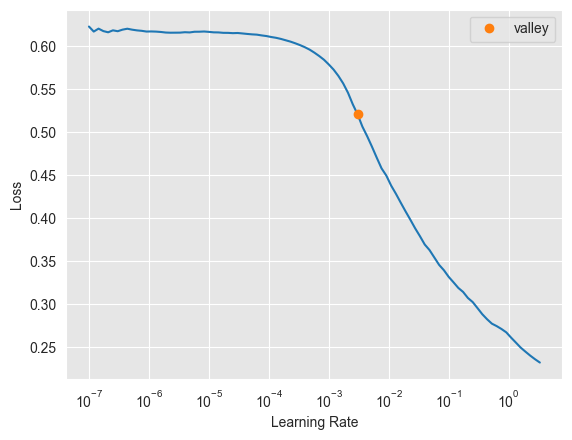

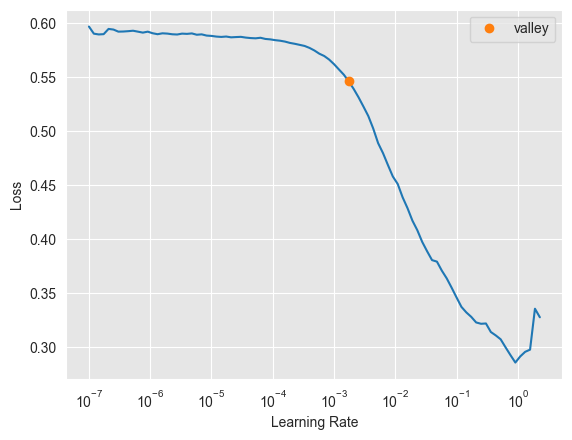

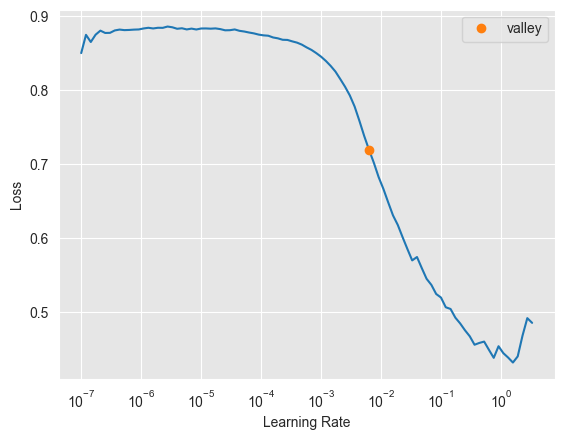

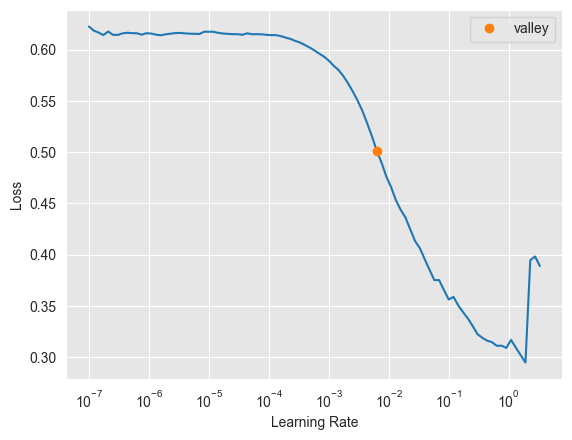

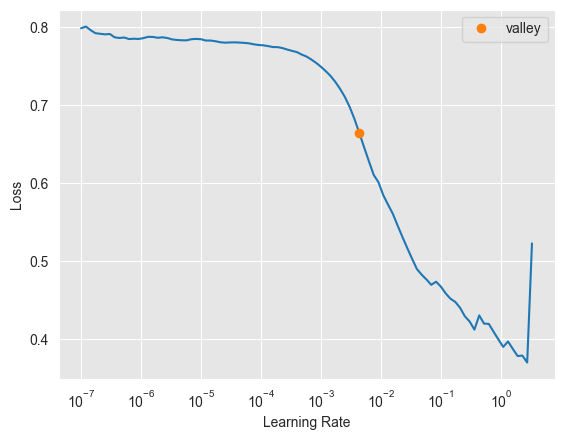

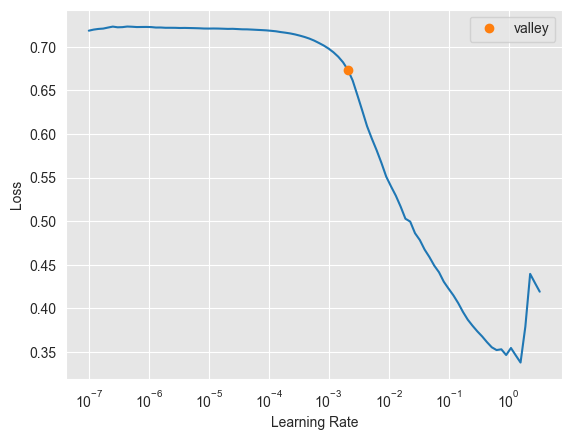

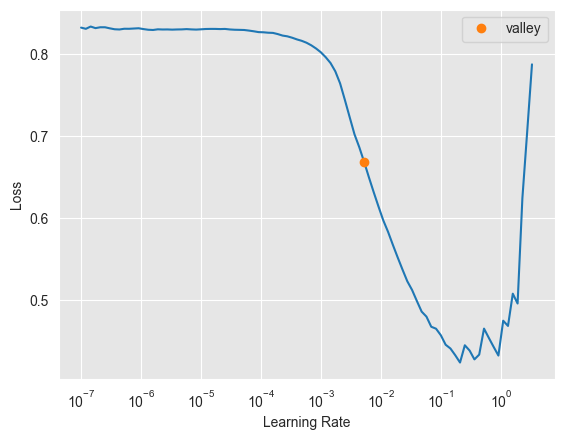

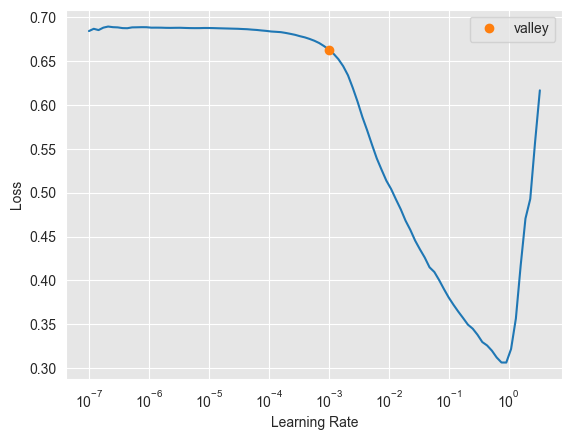

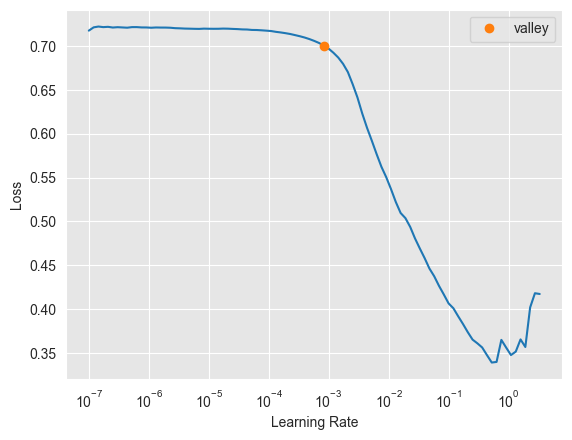

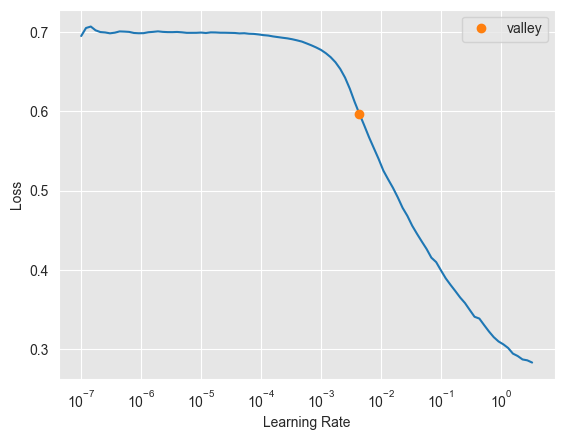

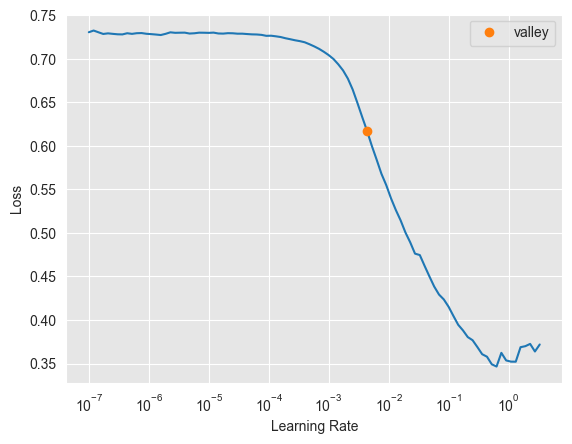

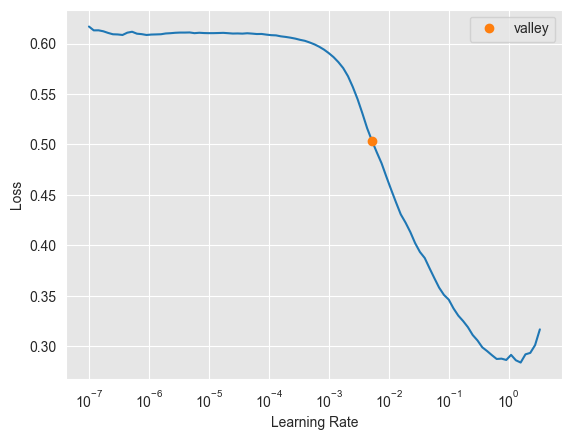

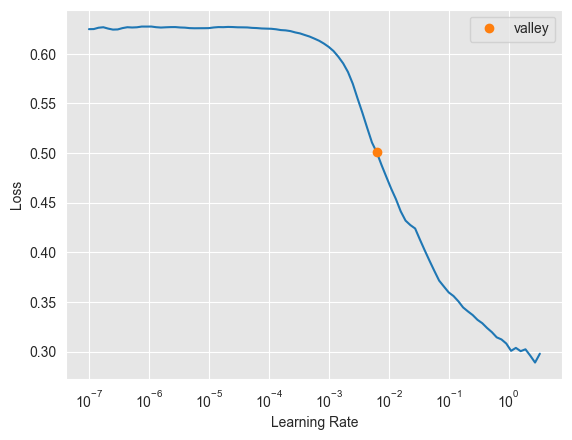

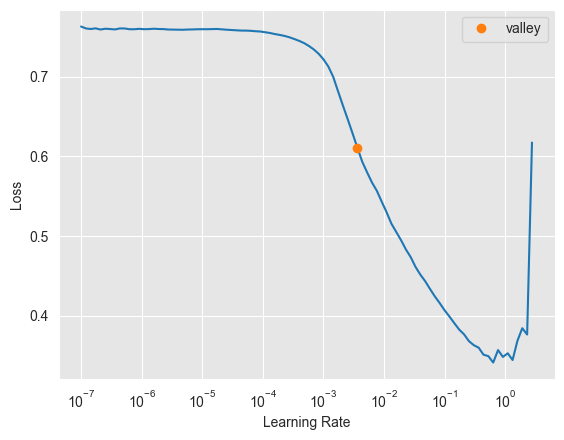

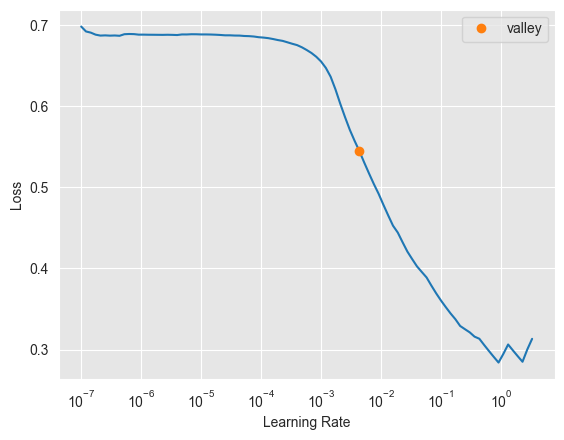

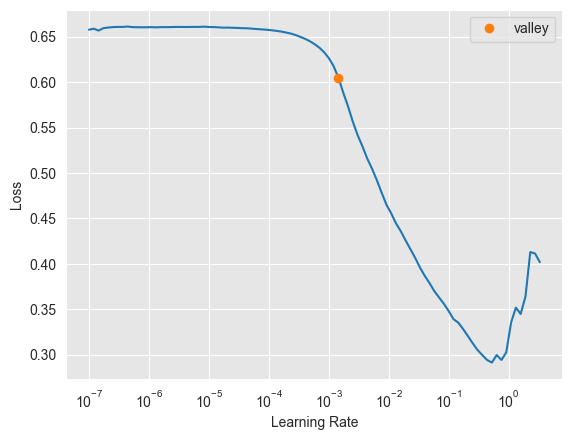

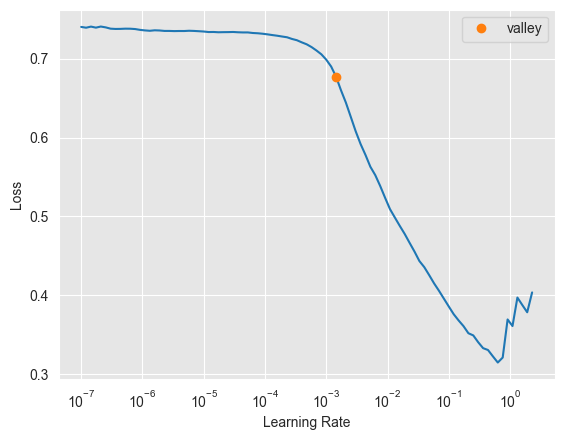

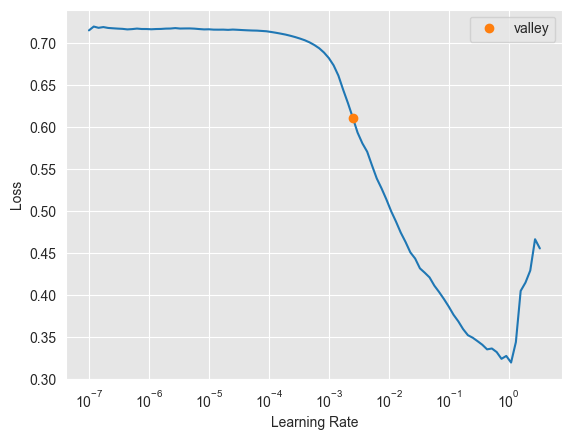

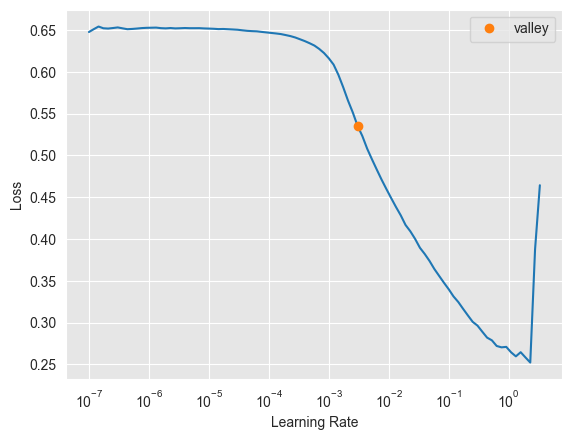

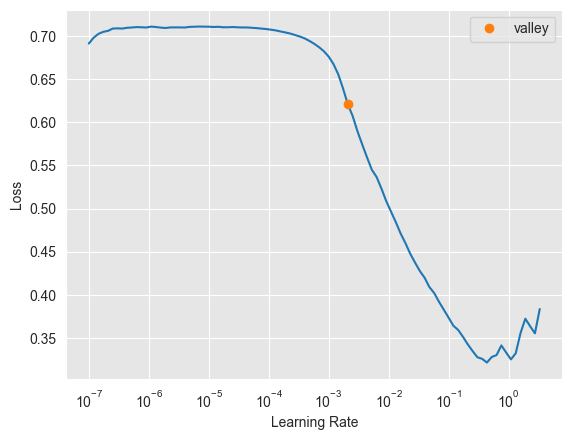

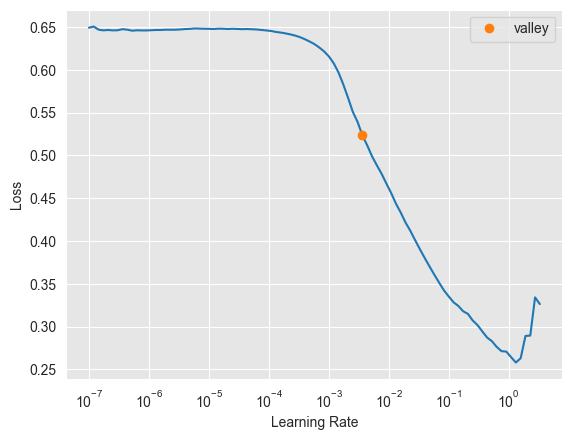

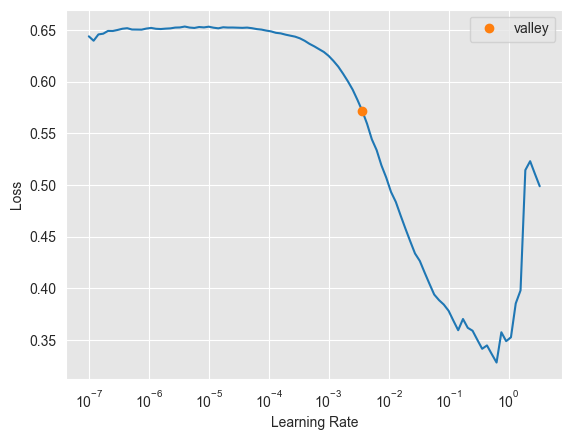

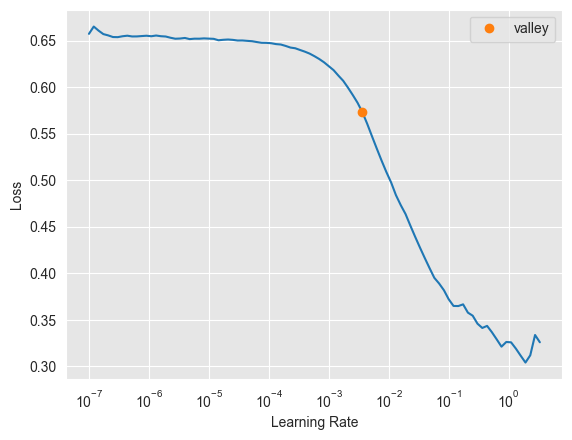

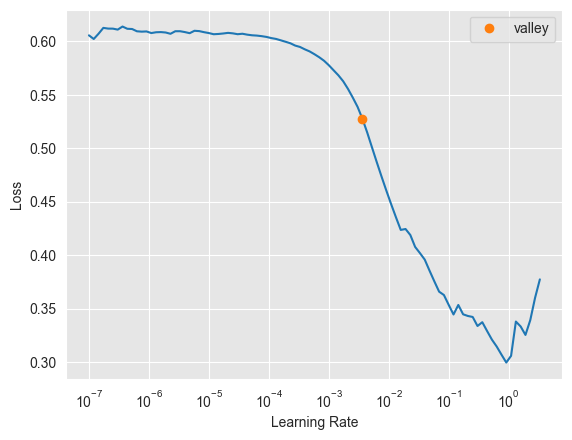

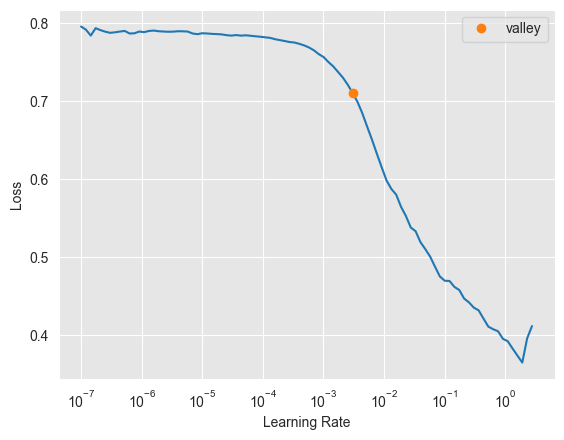

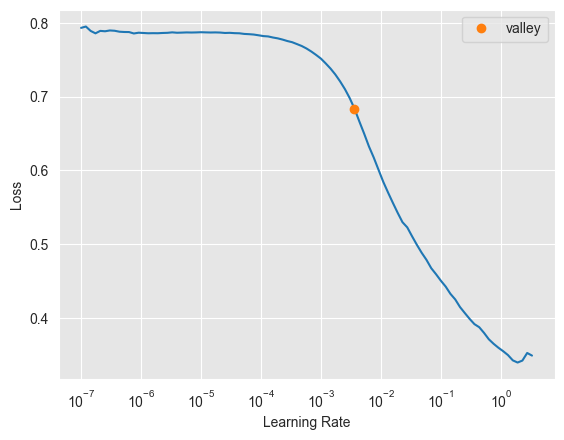

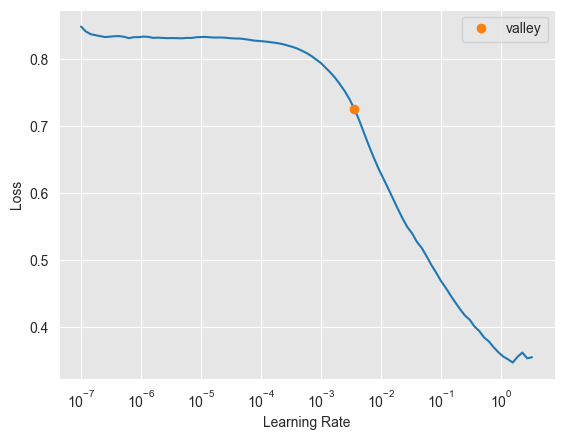

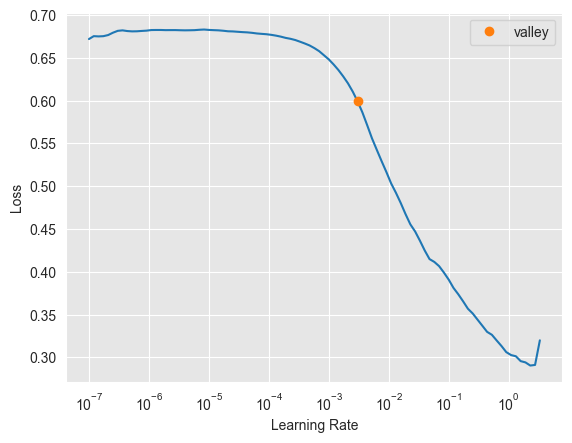

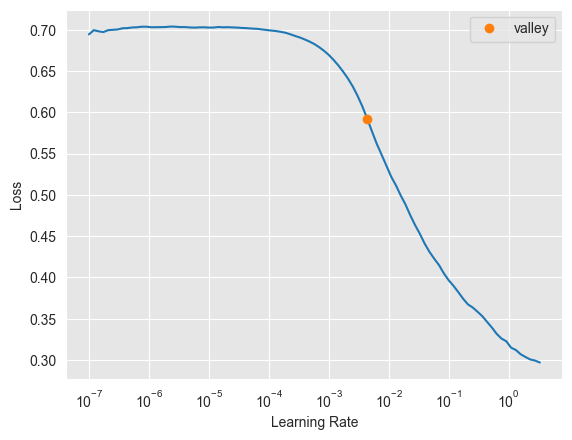

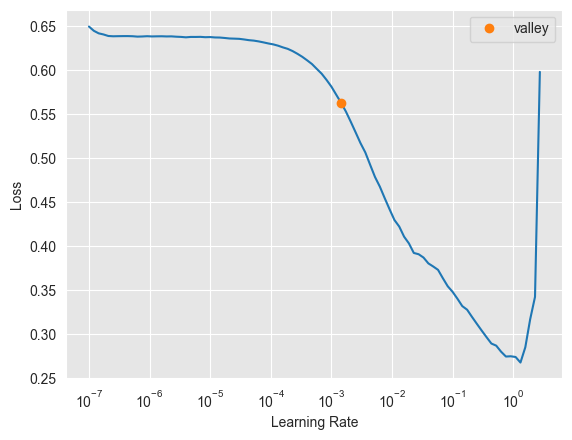

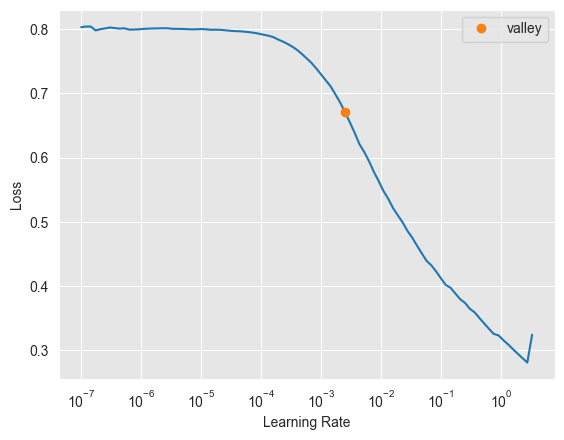

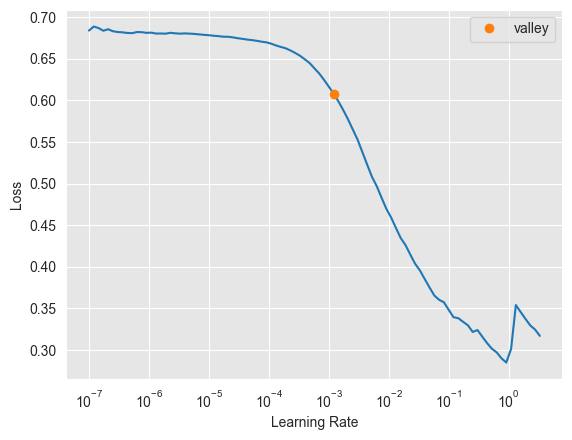

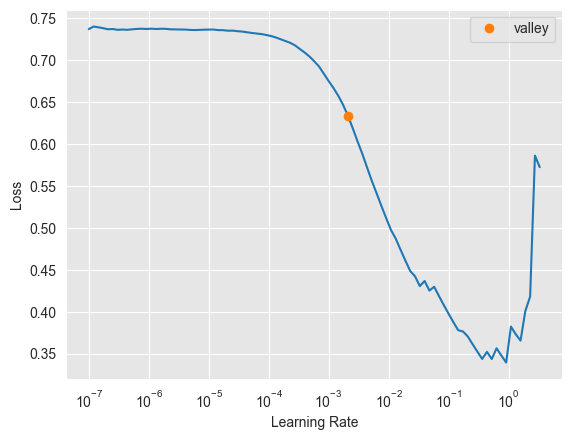

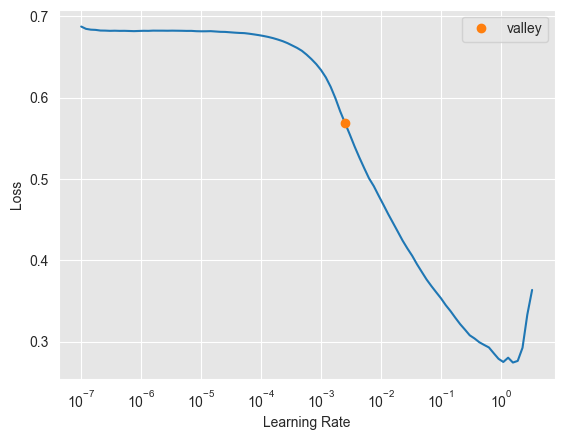

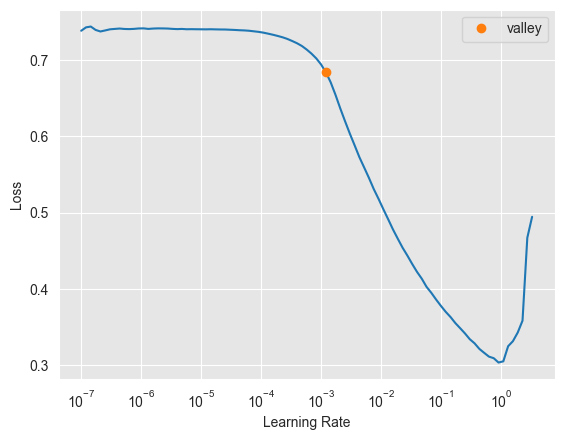

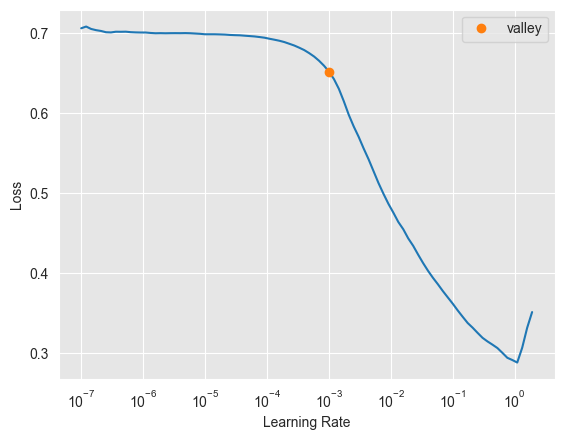

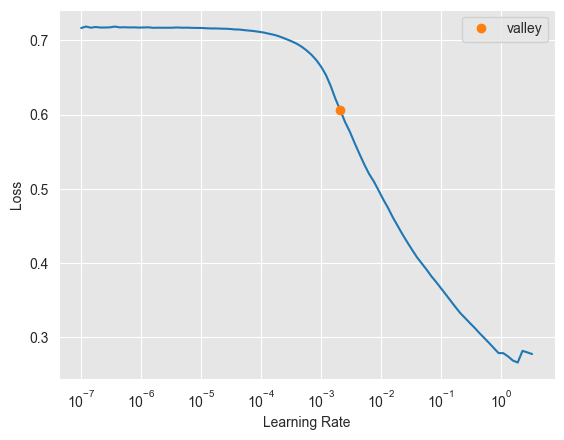

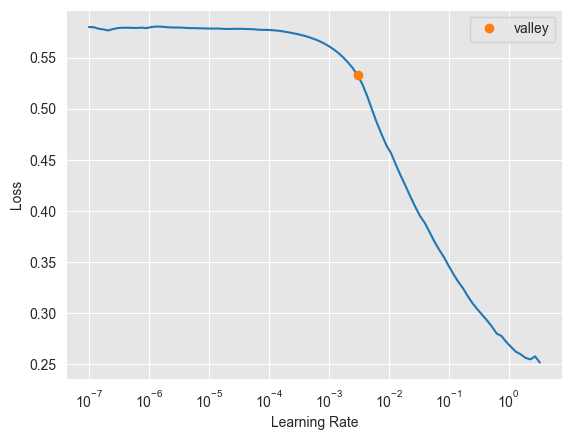

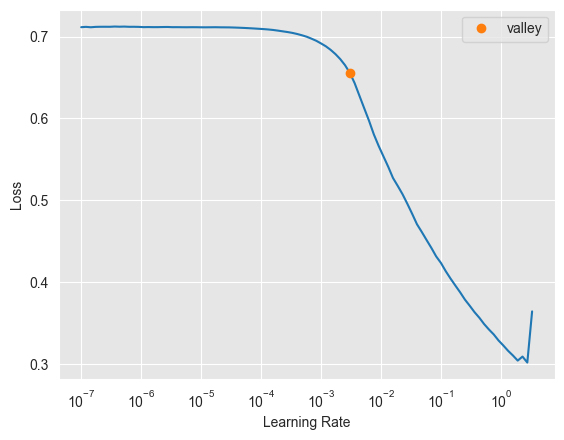

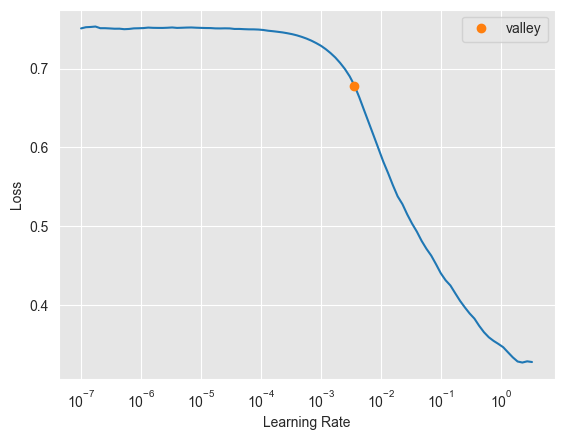

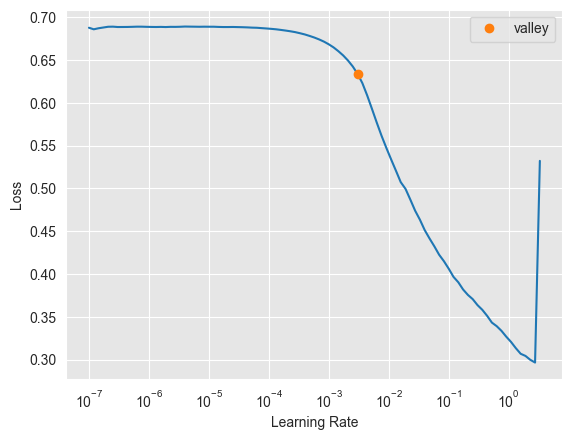

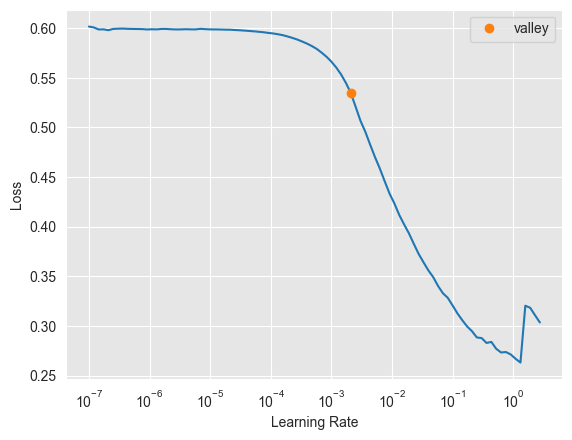

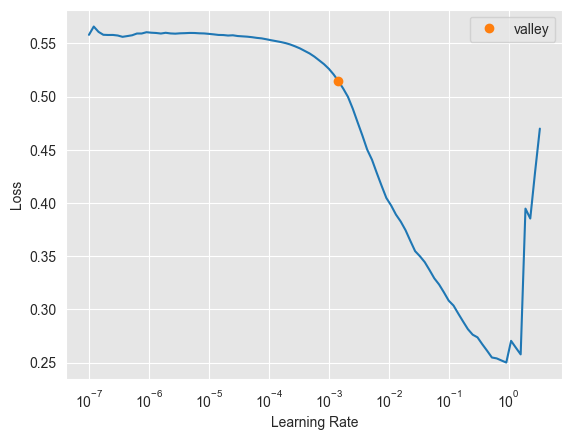

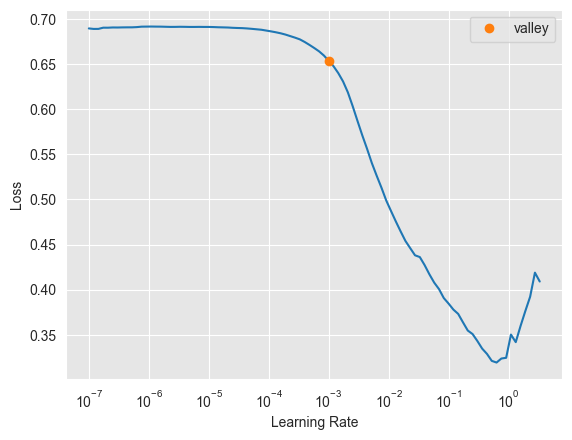

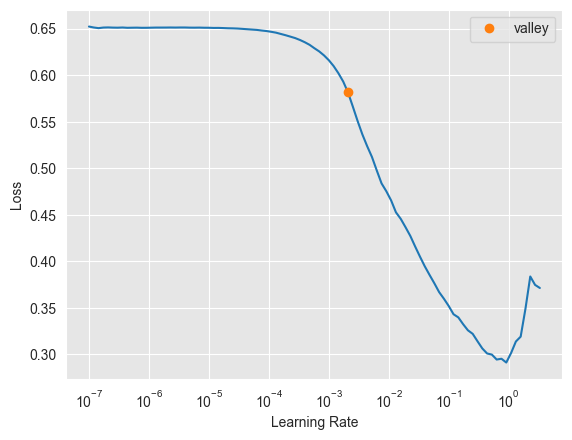

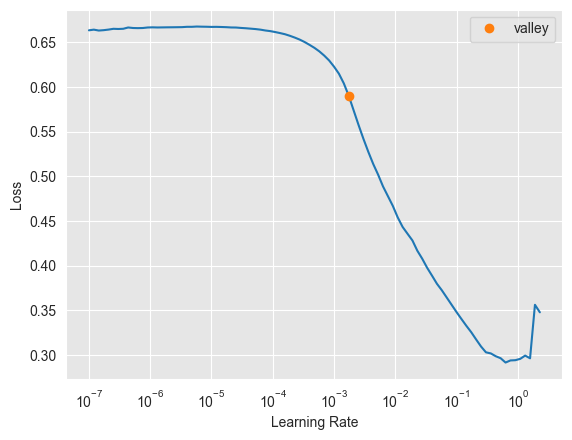

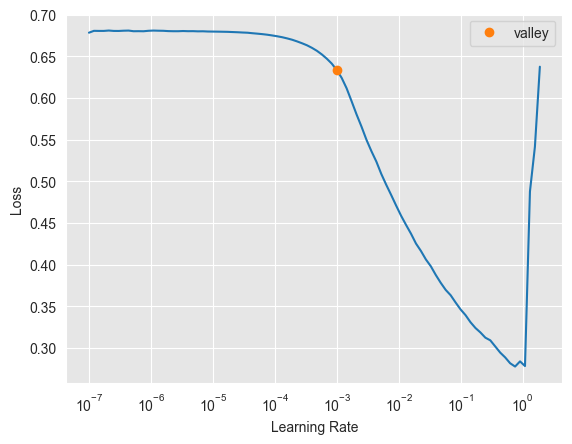

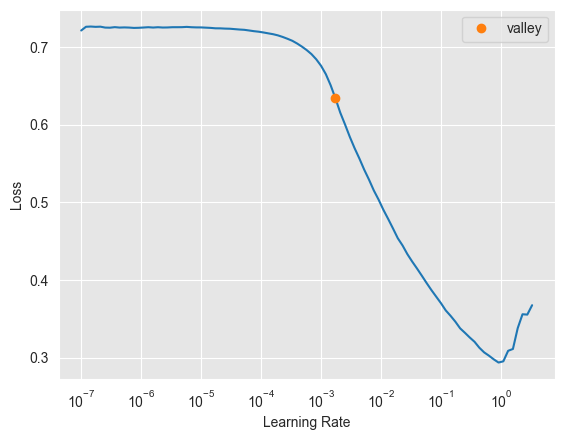

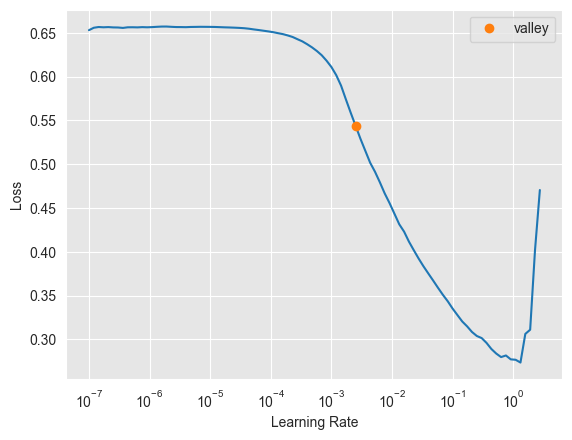

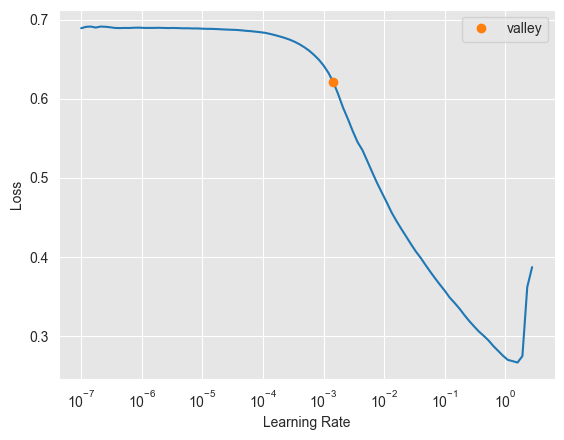

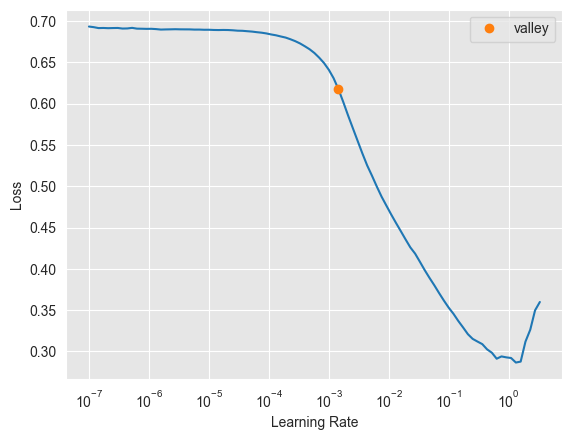

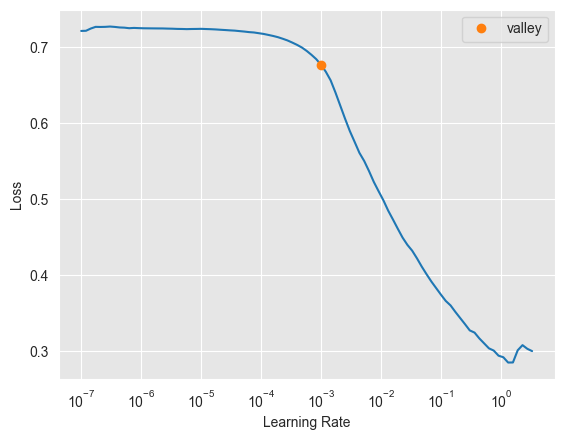

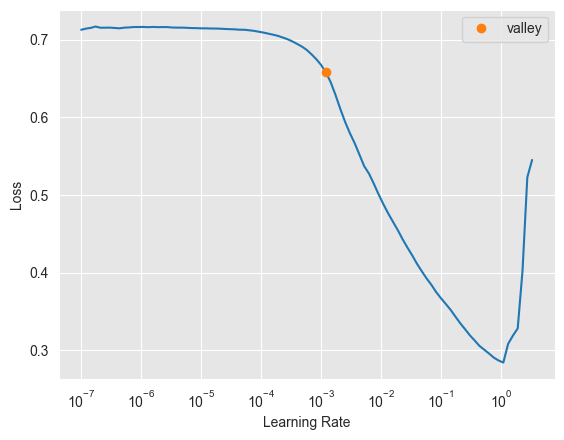

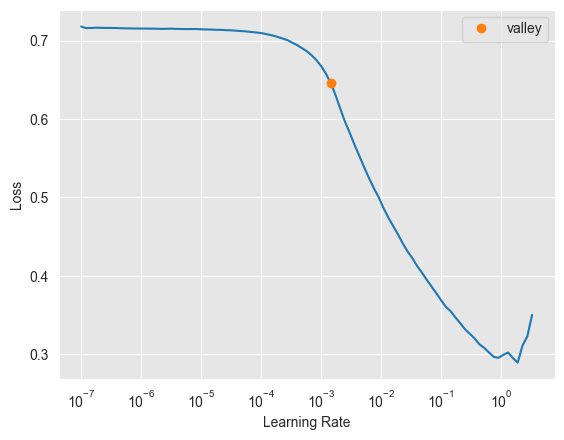

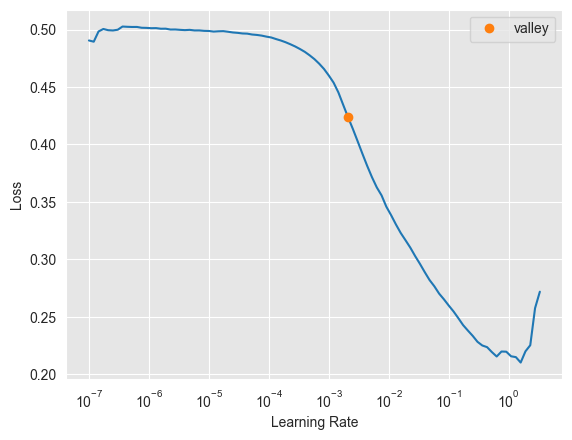

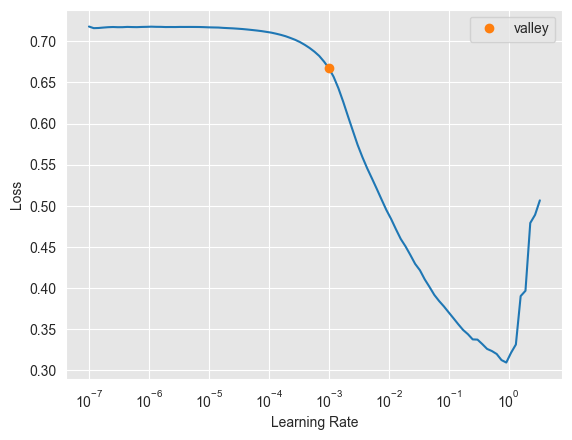

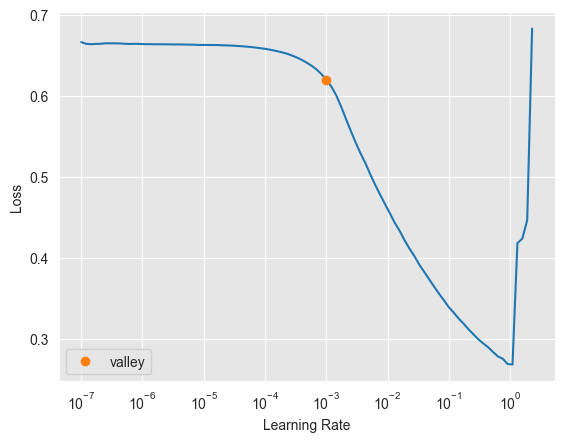

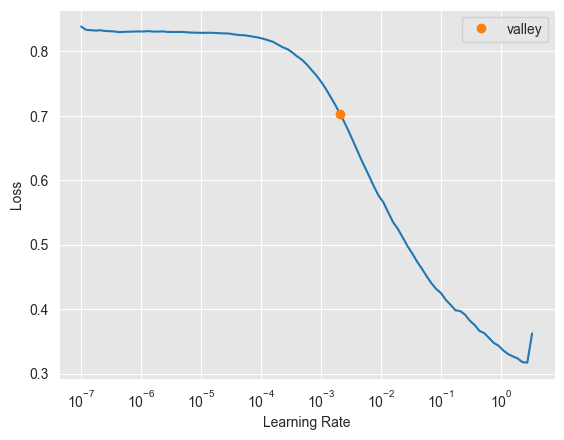

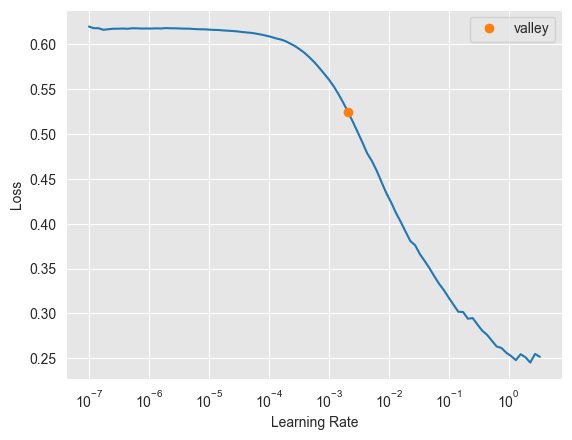

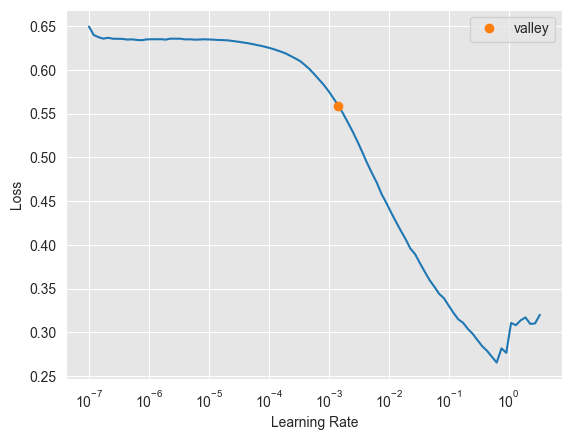

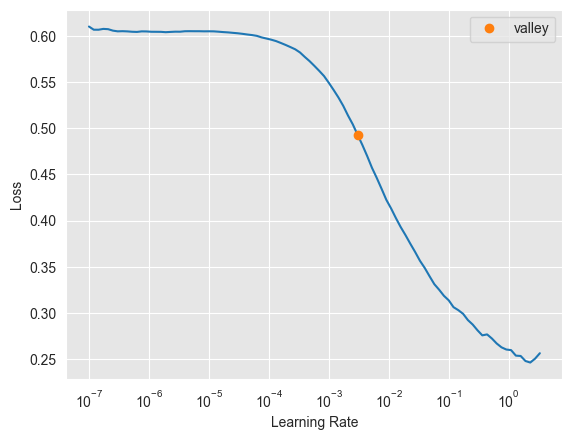

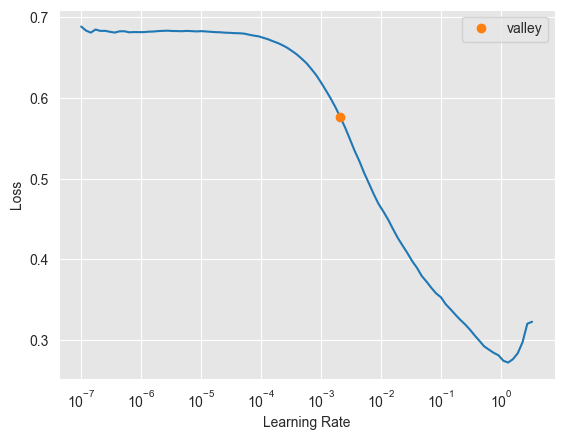

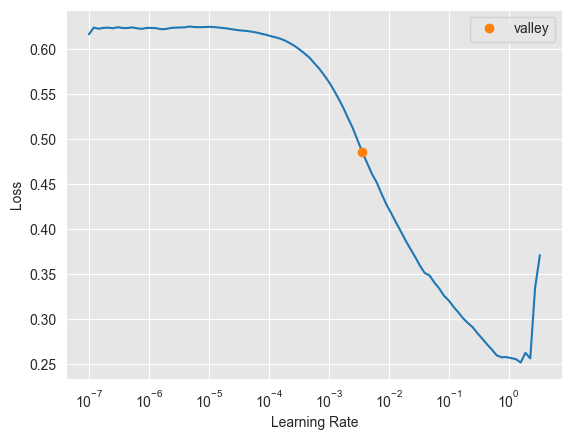

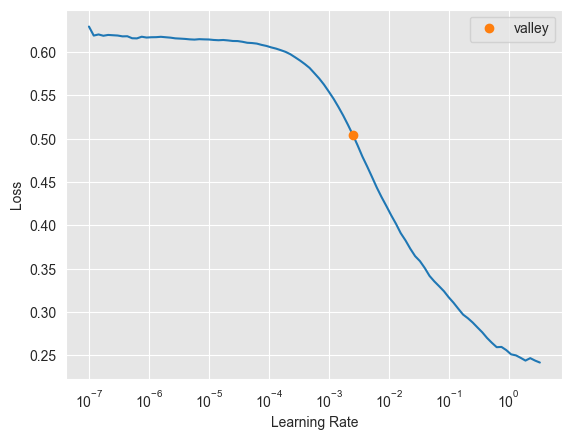

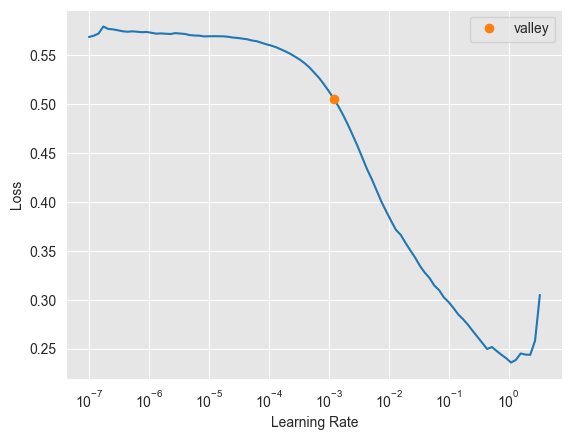

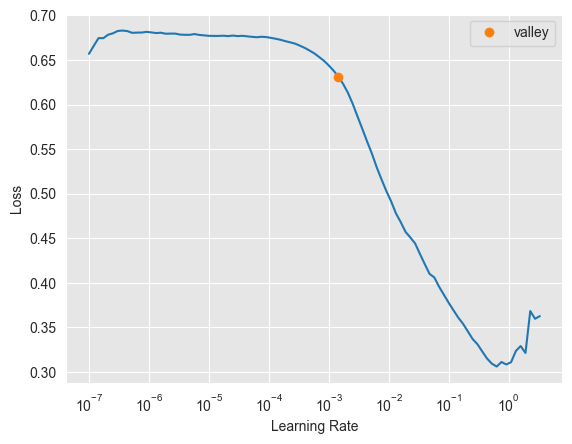

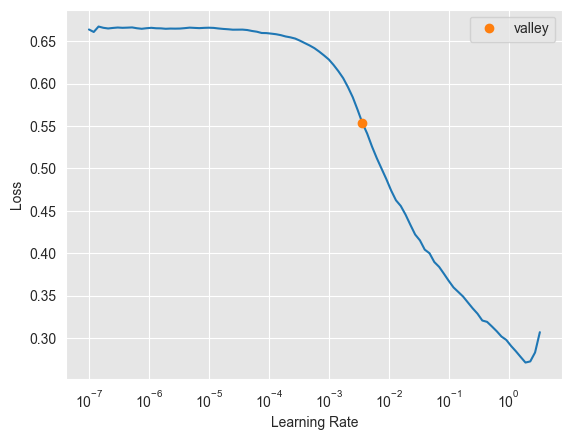

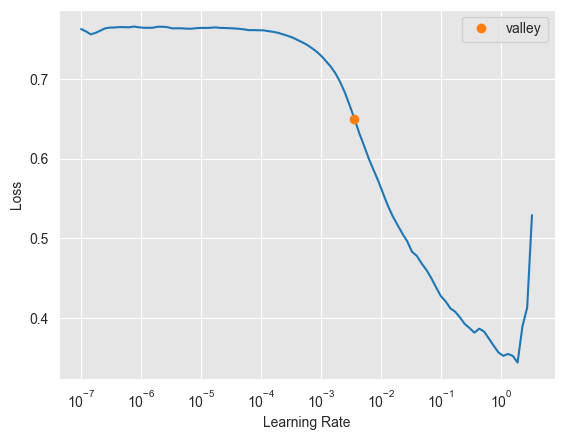

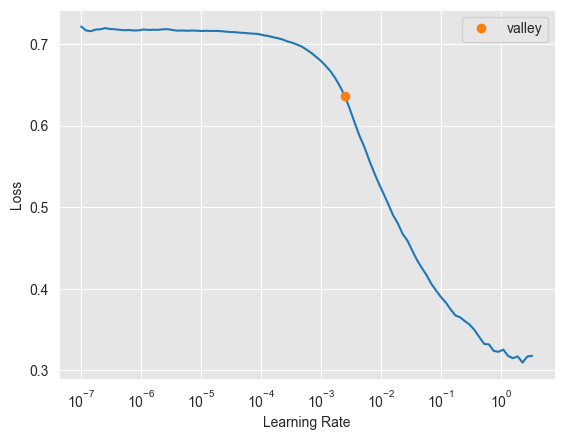

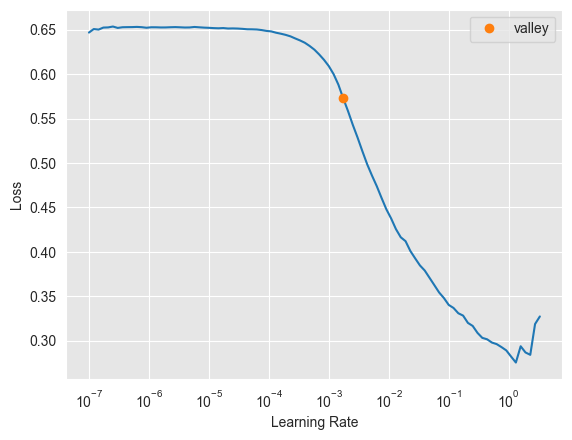

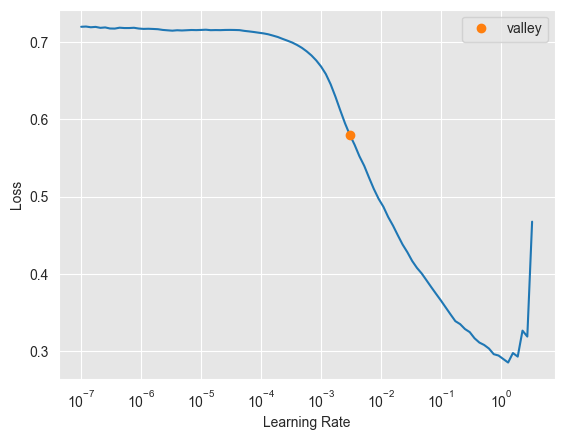

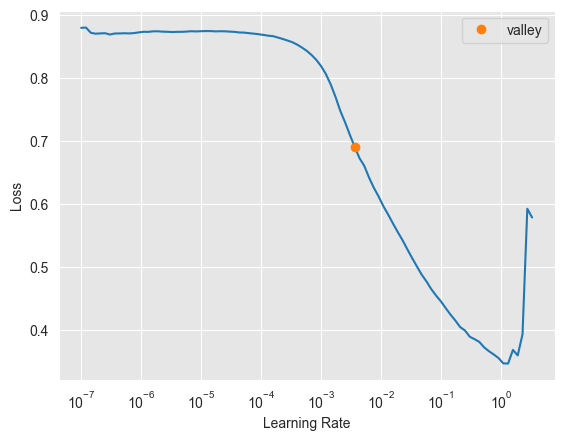

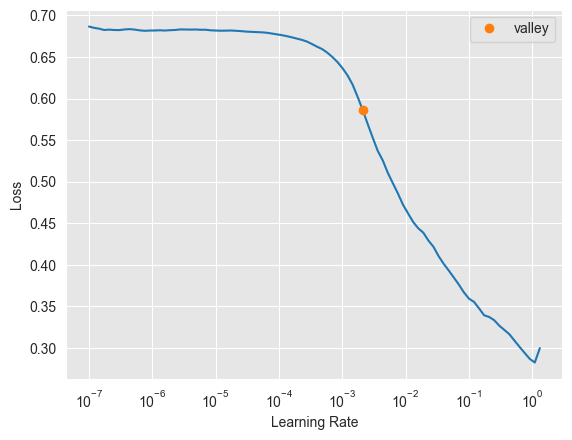

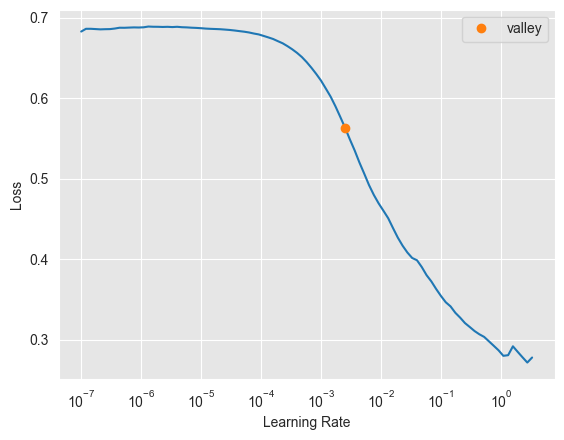

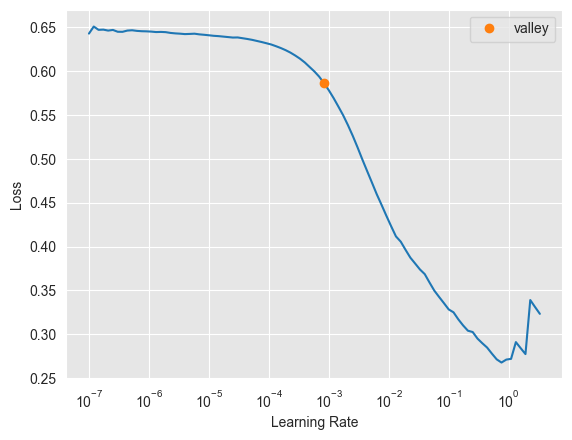

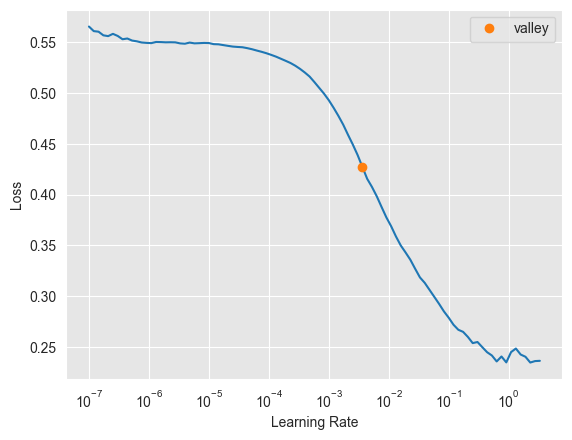

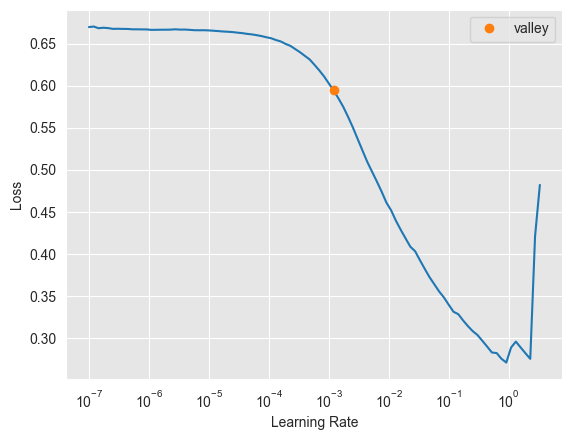

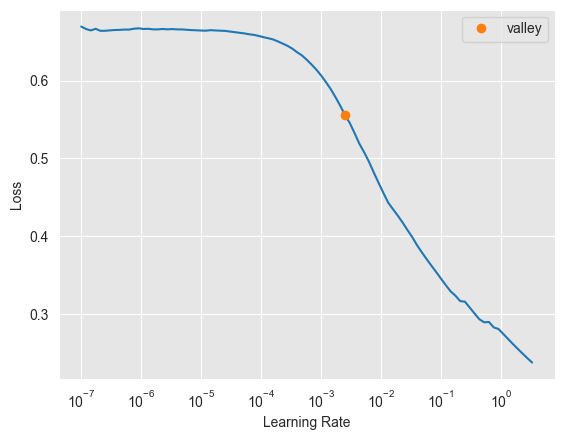

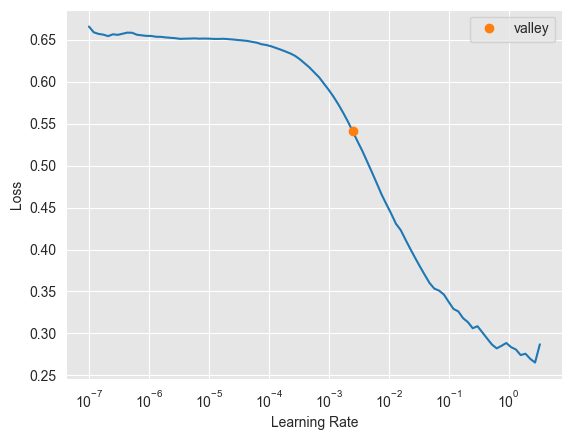

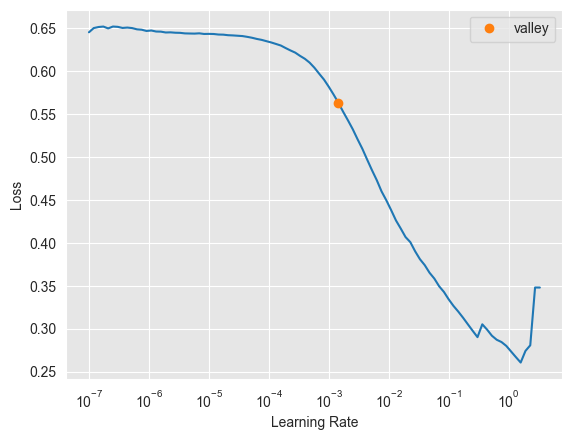

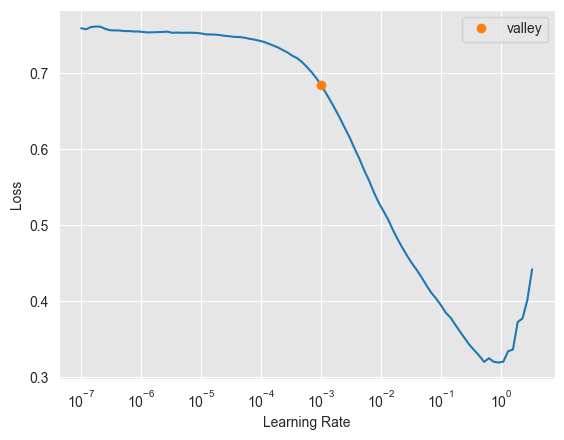

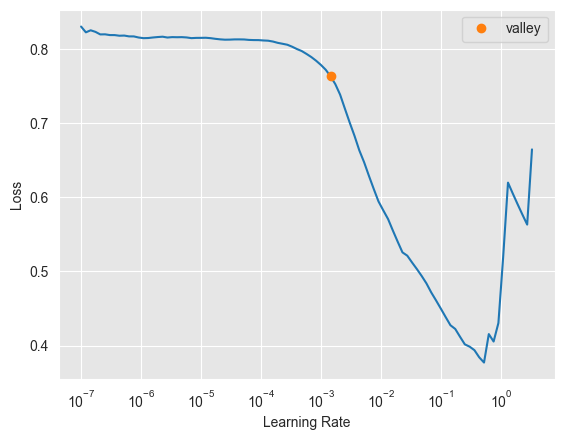

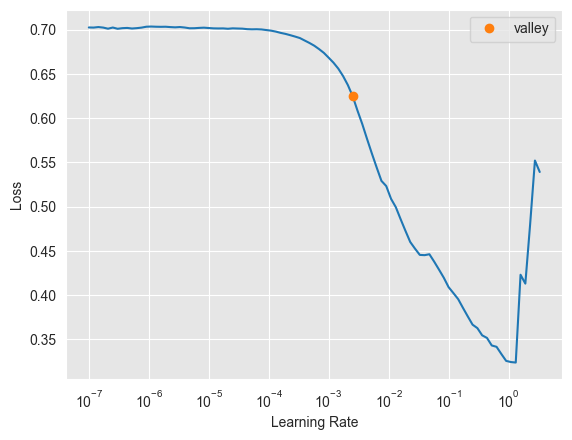

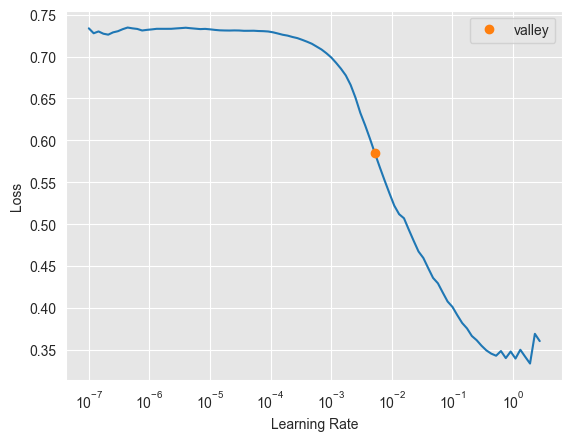

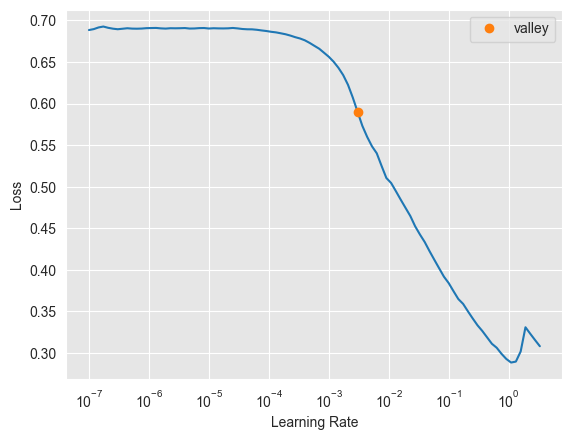

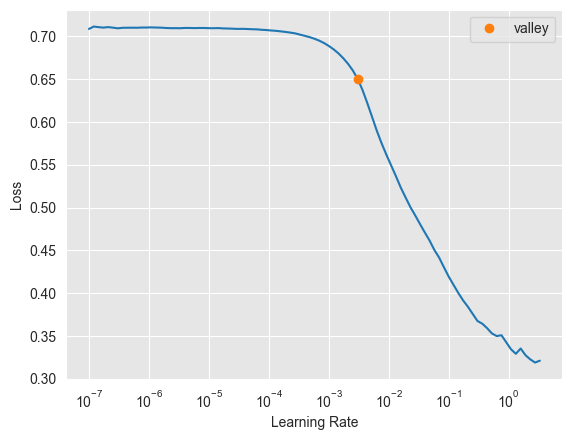

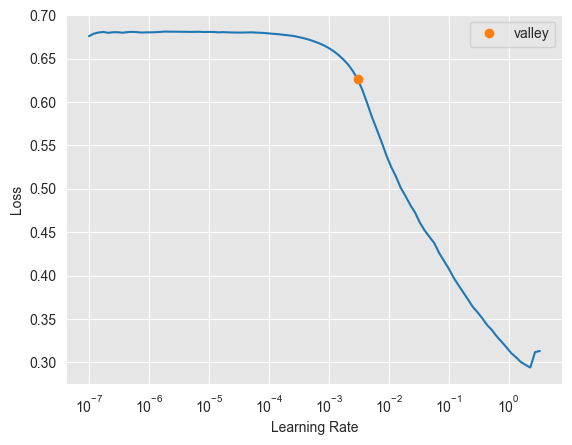

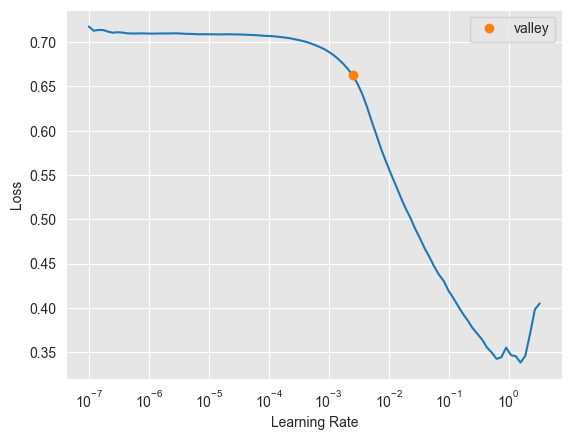

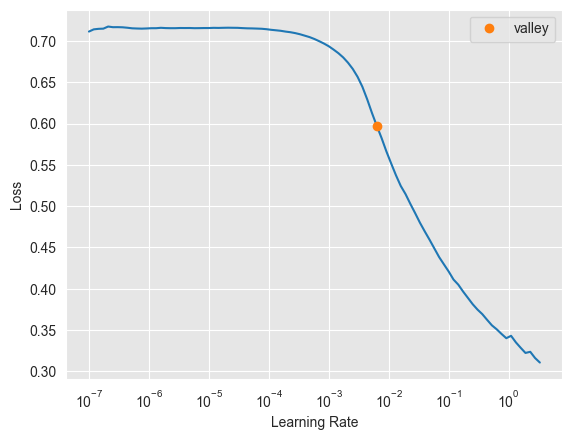

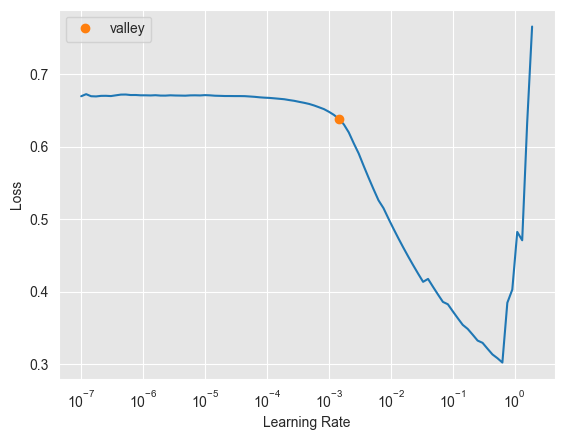

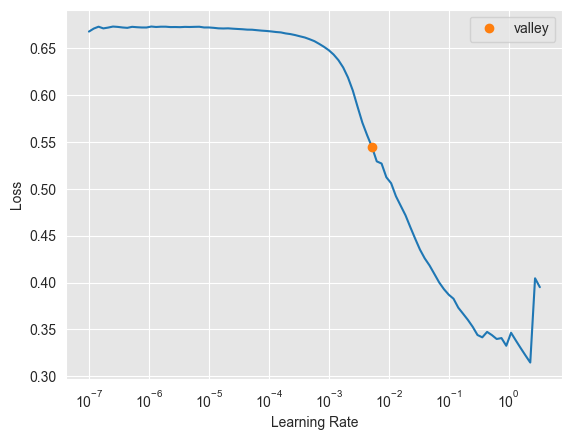

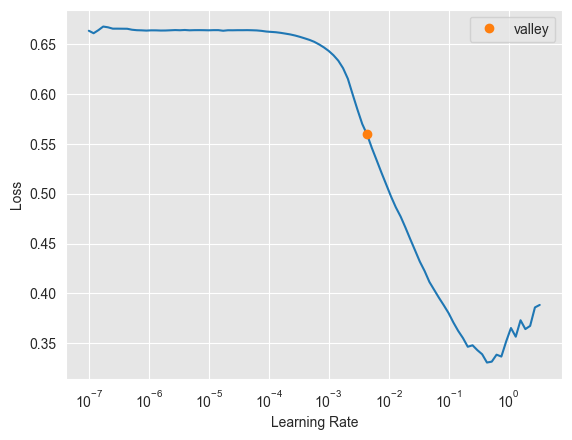

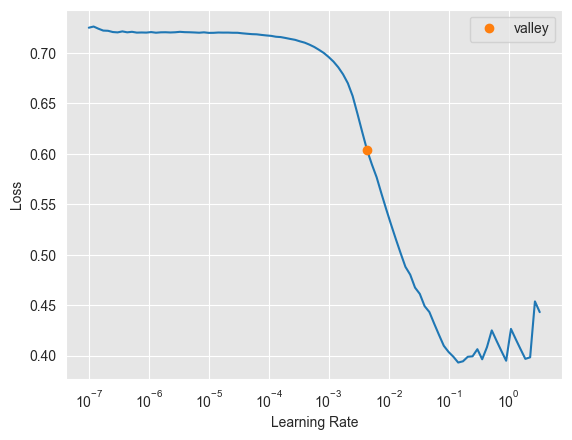

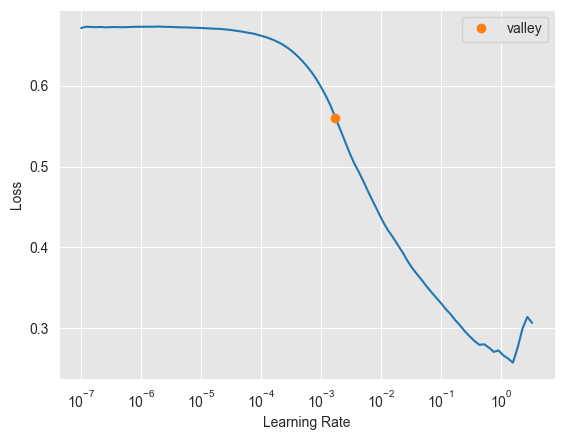

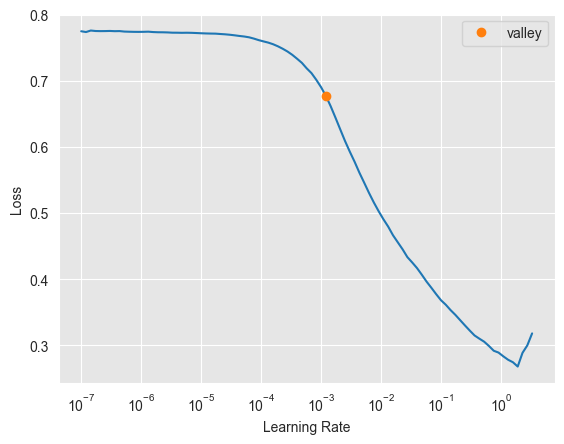

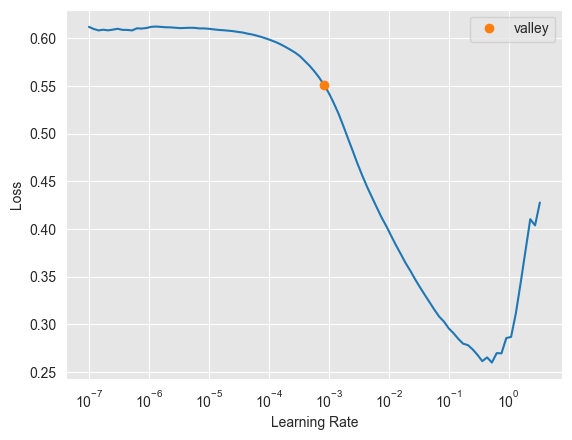

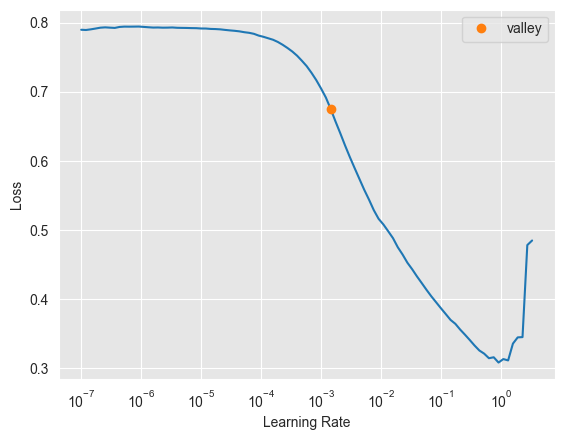

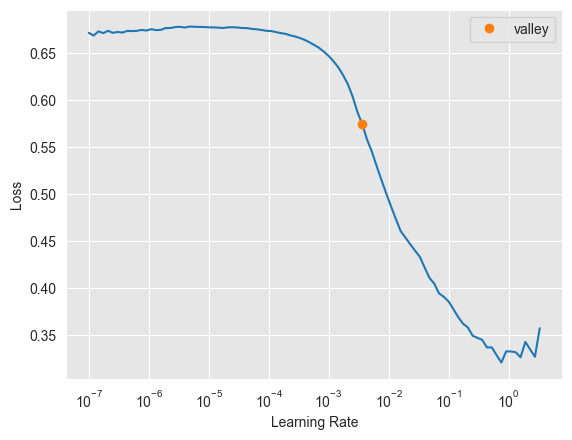

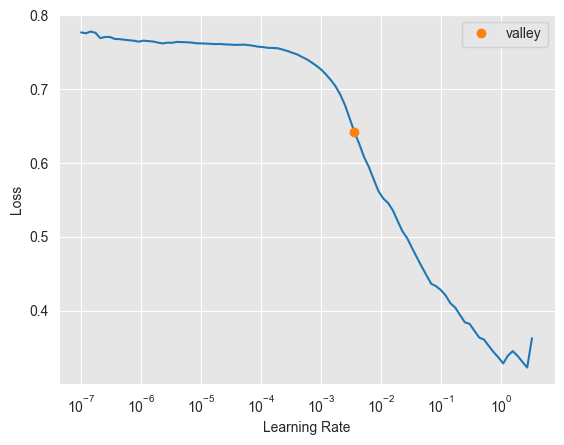

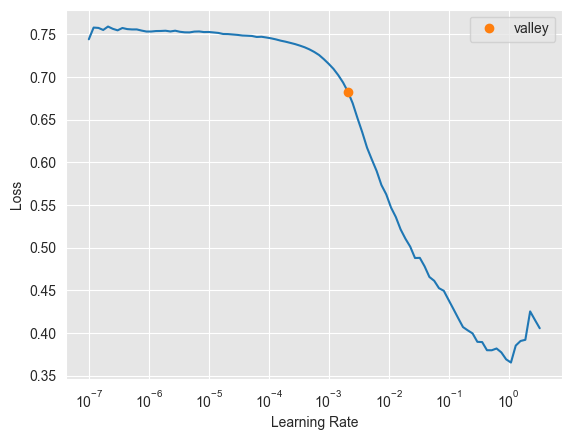

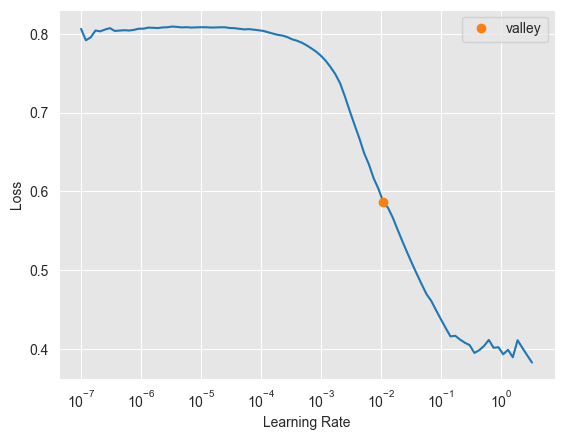

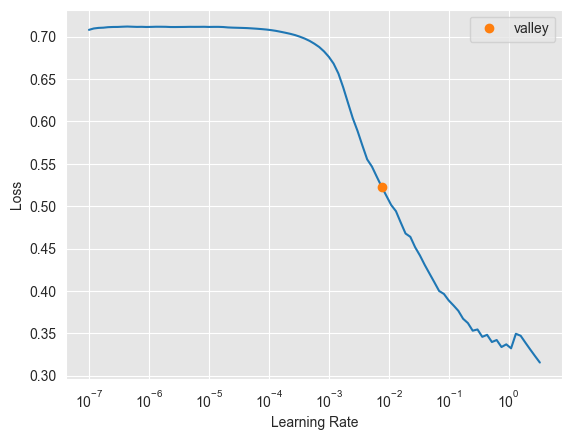

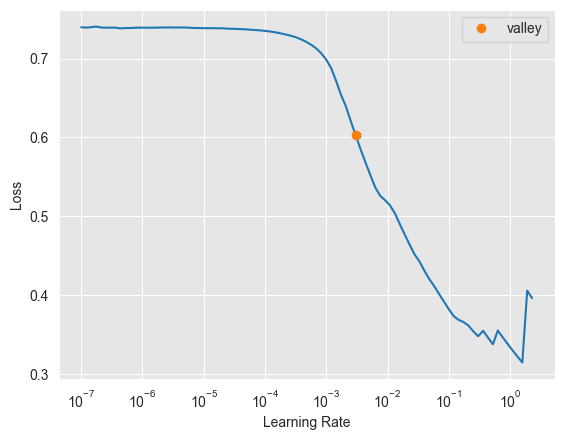

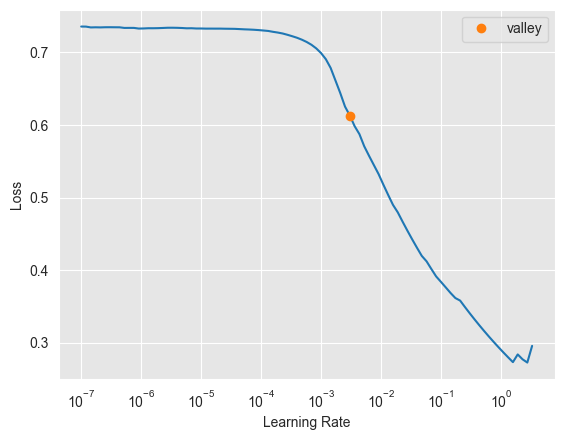

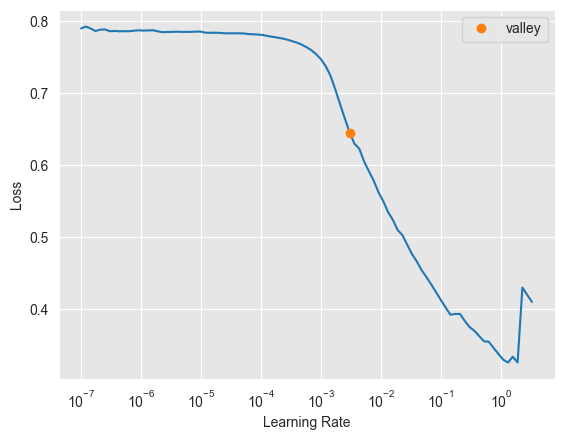

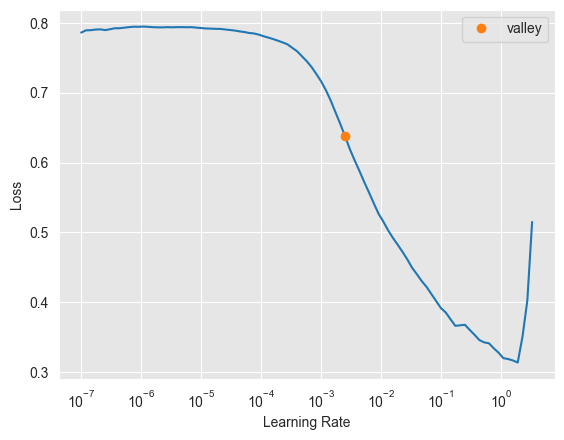

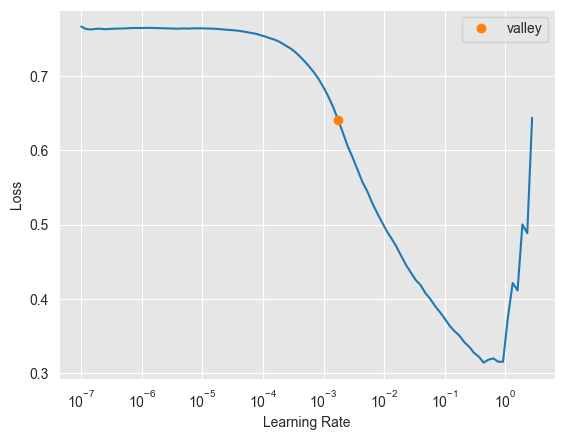

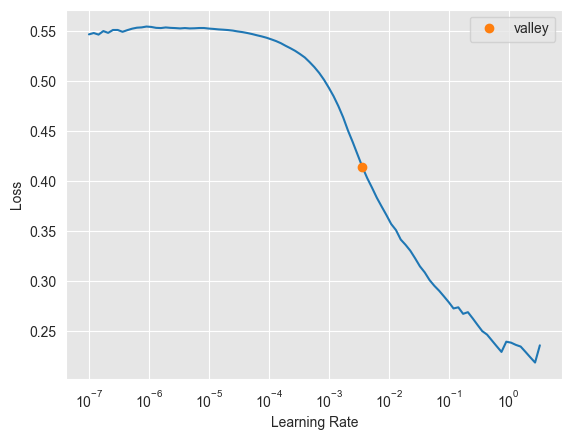

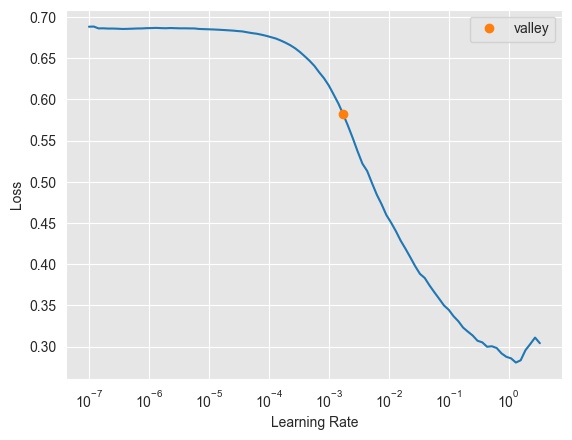

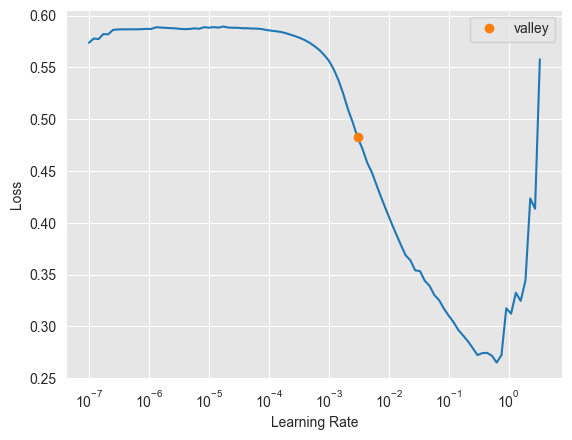

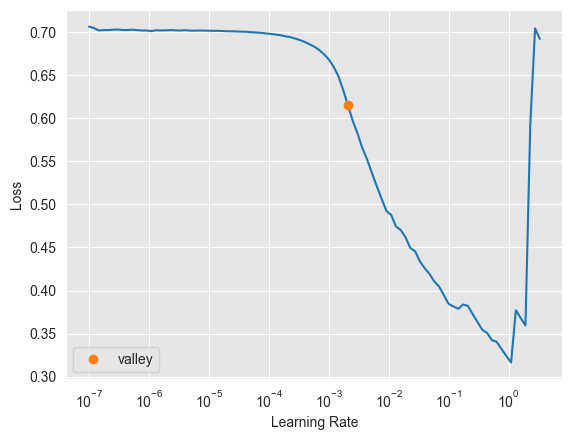

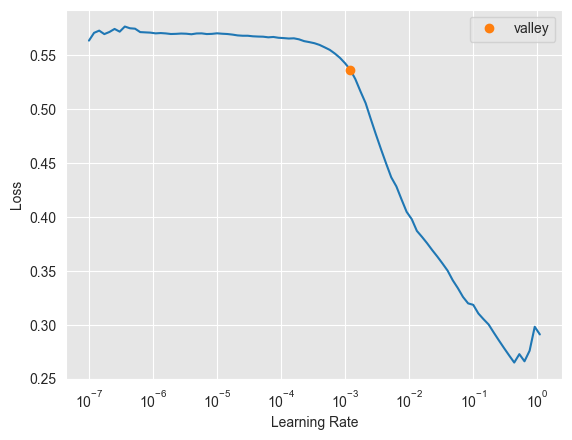

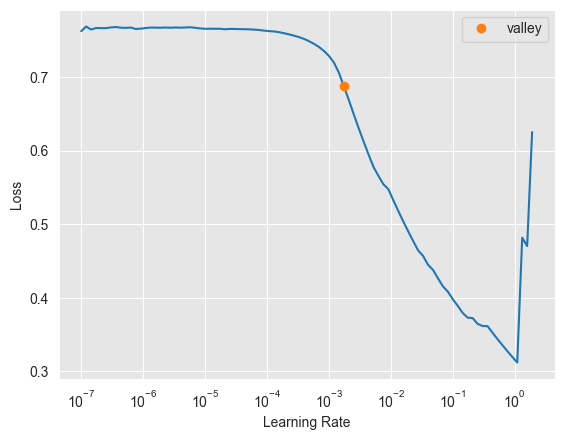

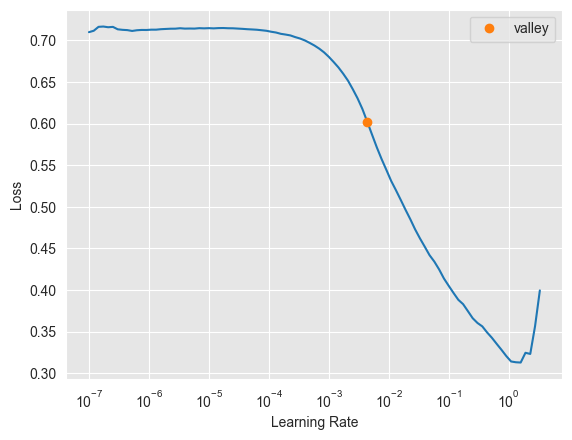

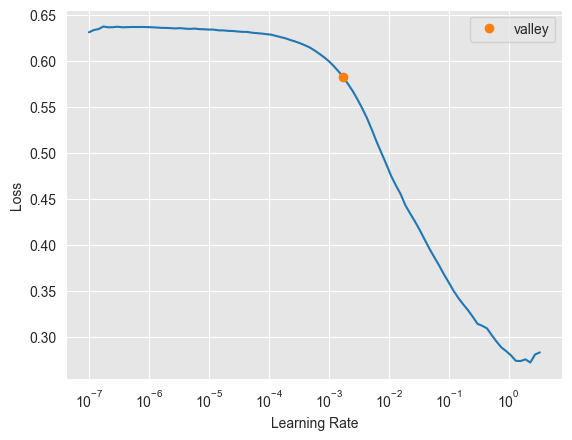

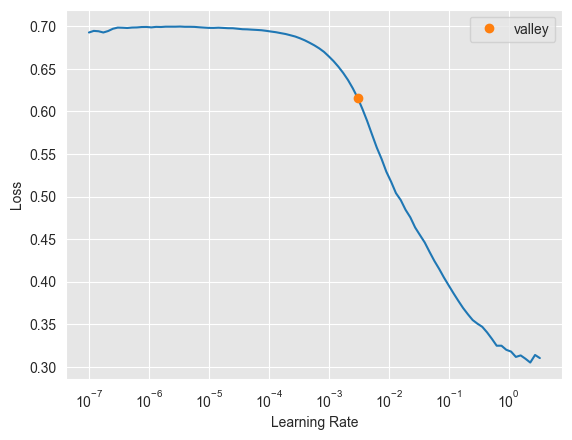

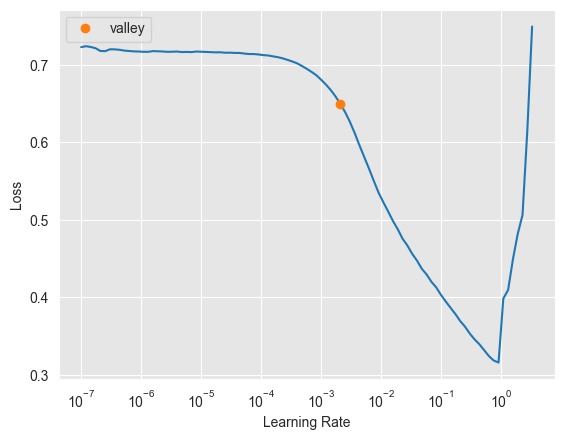

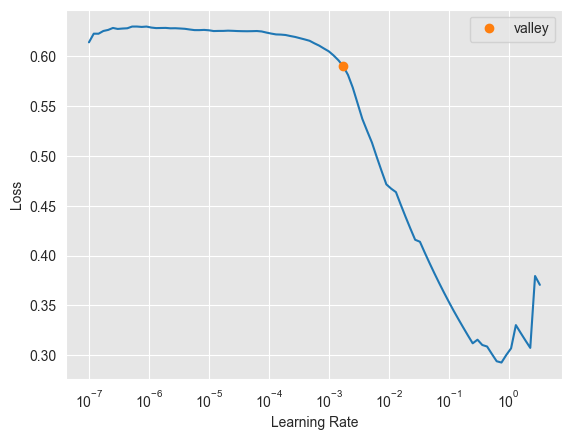

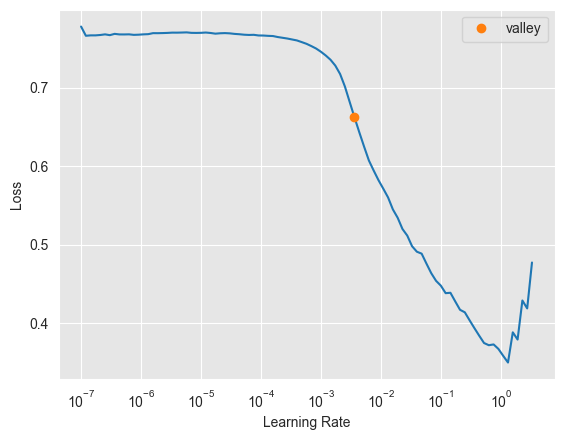

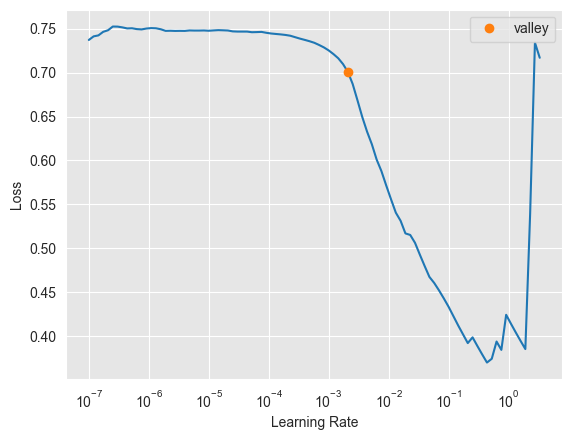

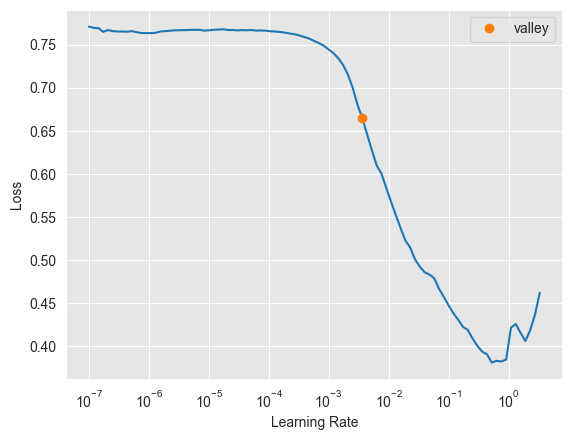

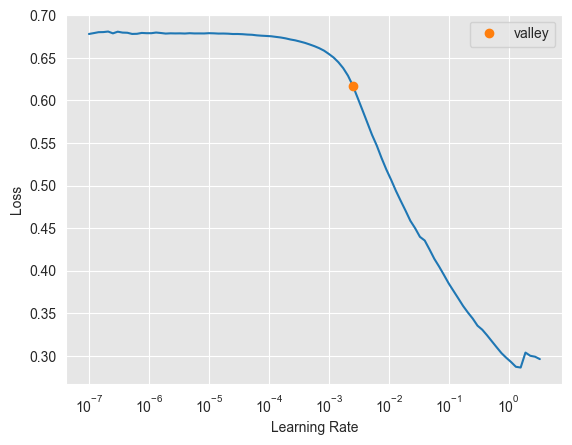

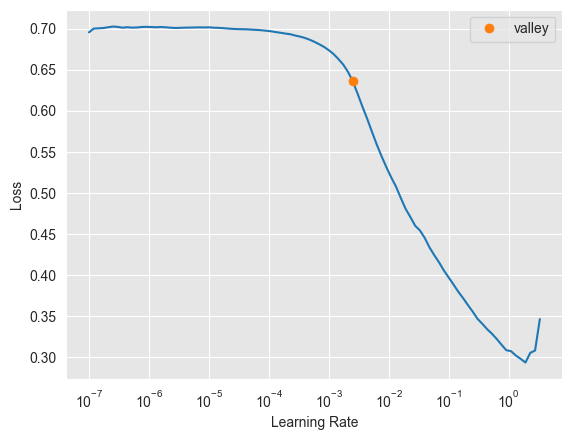

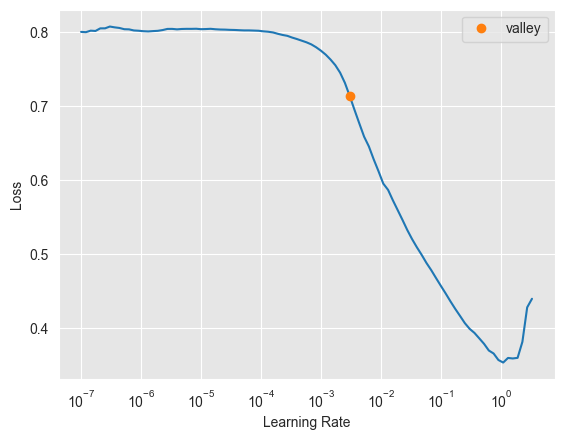

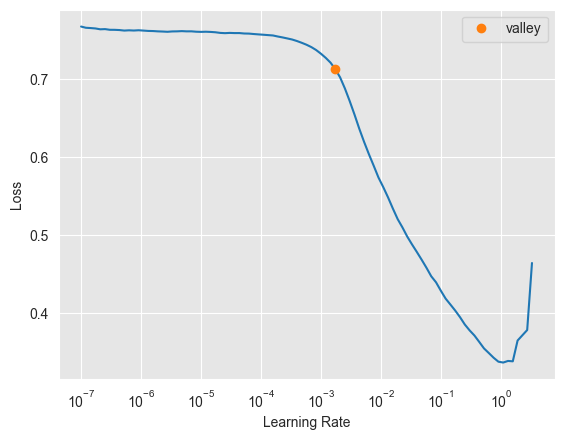

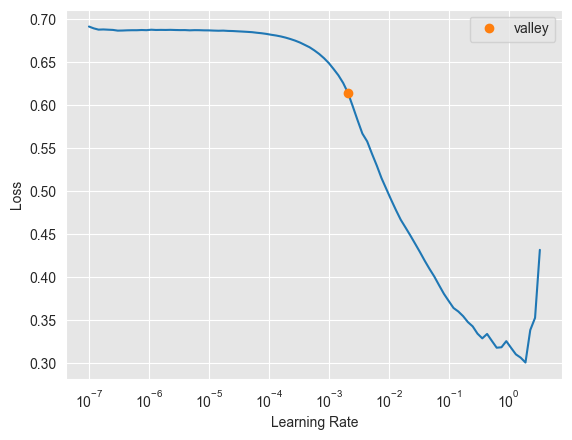

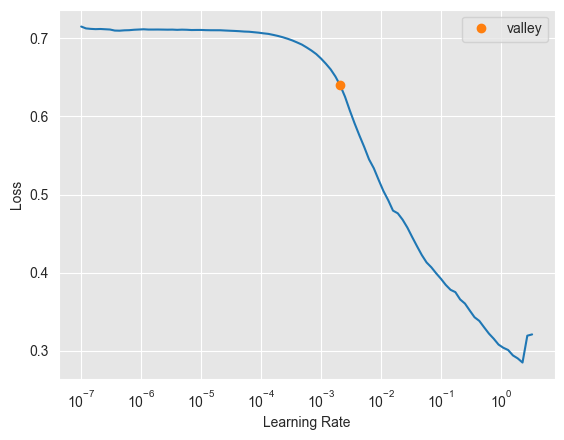

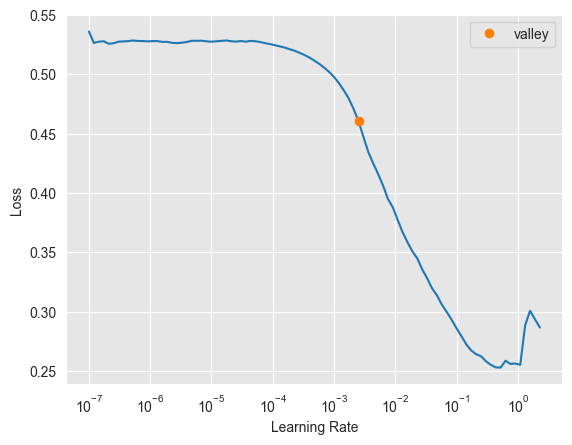

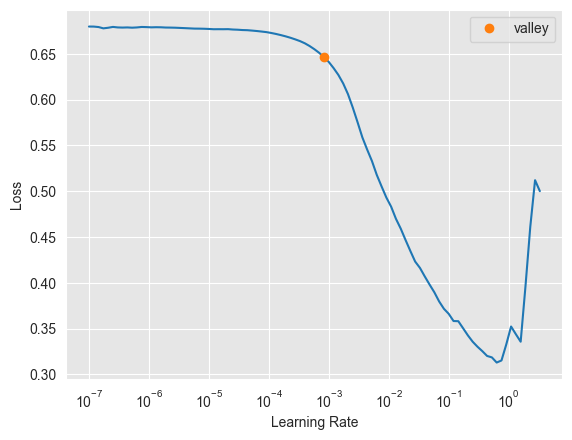

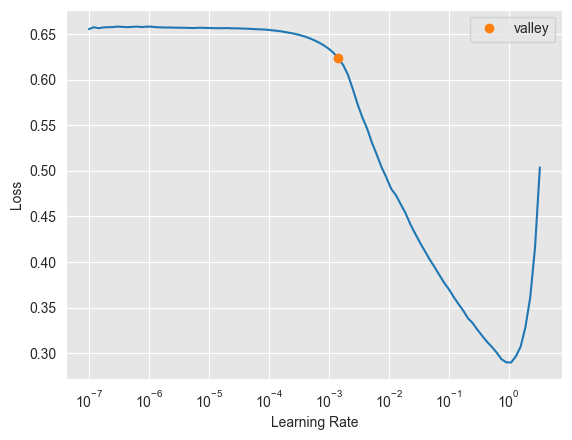

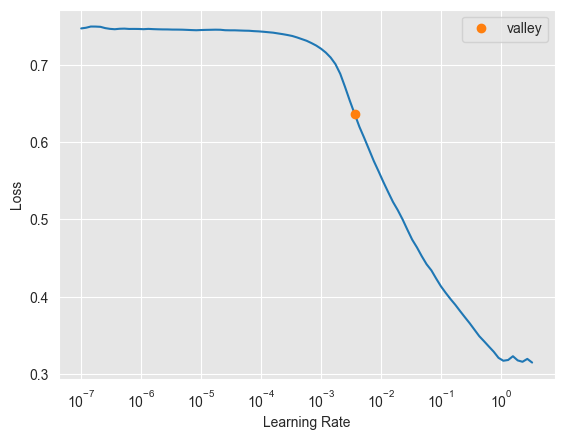

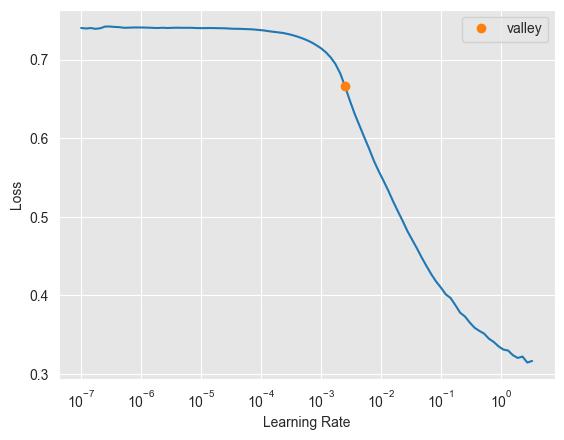

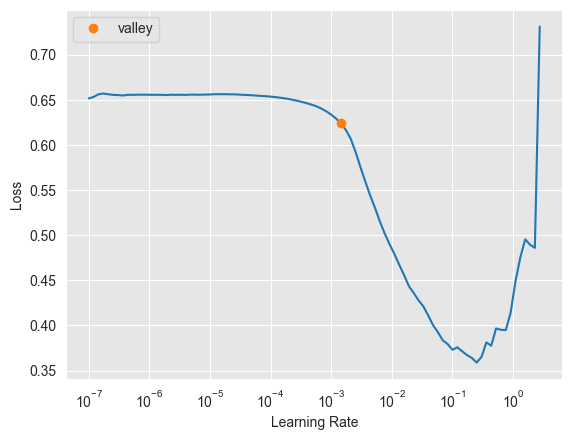

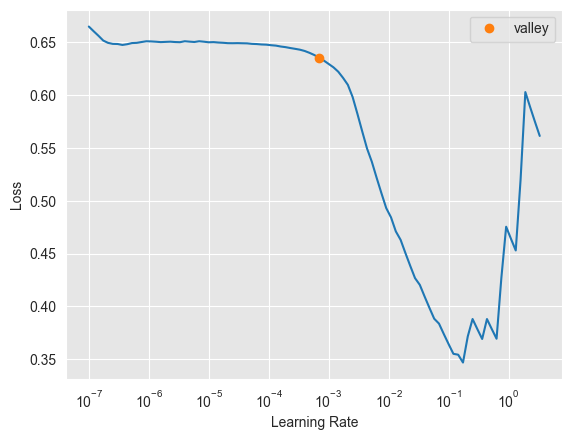

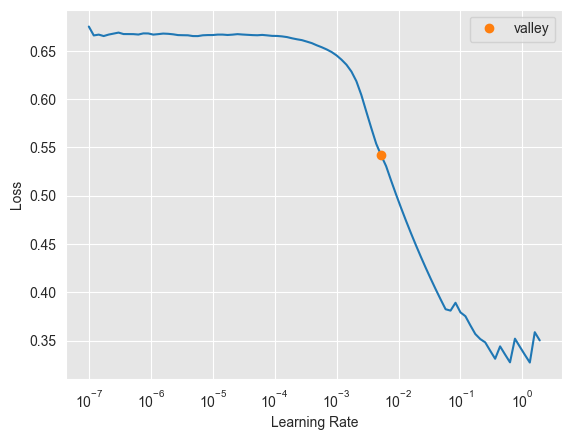

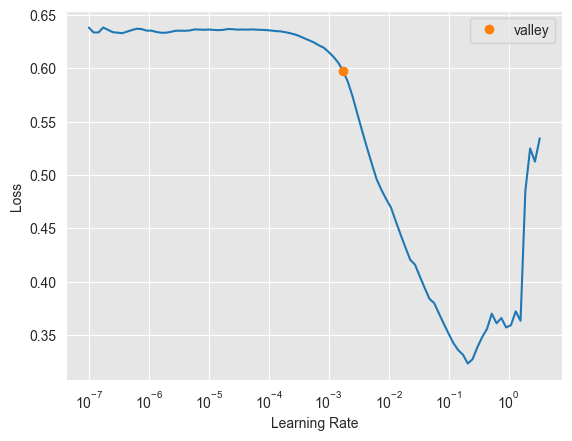

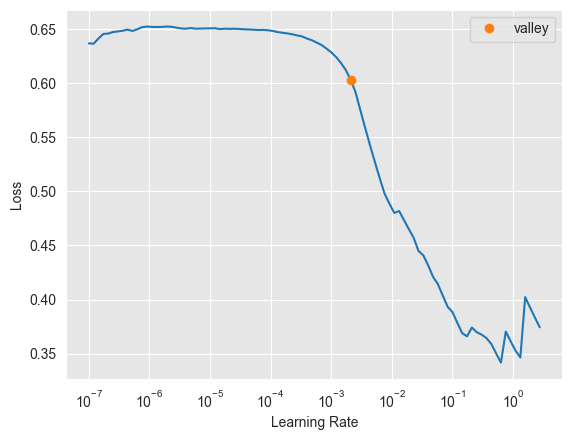

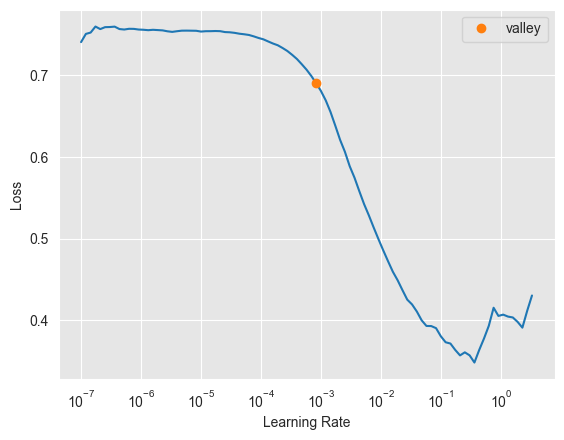

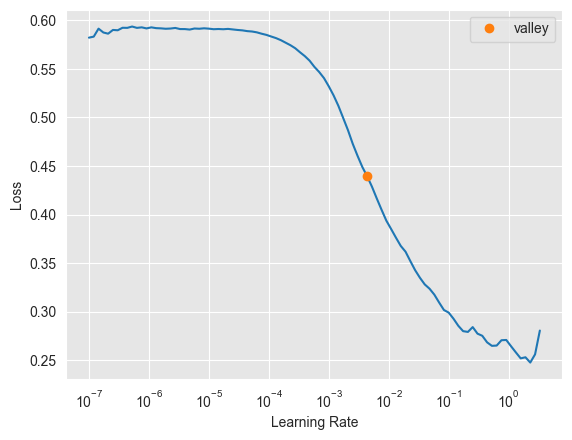

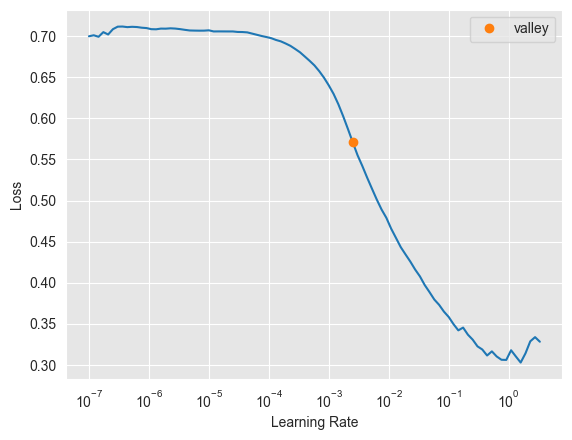

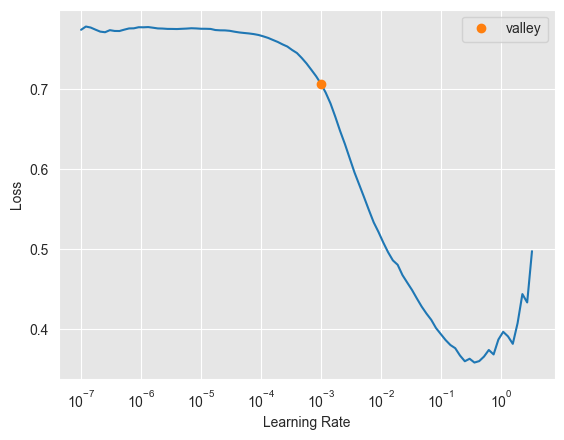

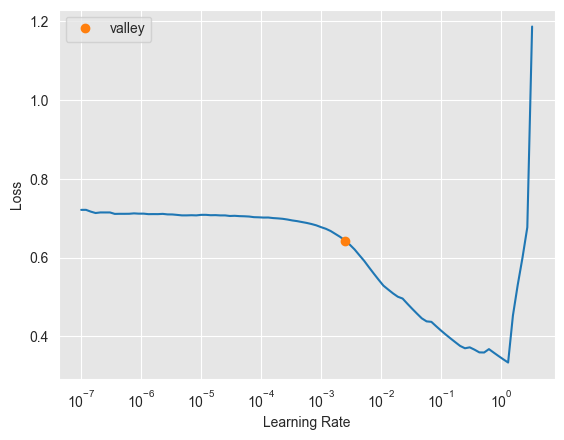

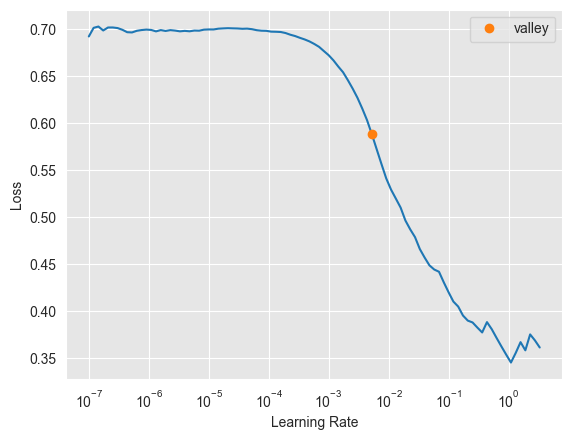

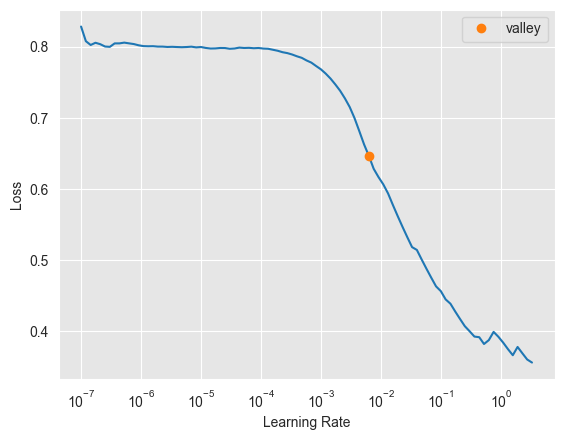

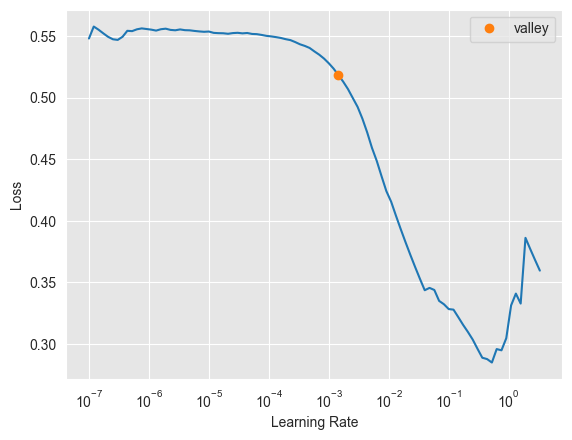

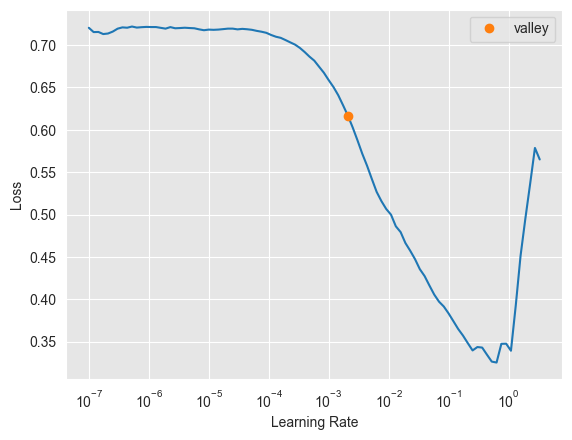

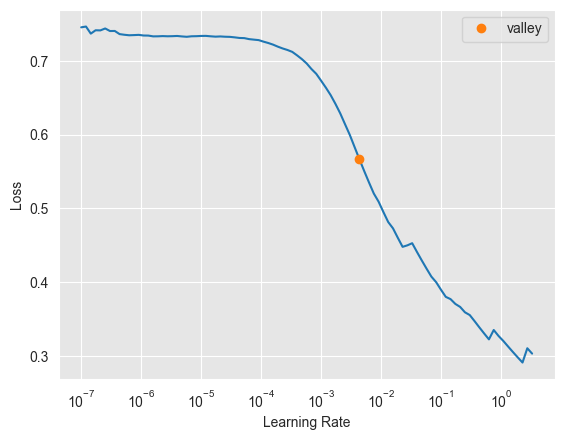

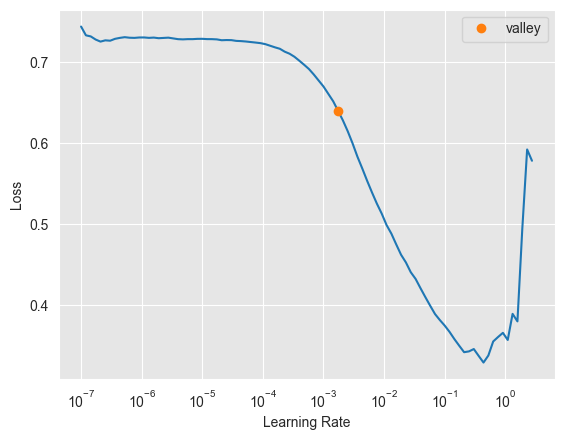

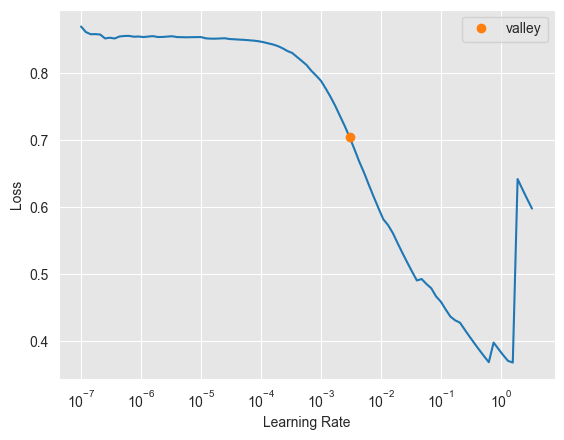

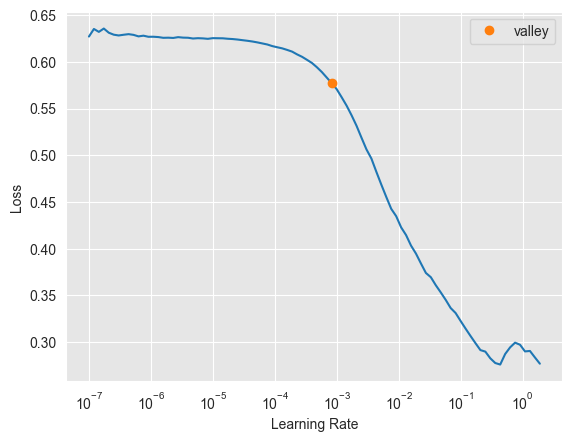

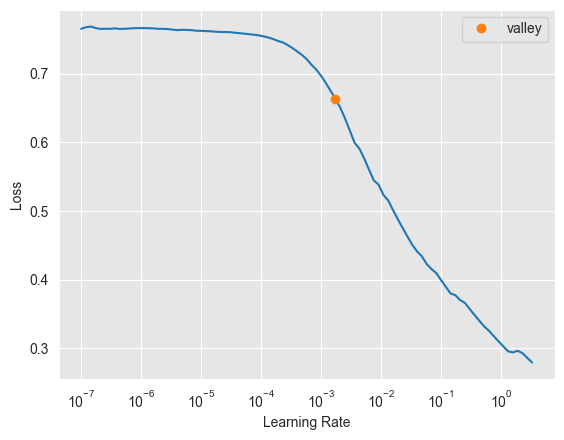

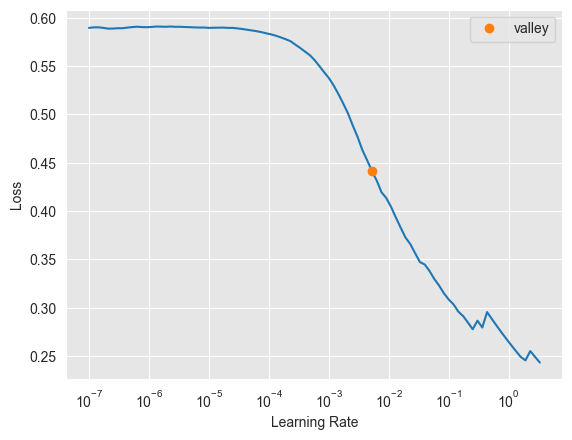

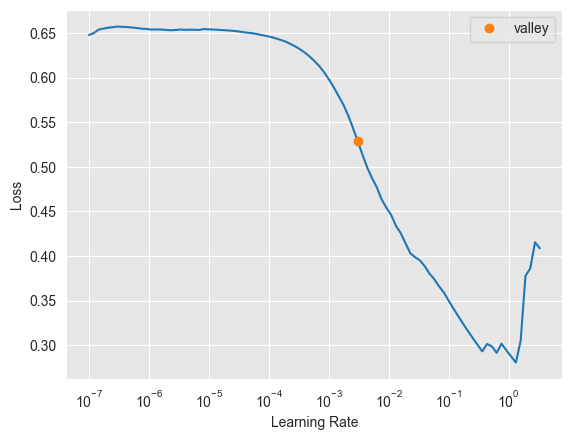

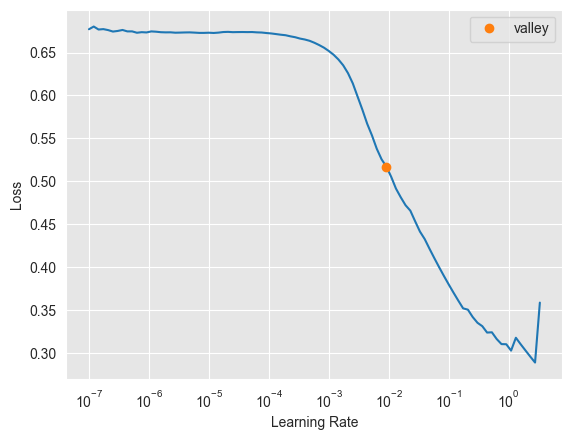

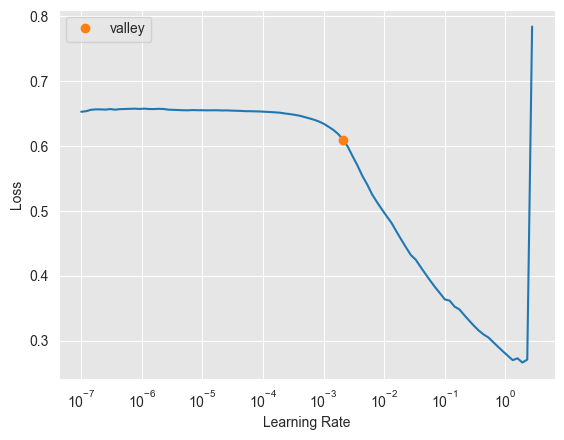

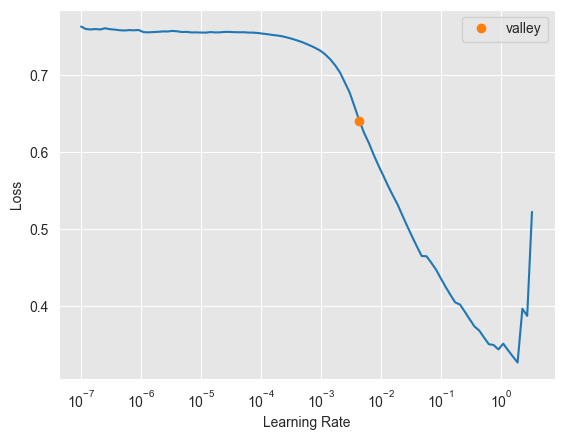

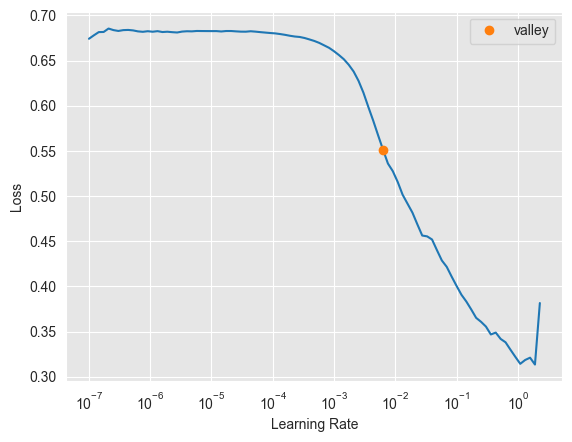

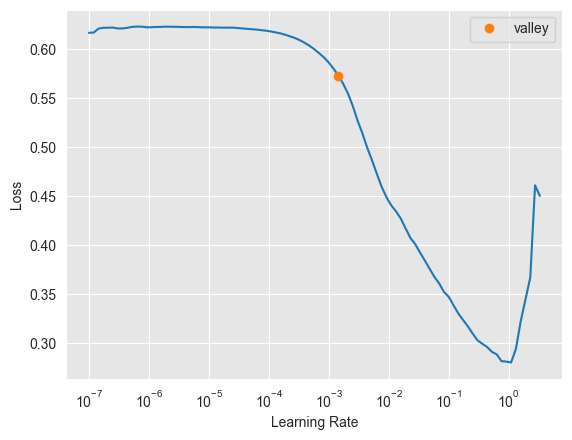

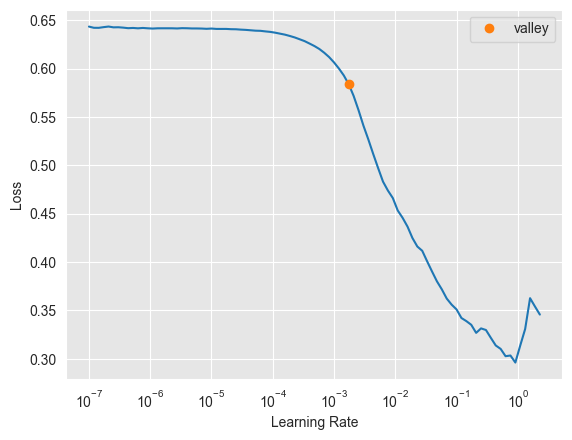

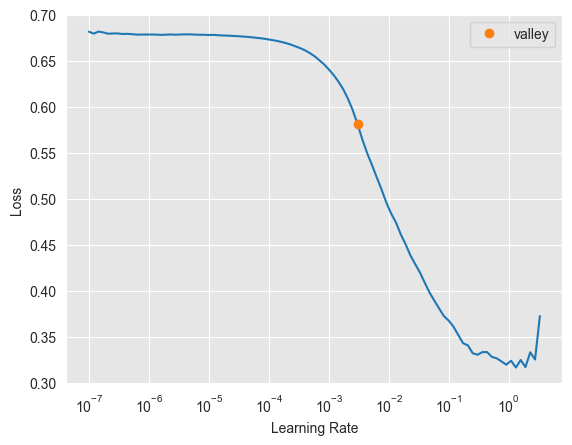

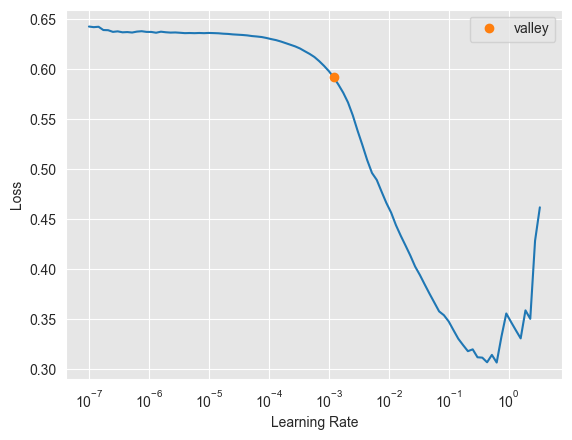

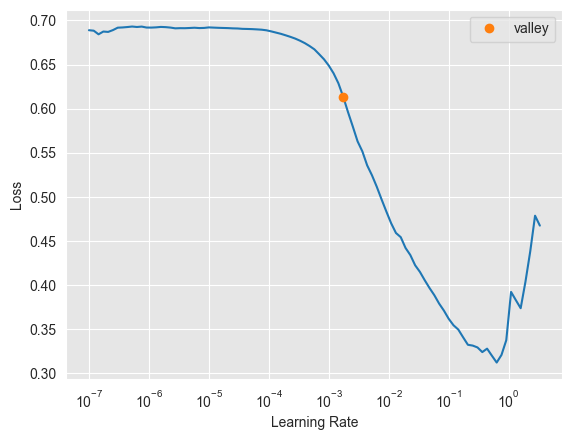

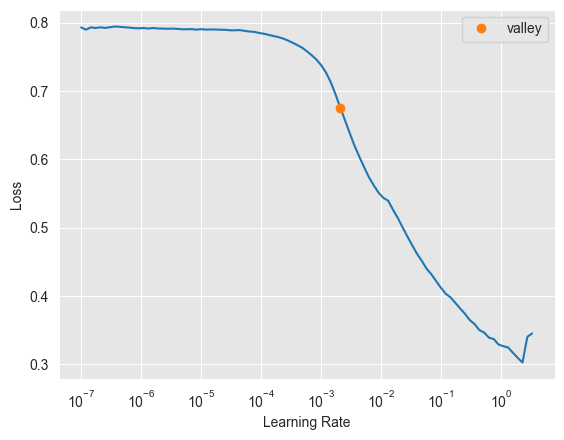

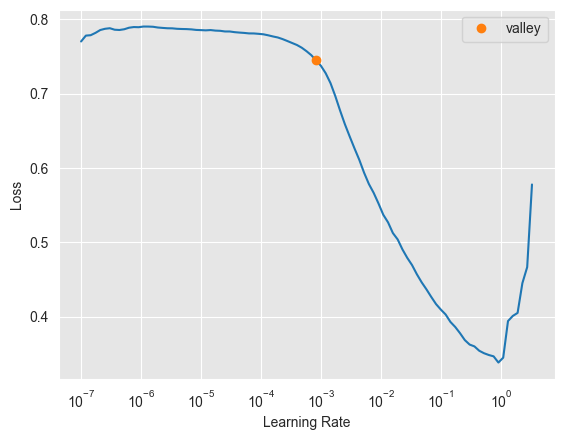

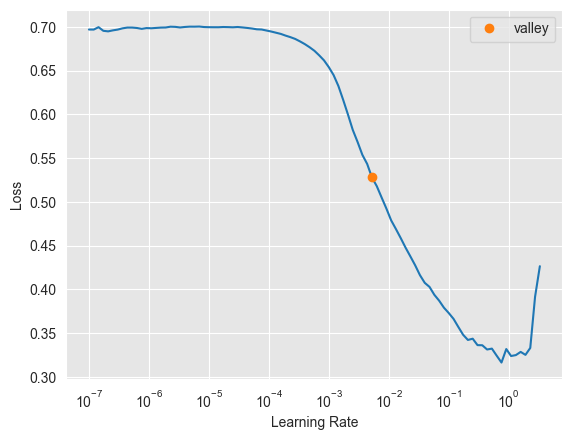

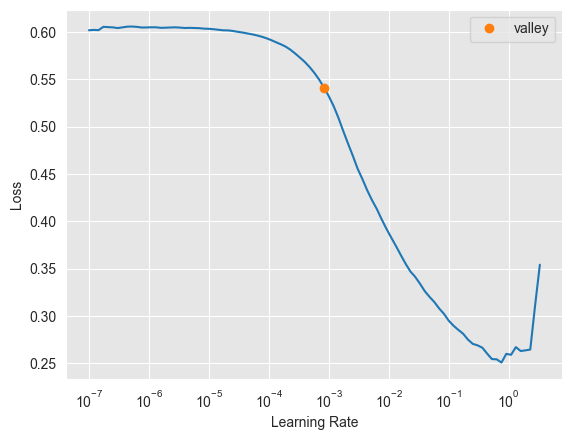

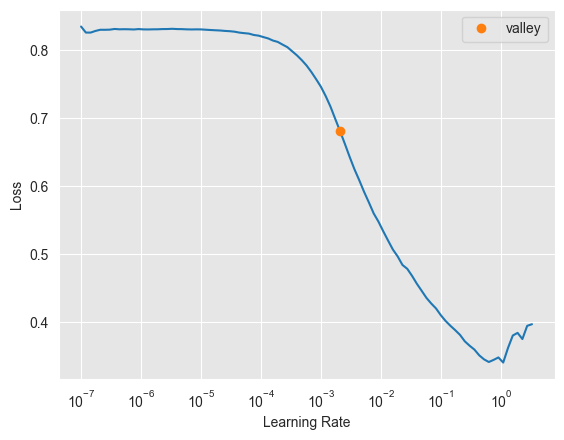

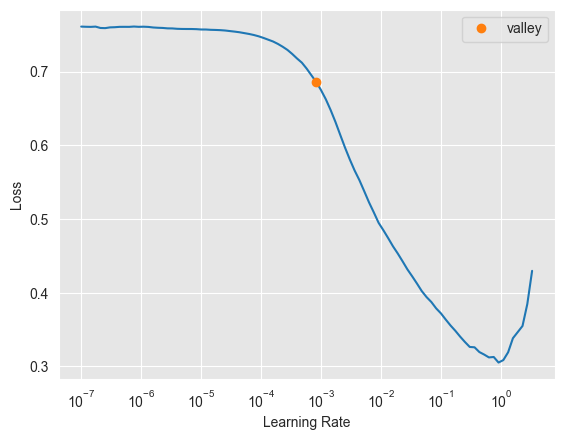

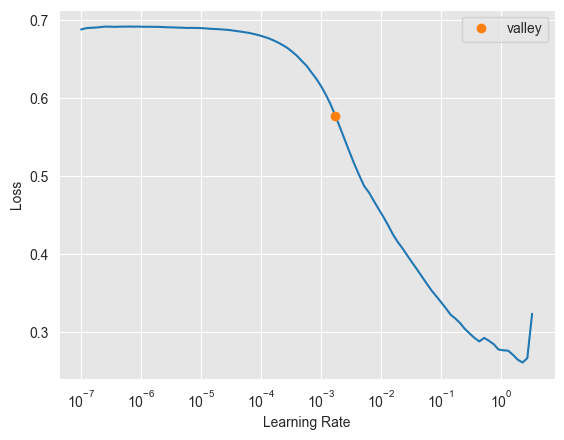

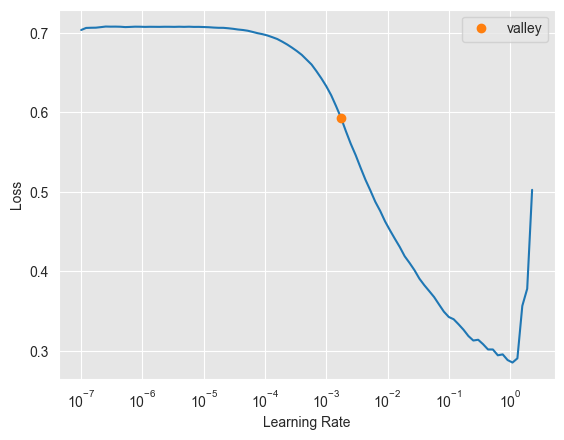

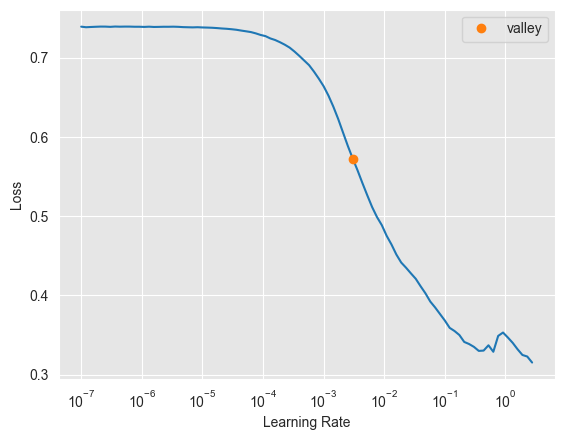

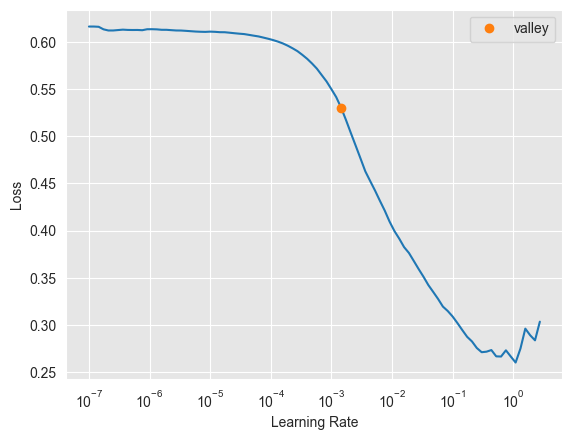

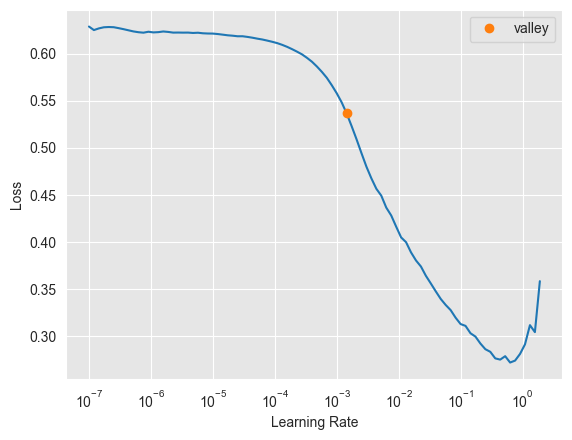

In [17]:
wandb.agent(sweep_id, train, count=60)